In [98]:
import os
from tqdm import trange
import wandb

import re
import gymnasium as gym
from llamagym import Agent
import numpy as np
import d3rlpy
import pickle

from gymnasium_env import BlackjackWrapper
import matplotlib.pyplot as plt

class InputParams:
    def __init__(self):
        self.env="Blackjack-v1"
        self.seed=1
        self.gpu=True

args=InputParams()
n_pretrain_eps = 125
n_online_eps = 375

# d3rlpy supports both Gym and Gymnasium
if args.env=="Blackjack-v1":
    env = BlackjackWrapper(gym.make("Blackjack-v1"))
    eval_env = BlackjackWrapper(gym.make("Blackjack-v1"))
else:
    env = gym.make(args.env)
    eval_env = gym.make(args.env)

# # fix seed
# d3rlpy.seed(args.seed)
# d3rlpy.envs.seed_env(env, args.seed)
# d3rlpy.envs.seed_env(eval_env, args.seed)

## Offline pretraining

In [79]:
# # setup algorithm
# llama_dqn = d3rlpy.algos.DQNConfig(
#     batch_size=32,
#     learning_rate=6.25e-5,
#     ).create(device=args.gpu)

# with open('data/random_eps_5000.pkl', 'rb') as file:
# # with open('data/Qwen2.5-0.5B_eps_5000.pkl', 'rb') as file:
# # with open('data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', 'rb') as file:
#     dataset = pickle.load(file)

# # start offline training
# llama_dqn.fit(dataset, n_steps=1300) #Around 500 eps here

# with open('models/dqn_random_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_Qwen2.5-0.5B_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_llama_eps_500.pkl', 'wb') as file:
#         pickle.dump(llama_dqn, file)

## Load pretrained model and online training

In [99]:
def online_training(
    env,
    eval_env,
    model_path=None,
    model=None,
    data_path=None,
    n_pretrain_eps=125,
    limit=1000000,
    n_steps=1050, # Online training ~375 eps
    n_steps_per_epoch=100,
    update_interval=1,
    cut_off_threshold=(125,500),
    gpu=True
):
    # Load model with proper validation
    if model_path:
        with open(model_path, 'rb') as file:
            dqn = pickle.load(file)
    elif model:
        dqn = model
    else:
        dqn = d3rlpy.algos.DQNConfig(
            batch_size=32,
            learning_rate=6.25e-5,
            ).create(device=gpu)

    # Initialize empty FIFO buffer
    buffer = d3rlpy.dataset.ReplayBuffer(
        buffer=d3rlpy.dataset.FIFOBuffer(limit=limit),
        env=env,
    )
    
    # Load and merge offline data with type-checking
    if data_path:
        try:
            # Load dataset with proper validation
            with open(data_path, 'rb') as f:
                dataset = pickle.load(f)
            
            # Verify dataset structure
            if hasattr(dataset, 'episodes'):
                # Calculate safe episode count to load
                valid_episodes = min(n_pretrain_eps, len(dataset.episodes))
                
                # Append episodes with transition validation
                for episode in dataset.episodes[:valid_episodes]:
                    if len(episode) > 0 and hasattr(episode, 'rewards'):
                        buffer.append_episode(episode)
                    else:
                        print(f"Skipping invalid episode: {episode}")
        except Exception as e:
            print(f"Error loading dataset: {str(e)}")

    # Configure training with safety checks
    if buffer.transition_count > 0:
        dqn.fit_online(
            env=env,
            buffer=buffer,
            eval_env=eval_env,
            n_steps=n_steps,
            n_steps_per_epoch=n_steps_per_epoch,
            update_interval=update_interval,
            experiment_name="online_training",
        )
    else:
        print("Empty buffer (just Online training)!")
        dqn.fit_online(
            env=env,
            buffer=buffer,
            eval_env=eval_env,
            n_steps=n_steps,
            n_steps_per_epoch=n_steps_per_epoch,
            update_interval=update_interval,
            experiment_name="online_training",
        )

    # Extract rewards safely
    rewards = []
    for episode in buffer.episodes: # Only collect the online data
        if hasattr(episode, 'rewards') and episode.rewards.size > 0:
            rewards.extend(episode.rewards.flatten().tolist())
    
    start, end = cut_off_threshold
    return rewards[start:end]

## Data collection

### Static/pretrain data

In [100]:
with open('data/Qwen2.5-0.5B_eps_5000.pkl', 'rb') as file:
    Qwen_dataset = pickle.load(file)
    
with open('data/random_eps_5000.pkl', 'rb') as file:
    rand_dataset = pickle.load(file)
    
with open('data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', 'rb') as file:
    llama_dataset = pickle.load(file)

Qwen_rewards = []
for i in range(n_pretrain_eps):
    Qwen_rewards.append(Qwen_dataset.episodes[i].rewards[0,0])
rand_rewards = []
for i in range(n_pretrain_eps):
    rand_rewards.append(rand_dataset.episodes[i].rewards[0,0])
llama_rewards = []
for i in range(n_pretrain_eps):
    llama_rewards.append(llama_dataset.episodes[i].rewards[0,0])

Qwen_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(Qwen_rewards)
rand_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(rand_rewards)
llama_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(llama_rewards)

### Online data

In [108]:
n_exp = 15
llama_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
Qwen_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
rand_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
onl_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
for i in range(n_exp):
    llama_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', n_pretrain_eps=n_eps)
    Qwen_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/Qwen2.5-0.5B_eps_5000.pkl', n_pretrain_eps=n_eps)
    rand_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/random_eps_5000.pkl', n_pretrain_eps=n_eps) #list length 250 here
    onl_rewards[:,i] = online_training(env, eval_env, n_steps=1400, cut_off_threshold=(0,500)) #list length 500 here

2025-03-18 00:02.45 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:02.45 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:02.45 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:02.45 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000245
2025-03-18 00:02.45 [debug    ] Building model...             
2025-03-18 00:02.45 [debug    ] Model has been built.         
2025-03-18 00:02.45 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}

  9%|▊         | 90/1050 [00:00<00:04, 206.14it/s]

2025-03-18 00:02.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_100.d3
2025-03-18 00:02.46 [info     ] online_training_20250318000245: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0023182153701782225, 'time_environment_step': 5.3970813751220704e-05, 'time_sample_batch': 0.0014629554748535156, 'time_algorithm_update': 0.003357653617858887, 'loss': 0.4078365403413773, 'time_step': 0.007294094562530518, 'rollout_return': -0.7017543859649122, 'evaluation': -0.2} step=100


 18%|█▊        | 186/1050 [00:01<00:03, 279.21it/s]

2025-03-18 00:02.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_200.d3
2025-03-18 00:02.47 [info     ] online_training_20250318000245: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003690981864929199, 'time_environment_step': 4.697561264038086e-05, 'rollout_return': -0.5, 'time_sample_batch': 0.00047052621841430663, 'time_algorithm_update': 0.0020795392990112303, 'loss': 0.40414768338203433, 'time_step': 0.0030621051788330077, 'evaluation': -0.4} step=200


 27%|██▋       | 283/1050 [00:01<00:02, 305.35it/s]

2025-03-18 00:02.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_300.d3
2025-03-18 00:02.47 [info     ] online_training_20250318000245: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003622770309448242, 'time_environment_step': 4.505157470703125e-05, 'rollout_return': -0.22727272727272727, 'time_sample_batch': 0.0004649949073791504, 'time_algorithm_update': 0.0020345044136047363, 'loss': 0.36951022744178774, 'time_step': 0.0029995918273925783, 'evaluation': -0.2} step=300


 36%|███▋      | 382/1050 [00:01<00:02, 315.36it/s]

2025-03-18 00:02.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_400.d3
2025-03-18 00:02.47 [info     ] online_training_20250318000245: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036658525466918944, 'time_environment_step': 4.609107971191406e-05, 'rollout_return': -0.10294117647058823, 'time_sample_batch': 0.00045658588409423827, 'time_algorithm_update': 0.0020378708839416506, 'loss': 0.36934950470924377, 'time_step': 0.0030016827583312987, 'evaluation': 0.0} step=400


 46%|████▌     | 481/1050 [00:01<00:01, 319.25it/s]

2025-03-18 00:02.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_500.d3
2025-03-18 00:02.47 [info     ] online_training_20250318000245: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003613924980163574, 'time_environment_step': 4.411458969116211e-05, 'time_sample_batch': 0.00046083450317382815, 'time_algorithm_update': 0.002027428150177002, 'loss': 0.35952181324362753, 'time_step': 0.002994074821472168, 'rollout_return': 0.043478260869565216, 'evaluation': -0.6} step=500


 55%|█████▌    | 580/1050 [00:02<00:01, 317.52it/s]

2025-03-18 00:02.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_600.d3
2025-03-18 00:02.48 [info     ] online_training_20250318000245: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036752939224243163, 'time_environment_step': 4.655361175537109e-05, 'rollout_return': -0.1232876712328767, 'time_sample_batch': 0.00046548604965209963, 'time_algorithm_update': 0.002051846981048584, 'loss': 0.37668192192912103, 'time_step': 0.003029379844665527, 'evaluation': -0.3} step=600


 65%|██████▍   | 678/1050 [00:02<00:01, 317.64it/s]

2025-03-18 00:02.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_700.d3
2025-03-18 00:02.48 [info     ] online_training_20250318000245: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003637385368347168, 'time_environment_step': 4.6546459197998044e-05, 'rollout_return': -0.21875, 'time_sample_batch': 0.00046336889266967773, 'time_algorithm_update': 0.002059128284454346, 'loss': 0.3504570983350277, 'time_step': 0.0030277681350708006, 'evaluation': 0.1} step=700


 74%|███████▍  | 776/1050 [00:02<00:00, 317.34it/s]

2025-03-18 00:02.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_800.d3
2025-03-18 00:02.48 [info     ] online_training_20250318000245: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003735685348510742, 'time_environment_step': 4.55474853515625e-05, 'rollout_return': -0.13432835820895522, 'time_sample_batch': 0.00047087907791137695, 'time_algorithm_update': 0.002091348171234131, 'loss': 0.3685647718608379, 'time_step': 0.0030792903900146483, 'evaluation': 0.4} step=800


 83%|████████▎ | 874/1050 [00:03<00:00, 315.28it/s]

2025-03-18 00:02.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_900.d3
2025-03-18 00:02.49 [info     ] online_training_20250318000245: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003736972808837891, 'time_environment_step': 4.652738571166992e-05, 'time_sample_batch': 0.00046558380126953124, 'time_algorithm_update': 0.0020514225959777834, 'loss': 0.35510834157466886, 'time_step': 0.0030352449417114257, 'rollout_return': 0.0, 'evaluation': -0.2} step=900


 93%|█████████▎| 972/1050 [00:03<00:00, 318.09it/s]

2025-03-18 00:02.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000245/model_1000.d3
2025-03-18 00:02.49 [info     ] online_training_20250318000245: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036632776260375977, 'time_environment_step': 4.7333240509033203e-05, 'time_sample_batch': 0.00045814037322998045, 'time_algorithm_update': 0.0020395922660827637, 'loss': 0.3580160601437092, 'time_step': 0.0030039048194885256, 'rollout_return': 0.046153846153846156, 'evaluation': -0.3} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 278.66it/s]

2025-03-18 00:02.49 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:02.49 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:02.49 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:02.49 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000249
2025-03-18 00:02.49 [debug    ] Building model...             


2025-03-18 00:02.50 [debug    ] Model has been built.         
2025-03-18 00:02.50 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 74/1050 [00:00<00:04, 228.67it/s]

2025-03-18 00:02.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_100.d3
2025-03-18 00:02.50 [info     ] online_training_20250318000249: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0003833365440368652, 'time_environment_step': 4.8298835754394534e-05, 'rollout_return': -0.7627118644067796, 'time_sample_batch': 0.0014022445678710937, 'time_algorithm_update': 0.003009951114654541, 'loss': 0.554731422662735, 'time_step': 0.00493478536605835, 'evaluation': 0.9} step=100


 16%|█▌        | 167/1050 [00:00<00:03, 289.50it/s]

2025-03-18 00:02.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_200.d3
2025-03-18 00:02.50 [info     ] online_training_20250318000249: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003665804862976074, 'time_environment_step': 4.6875476837158206e-05, 'rollout_return': -0.4603174603174603, 'time_sample_batch': 0.00046300649642944336, 'time_algorithm_update': 0.0020559906959533693, 'loss': 0.6319386452436447, 'time_step': 0.0030240821838378906, 'evaluation': -0.4} step=200


 28%|██▊       | 298/1050 [00:01<00:02, 310.56it/s]

2025-03-18 00:02.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_300.d3
2025-03-18 00:02.51 [info     ] online_training_20250318000249: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037623167037963867, 'time_environment_step': 4.875659942626953e-05, 'time_sample_batch': 0.0004644274711608887, 'time_algorithm_update': 0.002086834907531738, 'loss': 0.6443062236905098, 'time_step': 0.0030704188346862794, 'rollout_return': -0.373134328358209, 'evaluation': -0.4} step=300


 38%|███▊      | 396/1050 [00:01<00:02, 314.83it/s]

2025-03-18 00:02.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_400.d3
2025-03-18 00:02.51 [info     ] online_training_20250318000249: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037151098251342774, 'time_environment_step': 4.7304630279541015e-05, 'rollout_return': -0.17647058823529413, 'time_sample_batch': 0.00046222448348999024, 'time_algorithm_update': 0.0020686292648315428, 'loss': 0.6241888415813446, 'time_step': 0.003044266700744629, 'evaluation': -0.3} step=400


 47%|████▋     | 494/1050 [00:01<00:01, 316.46it/s]

2025-03-18 00:02.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_500.d3
2025-03-18 00:02.51 [info     ] online_training_20250318000249: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003715968132019043, 'time_environment_step': 4.712581634521484e-05, 'rollout_return': -0.5, 'time_sample_batch': 0.00046063899993896483, 'time_algorithm_update': 0.0020562219619750977, 'loss': 0.6549940004944801, 'time_step': 0.0030278801918029786, 'evaluation': -0.4} step=500


 56%|█████▋    | 592/1050 [00:02<00:01, 317.22it/s]

2025-03-18 00:02.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_600.d3
2025-03-18 00:02.52 [info     ] online_training_20250318000249: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036704301834106446, 'time_environment_step': 4.8818588256835935e-05, 'rollout_return': -0.21875, 'time_sample_batch': 0.00046128034591674805, 'time_algorithm_update': 0.0020638275146484374, 'loss': 0.6370879951119423, 'time_step': 0.003034265041351318, 'evaluation': 0.3} step=600


 66%|██████▌   | 690/1050 [00:02<00:01, 318.07it/s]

2025-03-18 00:02.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_700.d3
2025-03-18 00:02.52 [info     ] online_training_20250318000249: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003683853149414062, 'time_environment_step': 4.7776699066162106e-05, 'rollout_return': -0.2903225806451613, 'time_sample_batch': 0.000466156005859375, 'time_algorithm_update': 0.0020527720451354982, 'loss': 0.6151688608527184, 'time_step': 0.00302523136138916, 'evaluation': -0.1} step=700


 75%|███████▌  | 788/1050 [00:02<00:00, 315.79it/s]

2025-03-18 00:02.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_800.d3
2025-03-18 00:02.52 [info     ] online_training_20250318000249: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036827802658081056, 'time_environment_step': 4.456520080566406e-05, 'rollout_return': -0.16923076923076924, 'time_sample_batch': 0.0004599928855895996, 'time_algorithm_update': 0.002078547477722168, 'loss': 0.6159621849656105, 'time_step': 0.003048264980316162, 'evaluation': 0.0} step=800


 84%|████████▍ | 885/1050 [00:03<00:00, 314.30it/s]

2025-03-18 00:02.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_900.d3
2025-03-18 00:02.53 [info     ] online_training_20250318000249: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037737131118774413, 'time_environment_step': 4.7619342803955076e-05, 'time_sample_batch': 0.00046570777893066405, 'time_algorithm_update': 0.0020911669731140136, 'loss': 0.609864111840725, 'time_step': 0.003073604106903076, 'rollout_return': -0.2698412698412698, 'evaluation': 0.3} step=900


 94%|█████████▎| 983/1050 [00:03<00:00, 315.65it/s]

2025-03-18 00:02.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000249/model_1000.d3
2025-03-18 00:02.53 [info     ] online_training_20250318000249: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003705787658691406, 'time_environment_step': 4.7688484191894534e-05, 'time_sample_batch': 0.00046327114105224607, 'time_algorithm_update': 0.002061138153076172, 'loss': 0.6127323007583618, 'time_step': 0.0030343151092529297, 'rollout_return': -0.15873015873015872, 'evaluation': -0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 295.75it/s]

2025-03-18 00:02.53 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:02.53 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:02.53 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:02.54 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000254
2025-03-18 00:02.54 [debug    ] Building model...             
2025-03-18 00:02.54 [debug    ] Model has been built.         
2025-03-18 00:02.54 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 72/1050 [00:00<00:05, 182.57it/s]

2025-03-18 00:02.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_100.d3
2025-03-18 00:02.54 [info     ] online_training_20250318000254: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0011910080909729003, 'time_environment_step': 5.182266235351563e-05, 'time_sample_batch': 0.0005073094367980957, 'time_algorithm_update': 0.005078816413879394, 'loss': 0.41446123749017716, 'time_step': 0.006923635005950928, 'rollout_return': -0.6785714285714286, 'evaluation': -0.3} step=100


 19%|█▉        | 199/1050 [00:01<00:02, 288.89it/s]

2025-03-18 00:02.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_200.d3
2025-03-18 00:02.55 [info     ] online_training_20250318000254: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000367131233215332, 'time_environment_step': 4.717111587524414e-05, 'rollout_return': -0.25, 'time_sample_batch': 0.0004665064811706543, 'time_algorithm_update': 0.002060549259185791, 'loss': 0.376910852342844, 'time_step': 0.003033459186553955, 'evaluation': -0.4} step=200


 28%|██▊       | 295/1050 [00:01<00:02, 308.24it/s]

2025-03-18 00:02.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_300.d3
2025-03-18 00:02.55 [info     ] online_training_20250318000254: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037223339080810547, 'time_environment_step': 4.494905471801758e-05, 'rollout_return': -0.15942028985507245, 'time_sample_batch': 0.0004586672782897949, 'time_algorithm_update': 0.002047717571258545, 'loss': 0.3598841285705566, 'time_step': 0.0030216741561889648, 'evaluation': -0.1} step=300


 37%|███▋      | 393/1050 [00:01<00:02, 313.53it/s]

2025-03-18 00:02.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_400.d3
2025-03-18 00:02.55 [info     ] online_training_20250318000254: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036720752716064455, 'time_environment_step': 4.500150680541992e-05, 'rollout_return': -0.04285714285714286, 'time_sample_batch': 0.00046431541442871094, 'time_algorithm_update': 0.002054605484008789, 'loss': 0.3569245673716068, 'time_step': 0.0030292463302612305, 'evaluation': 0.8} step=400


 47%|████▋     | 491/1050 [00:01<00:01, 314.79it/s]

2025-03-18 00:02.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_500.d3
2025-03-18 00:02.56 [info     ] online_training_20250318000254: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003741335868835449, 'time_environment_step': 4.509687423706055e-05, 'rollout_return': -0.08450704225352113, 'time_sample_batch': 0.0004620027542114258, 'time_algorithm_update': 0.002081117630004883, 'loss': 0.35990536838769915, 'time_step': 0.0030609607696533204, 'evaluation': 0.6} step=500


 56%|█████▌    | 589/1050 [00:02<00:01, 316.54it/s]

2025-03-18 00:02.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_600.d3
2025-03-18 00:02.56 [info     ] online_training_20250318000254: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003717446327209473, 'time_environment_step': 4.576444625854492e-05, 'rollout_return': -0.11940298507462686, 'time_sample_batch': 0.00046146631240844726, 'time_algorithm_update': 0.0020538902282714842, 'loss': 0.34908296674489975, 'time_step': 0.003029623031616211, 'evaluation': -0.1} step=600


 65%|██████▌   | 687/1050 [00:02<00:01, 315.42it/s]

2025-03-18 00:02.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_700.d3
2025-03-18 00:02.56 [info     ] online_training_20250318000254: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003676652908325195, 'time_environment_step': 4.771232604980469e-05, 'rollout_return': -0.1044776119402985, 'time_sample_batch': 0.000468597412109375, 'time_algorithm_update': 0.00207364559173584, 'loss': 0.33971486806869505, 'time_step': 0.003053779602050781, 'evaluation': -0.4} step=700


 75%|███████▍  | 785/1050 [00:02<00:00, 317.97it/s]

2025-03-18 00:02.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_800.d3
2025-03-18 00:02.57 [info     ] online_training_20250318000254: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037134647369384765, 'time_environment_step': 4.569768905639648e-05, 'time_sample_batch': 0.00045899152755737307, 'time_algorithm_update': 0.0020491766929626467, 'loss': 0.345631168037653, 'time_step': 0.0030269789695739745, 'rollout_return': -0.05405405405405406, 'evaluation': -0.2} step=800


 84%|████████▍ | 882/1050 [00:03<00:00, 311.60it/s]

2025-03-18 00:02.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_900.d3
2025-03-18 00:02.57 [info     ] online_training_20250318000254: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00038135290145874023, 'time_environment_step': 4.756927490234375e-05, 'rollout_return': -0.3088235294117647, 'time_sample_batch': 0.0004661130905151367, 'time_algorithm_update': 0.0021010088920593263, 'loss': 0.34608177304267884, 'time_step': 0.0030939579010009766, 'evaluation': 0.3} step=900


 93%|█████████▎| 980/1050 [00:03<00:00, 312.65it/s]

2025-03-18 00:02.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000254/model_1000.d3
2025-03-18 00:02.57 [info     ] online_training_20250318000254: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036849737167358396, 'time_environment_step': 4.613161087036133e-05, 'time_sample_batch': 0.0004634809494018555, 'time_algorithm_update': 0.002072279453277588, 'loss': 0.33810322001576426, 'time_step': 0.003048570156097412, 'rollout_return': 0.043478260869565216, 'evaluation': 0.0} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 279.50it/s]

2025-03-18 00:02.57 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:02.57 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:02.57 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:02.57 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000257
2025-03-18 00:02.57 [debug    ] Building model...             
2025-03-18 00:02.57 [debug    ] Model has been built.         
2025-03-18 00:02.57 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  6%|▌         | 82/1400 [00:00<00:06, 206.46it/s]

2025-03-18 00:02.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_100.d3
2025-03-18 00:02.58 [info     ] online_training_20250318000257: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.002380809783935547, 'time_environment_step': 7.100343704223633e-05, 'time_step': 0.004716291427612305, 'rollout_return': -0.4473684210526316, 'time_sample_batch': 0.0005580169051440794, 'time_algorithm_update': 0.0025376099259106083, 'loss': 0.22795806380350198, 'evaluation': -0.3} step=100


 13%|█▎        | 176/1400 [00:00<00:04, 282.82it/s]

2025-03-18 00:02.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_200.d3
2025-03-18 00:02.59 [info     ] online_training_20250318000257: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036773920059204104, 'time_environment_step': 4.407644271850586e-05, 'time_sample_batch': 0.00044829607009887694, 'time_algorithm_update': 0.0020557951927185057, 'loss': 0.27738241270184516, 'time_step': 0.0030188965797424317, 'rollout_return': -0.17567567567567569, 'evaluation': -0.7} step=200


 19%|█▉        | 271/1400 [00:01<00:03, 305.54it/s]

2025-03-18 00:02.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_300.d3
2025-03-18 00:02.59 [info     ] online_training_20250318000257: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036867618560791014, 'time_environment_step': 4.426002502441406e-05, 'rollout_return': -0.0759493670886076, 'time_sample_batch': 0.00045732259750366213, 'time_algorithm_update': 0.002057971954345703, 'loss': 0.2914770136773586, 'time_step': 0.003036620616912842, 'evaluation': -0.5} step=300


 26%|██▋       | 368/1400 [00:01<00:03, 314.16it/s]

2025-03-18 00:02.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_400.d3
2025-03-18 00:02.59 [info     ] online_training_20250318000257: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036937713623046874, 'time_environment_step': 4.268169403076172e-05, 'rollout_return': -0.16883116883116883, 'time_sample_batch': 0.0004564499855041504, 'time_algorithm_update': 0.0020557832717895508, 'loss': 0.29210984021425246, 'time_step': 0.0030313372611999513, 'evaluation': 0.1} step=400


 36%|███▌      | 498/1400 [00:01<00:02, 316.19it/s]

2025-03-18 00:03.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_500.d3
2025-03-18 00:03.00 [info     ] online_training_20250318000257: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003742218017578125, 'time_environment_step': 4.5318603515625e-05, 'rollout_return': 0.013333333333333334, 'time_sample_batch': 0.00046658992767333984, 'time_algorithm_update': 0.0020887088775634766, 'loss': 0.2903656747937202, 'time_step': 0.003081796169281006, 'evaluation': 0.3} step=500


 43%|████▎     | 596/1400 [00:02<00:02, 317.57it/s]

2025-03-18 00:03.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_600.d3
2025-03-18 00:03.00 [info     ] online_training_20250318000257: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037182331085205077, 'time_environment_step': 4.351377487182617e-05, 'rollout_return': -0.17567567567567569, 'time_sample_batch': 0.0004571080207824707, 'time_algorithm_update': 0.0020624351501464843, 'loss': 0.2815199056267738, 'time_step': 0.0030370163917541504, 'evaluation': -0.7} step=600


 50%|████▉     | 693/1400 [00:02<00:02, 314.18it/s]

2025-03-18 00:03.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_700.d3
2025-03-18 00:03.00 [info     ] online_training_20250318000257: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003762507438659668, 'time_environment_step': 4.85682487487793e-05, 'rollout_return': -0.136986301369863, 'time_sample_batch': 0.00046015024185180664, 'time_algorithm_update': 0.0020957136154174803, 'loss': 0.28412085890769956, 'time_step': 0.0030846238136291505, 'evaluation': -0.3} step=700


 56%|█████▋    | 791/1400 [00:02<00:01, 315.65it/s]

2025-03-18 00:03.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_800.d3
2025-03-18 00:03.00 [info     ] online_training_20250318000257: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003724098205566406, 'time_environment_step': 4.573345184326172e-05, 'rollout_return': -0.2077922077922078, 'time_sample_batch': 0.00045551538467407225, 'time_algorithm_update': 0.0020644354820251467, 'loss': 0.2808046643435955, 'time_step': 0.0030434370040893556, 'evaluation': -0.1} step=800


 64%|██████▎   | 889/1400 [00:03<00:01, 317.22it/s]

2025-03-18 00:03.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_900.d3
2025-03-18 00:03.01 [info     ] online_training_20250318000257: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037049055099487306, 'time_environment_step': 4.369258880615234e-05, 'time_sample_batch': 0.00045366764068603514, 'time_algorithm_update': 0.0020605111122131347, 'loss': 0.271604278832674, 'time_step': 0.0030338430404663087, 'rollout_return': -0.04, 'evaluation': 0.3} step=900


 70%|███████   | 987/1400 [00:03<00:01, 317.90it/s]

2025-03-18 00:03.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_1000.d3
2025-03-18 00:03.01 [info     ] online_training_20250318000257: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003710770606994629, 'time_environment_step': 4.4679641723632814e-05, 'rollout_return': -0.21621621621621623, 'time_sample_batch': 0.0004551219940185547, 'time_algorithm_update': 0.0020499587059020995, 'loss': 0.27673145562410356, 'time_step': 0.0030221462249755858, 'evaluation': 0.0} step=1000


 78%|███████▊  | 1085/1400 [00:03<00:00, 318.19it/s]

2025-03-18 00:03.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_1100.d3
2025-03-18 00:03.01 [info     ] online_training_20250318000257: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.00036985158920288086, 'time_environment_step': 4.2841434478759765e-05, 'rollout_return': -0.3037974683544304, 'time_sample_batch': 0.0004541110992431641, 'time_algorithm_update': 0.0020563101768493654, 'loss': 0.2736062435805798, 'time_step': 0.0030303311347961424, 'evaluation': -0.1} step=1100


 84%|████████▍ | 1183/1400 [00:04<00:00, 317.76it/s]

2025-03-18 00:03.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_1200.d3
2025-03-18 00:03.02 [info     ] online_training_20250318000257: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003644275665283203, 'time_environment_step': 4.5750141143798825e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.00046207904815673826, 'time_algorithm_update': 0.0020647788047790526, 'loss': 0.2827021105587482, 'time_step': 0.003043551445007324, 'evaluation': -0.5} step=1200


 92%|█████████▏| 1281/1400 [00:04<00:00, 317.09it/s]

2025-03-18 00:03.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_1300.d3
2025-03-18 00:03.02 [info     ] online_training_20250318000257: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0003702569007873535, 'time_environment_step': 4.511594772338867e-05, 'time_sample_batch': 0.00045357465744018556, 'time_algorithm_update': 0.0020521903038024903, 'loss': 0.2788572196662426, 'time_step': 0.003028886318206787, 'rollout_return': -0.025974025974025976, 'evaluation': 0.1} step=1300


 98%|█████████▊| 1379/1400 [00:04<00:00, 318.75it/s]

2025-03-18 00:03.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000257/model_1400.d3
2025-03-18 00:03.02 [info     ] online_training_20250318000257: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0003681349754333496, 'time_environment_step': 4.4522285461425783e-05, 'rollout_return': 0.23076923076923078, 'time_sample_batch': 0.0004520893096923828, 'time_algorithm_update': 0.002050321102142334, 'loss': 0.2662948568165302, 'time_step': 0.0030224609375, 'evaluation': -0.6} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 295.58it/s]

2025-03-18 00:03.02 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.02 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.02 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:03.02 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000302
2025-03-18 00:03.02 [debug    ] Building model...             
2025-03-18 00:03.02 [debug    ] Model has been built.         
2025-03-18 00:03.02 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▊         | 90/1050 [00:00<00:04, 223.65it/s]

2025-03-18 00:03.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_100.d3
2025-03-18 00:03.03 [info     ] online_training_20250318000302: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00044520139694213866, 'time_environment_step': 5.509614944458008e-05, 'rollout_return': -0.2857142857142857, 'time_sample_batch': 0.0023861956596374512, 'time_algorithm_update': 0.0033873605728149416, 'loss': 0.3569744676351547, 'time_step': 0.006392002105712891, 'evaluation': 0.2} step=100


 18%|█▊        | 184/1050 [00:00<00:03, 283.76it/s]

2025-03-18 00:03.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_200.d3
2025-03-18 00:03.04 [info     ] online_training_20250318000302: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036886930465698244, 'time_environment_step': 4.523515701293945e-05, 'rollout_return': -0.06172839506172839, 'time_sample_batch': 0.0004708218574523926, 'time_algorithm_update': 0.0020839357376098632, 'loss': 0.3289535254240036, 'time_step': 0.0030750441551208496, 'evaluation': -0.3} step=200


 27%|██▋       | 279/1050 [00:01<00:02, 306.79it/s]

2025-03-18 00:03.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_300.d3
2025-03-18 00:03.04 [info     ] online_training_20250318000302: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036747217178344726, 'time_environment_step': 4.668712615966797e-05, 'rollout_return': 0.14705882352941177, 'time_sample_batch': 0.0004613137245178223, 'time_algorithm_update': 0.0020519495010375977, 'loss': 0.315291485786438, 'time_step': 0.0030225324630737305, 'evaluation': 0.1} step=300


 36%|███▌      | 376/1050 [00:01<00:02, 313.79it/s]

2025-03-18 00:03.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_400.d3
2025-03-18 00:03.04 [info     ] online_training_20250318000302: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037139177322387696, 'time_environment_step': 4.5466423034667966e-05, 'rollout_return': -0.08433734939759036, 'time_sample_batch': 0.00045961856842041015, 'time_algorithm_update': 0.0020487475395202636, 'loss': 0.3150636883080006, 'time_step': 0.0030318284034729004, 'evaluation': -0.2} step=400


 45%|████▌     | 473/1050 [00:01<00:01, 314.51it/s]

2025-03-18 00:03.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_500.d3
2025-03-18 00:03.05 [info     ] online_training_20250318000302: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003759145736694336, 'time_environment_step': 4.414558410644531e-05, 'rollout_return': -0.25609756097560976, 'time_sample_batch': 0.0004643702507019043, 'time_algorithm_update': 0.0020699477195739746, 'loss': 0.31362736478447917, 'time_step': 0.0030642056465148924, 'evaluation': -0.3} step=500


 54%|█████▍    | 571/1050 [00:02<00:01, 317.22it/s]

2025-03-18 00:03.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_600.d3
2025-03-18 00:03.05 [info     ] online_training_20250318000302: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036930322647094727, 'time_environment_step': 4.654407501220703e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.0004581761360168457, 'time_algorithm_update': 0.002051200866699219, 'loss': 0.31529345870018005, 'time_step': 0.0030293703079223634, 'evaluation': 0.0} step=600


 64%|██████▎   | 669/1050 [00:02<00:01, 317.76it/s]

2025-03-18 00:03.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_700.d3
2025-03-18 00:03.05 [info     ] online_training_20250318000302: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036453723907470704, 'time_environment_step': 4.378795623779297e-05, 'rollout_return': -0.05405405405405406, 'time_sample_batch': 0.0004621601104736328, 'time_algorithm_update': 0.002045421600341797, 'loss': 0.3071864685416222, 'time_step': 0.003018360137939453, 'evaluation': 0.1} step=700


 73%|███████▎  | 767/1050 [00:02<00:00, 318.23it/s]

2025-03-18 00:03.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_800.d3
2025-03-18 00:03.06 [info     ] online_training_20250318000302: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003642988204956055, 'time_environment_step': 4.517793655395508e-05, 'rollout_return': 0.012987012987012988, 'time_sample_batch': 0.00046083688735961916, 'time_algorithm_update': 0.002055327892303467, 'loss': 0.31700609639287, 'time_step': 0.0030320930480957032, 'evaluation': -0.4} step=800


 86%|████████▌ | 899/1050 [00:03<00:00, 321.78it/s]

2025-03-18 00:03.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_900.d3
2025-03-18 00:03.06 [info     ] online_training_20250318000302: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003657412528991699, 'time_environment_step': 4.408597946166992e-05, 'rollout_return': -0.20270270270270271, 'time_sample_batch': 0.00045783281326293944, 'time_algorithm_update': 0.002046632766723633, 'loss': 0.31568381980061533, 'time_step': 0.0030145812034606933, 'evaluation': 0.4} step=900


 95%|█████████▌| 998/1050 [00:03<00:00, 320.00it/s]

2025-03-18 00:03.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000302/model_1000.d3
2025-03-18 00:03.06 [info     ] online_training_20250318000302: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003678512573242188, 'time_environment_step': 4.378795623779297e-05, 'time_sample_batch': 0.0004594254493713379, 'time_algorithm_update': 0.0020460247993469237, 'loss': 0.3189224174618721, 'time_step': 0.0030163121223449707, 'rollout_return': -0.0684931506849315, 'evaluation': -0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 285.10it/s]

2025-03-18 00:03.06 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.06 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.06 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:03.06 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000306
2025-03-18 00:03.06 [debug    ] Building model...             
2025-03-18 00:03.07 [debug    ] Model has been built.         
2025-03-18 00:03.07 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 71/1050 [00:00<00:04, 201.78it/s]

2025-03-18 00:03.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_100.d3
2025-03-18 00:03.07 [info     ] online_training_20250318000306: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00042519092559814456, 'time_environment_step': 5.2917003631591794e-05, 'rollout_return': -0.2222222222222222, 'time_sample_batch': 0.0014459419250488282, 'time_algorithm_update': 0.0038710117340087892, 'loss': 0.4119517782330513, 'time_step': 0.005904407501220703, 'evaluation': -0.1} step=100


 19%|█▉        | 198/1050 [00:00<00:02, 293.15it/s]

2025-03-18 00:03.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_200.d3
2025-03-18 00:03.08 [info     ] online_training_20250318000306: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037190914154052737, 'time_environment_step': 4.555940628051758e-05, 'rollout_return': -0.2112676056338028, 'time_sample_batch': 0.00046622514724731446, 'time_algorithm_update': 0.002079484462738037, 'loss': 0.3866942369937897, 'time_step': 0.0030637025833129884, 'evaluation': 0.0} step=200


 28%|██▊       | 293/1050 [00:01<00:02, 304.99it/s]

2025-03-18 00:03.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_300.d3
2025-03-18 00:03.08 [info     ] online_training_20250318000306: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037544727325439453, 'time_environment_step': 4.6324729919433596e-05, 'rollout_return': -0.1643835616438356, 'time_sample_batch': 0.0004730653762817383, 'time_algorithm_update': 0.0020879292488098144, 'loss': 0.3684299364686012, 'time_step': 0.0030842709541320803, 'evaluation': 0.5} step=300


 37%|███▋      | 390/1050 [00:01<00:02, 313.26it/s]

2025-03-18 00:03.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_400.d3
2025-03-18 00:03.08 [info     ] online_training_20250318000306: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003714275360107422, 'time_environment_step': 4.7962665557861325e-05, 'rollout_return': -0.16666666666666666, 'time_sample_batch': 0.0004654073715209961, 'time_algorithm_update': 0.002057669162750244, 'loss': 0.3573513935506344, 'time_step': 0.0030348539352416993, 'evaluation': -0.4} step=400


 46%|████▋     | 488/1050 [00:01<00:01, 314.93it/s]

2025-03-18 00:03.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_500.d3
2025-03-18 00:03.09 [info     ] online_training_20250318000306: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003724265098571777, 'time_environment_step': 4.653215408325195e-05, 'rollout_return': -0.041666666666666664, 'time_sample_batch': 0.0004645109176635742, 'time_algorithm_update': 0.00207258939743042, 'loss': 0.3521048353612423, 'time_step': 0.003058161735534668, 'evaluation': -0.2} step=500


 56%|█████▌    | 586/1050 [00:02<00:01, 317.48it/s]

2025-03-18 00:03.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_600.d3
2025-03-18 00:03.09 [info     ] online_training_20250318000306: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037327766418457034, 'time_environment_step': 4.519939422607422e-05, 'rollout_return': -0.09333333333333334, 'time_sample_batch': 0.00045840740203857423, 'time_algorithm_update': 0.002057023048400879, 'loss': 0.35030561074614525, 'time_step': 0.0030358147621154783, 'evaluation': -0.3} step=600


 65%|██████▌   | 684/1050 [00:02<00:01, 317.35it/s]

2025-03-18 00:03.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_700.d3
2025-03-18 00:03.09 [info     ] online_training_20250318000306: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037020206451416016, 'time_environment_step': 4.442930221557617e-05, 'rollout_return': -0.2328767123287671, 'time_sample_batch': 0.0004574394226074219, 'time_algorithm_update': 0.002057046890258789, 'loss': 0.3452124127745628, 'time_step': 0.0030309057235717776, 'evaluation': 0.1} step=700


 74%|███████▍  | 781/1050 [00:02<00:00, 313.29it/s]

2025-03-18 00:03.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_800.d3
2025-03-18 00:03.10 [info     ] online_training_20250318000306: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003724026679992676, 'time_environment_step': 4.791021347045898e-05, 'rollout_return': -0.3582089552238806, 'time_sample_batch': 0.0004700160026550293, 'time_algorithm_update': 0.002085001468658447, 'loss': 0.32924200817942617, 'time_step': 0.0030706286430358886, 'evaluation': -0.1} step=800


 84%|████████▎ | 879/1050 [00:03<00:00, 316.15it/s]

2025-03-18 00:03.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_900.d3
2025-03-18 00:03.10 [info     ] online_training_20250318000306: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037261247634887693, 'time_environment_step': 4.74858283996582e-05, 'rollout_return': -0.2727272727272727, 'time_sample_batch': 0.00045584440231323243, 'time_algorithm_update': 0.0020544910430908203, 'loss': 0.3315727636218071, 'time_step': 0.0030261802673339842, 'evaluation': -0.6} step=900


 93%|█████████▎| 977/1050 [00:03<00:00, 316.43it/s]

2025-03-18 00:03.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000306/model_1000.d3
2025-03-18 00:03.10 [info     ] online_training_20250318000306: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003722643852233887, 'time_environment_step': 4.751920700073242e-05, 'rollout_return': -0.35714285714285715, 'time_sample_batch': 0.0004570317268371582, 'time_algorithm_update': 0.0020631957054138184, 'loss': 0.3265374551713467, 'time_step': 0.0030370283126831053, 'evaluation': -0.3} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 287.67it/s]

2025-03-18 00:03.10 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.10 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.10 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:03.10 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000310
2025-03-18 00:03.10 [debug    ] Building model...             


2025-03-18 00:03.10 [debug    ] Model has been built.         
2025-03-18 00:03.11 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▊         | 90/1050 [00:00<00:04, 235.30it/s]

2025-03-18 00:03.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_100.d3
2025-03-18 00:03.11 [info     ] online_training_20250318000310: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00043841361999511717, 'time_environment_step': 5.2976608276367185e-05, 'time_sample_batch': 0.0014354419708251954, 'time_algorithm_update': 0.0033660054206848143, 'loss': 0.3231815630197525, 'time_step': 0.005413250923156738, 'rollout_return': 0.0, 'evaluation': -0.1} step=100


 18%|█▊        | 185/1050 [00:00<00:02, 291.27it/s]

2025-03-18 00:03.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_200.d3
2025-03-18 00:03.11 [info     ] online_training_20250318000310: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036957740783691404, 'time_environment_step': 4.665136337280273e-05, 'rollout_return': -0.02564102564102564, 'time_sample_batch': 0.0004646134376525879, 'time_algorithm_update': 0.002057192325592041, 'loss': 0.3231577856838703, 'time_step': 0.003042120933532715, 'evaluation': 0.2} step=200


 27%|██▋       | 281/1050 [00:01<00:02, 308.32it/s]

2025-03-18 00:03.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_300.d3
2025-03-18 00:03.12 [info     ] online_training_20250318000310: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003680753707885742, 'time_environment_step': 4.431486129760742e-05, 'rollout_return': -0.18666666666666668, 'time_sample_batch': 0.00046677589416503905, 'time_algorithm_update': 0.002057795524597168, 'loss': 0.3172797836363316, 'time_step': 0.0030400705337524413, 'evaluation': 0.0} step=300


 36%|███▌      | 377/1050 [00:01<00:02, 310.07it/s]

2025-03-18 00:03.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_400.d3
2025-03-18 00:03.12 [info     ] online_training_20250318000310: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003763031959533691, 'time_environment_step': 4.748106002807617e-05, 'rollout_return': -0.20270270270270271, 'time_sample_batch': 0.00046437978744506836, 'time_algorithm_update': 0.0020754098892211913, 'loss': 0.3222686924040318, 'time_step': 0.003065733909606934, 'evaluation': -0.1} step=400


 45%|████▌     | 475/1050 [00:01<00:01, 313.81it/s]

2025-03-18 00:03.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_500.d3
2025-03-18 00:03.12 [info     ] online_training_20250318000310: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003729343414306641, 'time_environment_step': 4.6734809875488284e-05, 'rollout_return': 0.038461538461538464, 'time_sample_batch': 0.0004650473594665527, 'time_algorithm_update': 0.002060885429382324, 'loss': 0.3159339489042759, 'time_step': 0.0030481886863708498, 'evaluation': -0.1} step=500


 55%|█████▍    | 573/1050 [00:02<00:01, 315.40it/s]

2025-03-18 00:03.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_600.d3
2025-03-18 00:03.13 [info     ] online_training_20250318000310: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037040472030639646, 'time_environment_step': 4.645586013793945e-05, 'time_sample_batch': 0.00046677827835083007, 'time_algorithm_update': 0.0020550751686096193, 'loss': 0.3221994411945343, 'time_step': 0.0030394697189331053, 'rollout_return': -0.06756756756756757, 'evaluation': 0.0} step=600


 64%|██████▍   | 671/1050 [00:02<00:01, 317.66it/s]

2025-03-18 00:03.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_700.d3
2025-03-18 00:03.13 [info     ] online_training_20250318000310: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036849737167358396, 'time_environment_step': 4.5821666717529296e-05, 'rollout_return': -0.12857142857142856, 'time_sample_batch': 0.0004674816131591797, 'time_algorithm_update': 0.0020609545707702638, 'loss': 0.3108084584772587, 'time_step': 0.0030419254302978516, 'evaluation': 0.4} step=700


 73%|███████▎  | 769/1050 [00:02<00:00, 316.28it/s]

2025-03-18 00:03.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_800.d3
2025-03-18 00:03.13 [info     ] online_training_20250318000310: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003751397132873535, 'time_environment_step': 4.5750141143798825e-05, 'time_sample_batch': 0.00046095848083496096, 'time_algorithm_update': 0.0020610857009887695, 'loss': 0.304439405053854, 'time_step': 0.003041403293609619, 'rollout_return': -0.014084507042253521, 'evaluation': 0.0} step=800


 83%|████████▎ | 867/1050 [00:03<00:00, 316.49it/s]

2025-03-18 00:03.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_900.d3
2025-03-18 00:03.14 [info     ] online_training_20250318000310: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037194252014160155, 'time_environment_step': 4.422426223754883e-05, 'rollout_return': -0.16666666666666666, 'time_sample_batch': 0.0004597353935241699, 'time_algorithm_update': 0.00206026554107666, 'loss': 0.3062868094444275, 'time_step': 0.003026249408721924, 'evaluation': 0.3} step=900


 95%|█████████▌| 999/1050 [00:03<00:00, 320.03it/s]

2025-03-18 00:03.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000310/model_1000.d3
2025-03-18 00:03.14 [info     ] online_training_20250318000310: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003697514533996582, 'time_environment_step': 4.6184062957763674e-05, 'rollout_return': -0.14473684210526316, 'time_sample_batch': 0.0004552149772644043, 'time_algorithm_update': 0.002060387134552002, 'loss': 0.3000358445942402, 'time_step': 0.0030341339111328125, 'evaluation': -0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 291.46it/s]

2025-03-18 00:03.14 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.14 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.14 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:03.14 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000314
2025-03-18 00:03.14 [debug    ] Building model...             


2025-03-18 00:03.14 [debug    ] Model has been built.         
2025-03-18 00:03.14 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  6%|▋         | 90/1400 [00:00<00:06, 218.23it/s]

2025-03-18 00:03.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_100.d3
2025-03-18 00:03.15 [info     ] online_training_20250318000314: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0032642292976379395, 'time_environment_step': 6.225824356079101e-05, 'time_step': 0.0052763247489929195, 'rollout_return': -1.0, 'time_sample_batch': 0.0004750314880819882, 'time_algorithm_update': 0.002239504281212302, 'loss': 0.2998633472358479, 'evaluation': -1.0} step=100


 13%|█▎        | 185/1400 [00:00<00:04, 284.74it/s]

2025-03-18 00:03.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_200.d3
2025-03-18 00:03.15 [info     ] online_training_20250318000314: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037338018417358397, 'time_environment_step': 4.652261734008789e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004491734504699707, 'time_algorithm_update': 0.0020737147331237795, 'loss': 0.26641487434506417, 'time_step': 0.0030300354957580565, 'evaluation': -1.0} step=200


 20%|██        | 281/1400 [00:01<00:03, 306.50it/s]

2025-03-18 00:03.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_300.d3
2025-03-18 00:03.16 [info     ] online_training_20250318000314: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037335634231567383, 'time_environment_step': 4.601001739501953e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00044946670532226564, 'time_algorithm_update': 0.0020629334449768066, 'loss': 0.25749118760228157, 'time_step': 0.0030183315277099608, 'evaluation': -1.0} step=300


 27%|██▋       | 379/1400 [00:01<00:03, 313.09it/s]

2025-03-18 00:03.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_400.d3
2025-03-18 00:03.16 [info     ] online_training_20250318000314: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037465095520019533, 'time_environment_step': 4.709005355834961e-05, 'time_sample_batch': 0.00045233964920043945, 'time_algorithm_update': 0.0020615315437316896, 'loss': 0.24966707736253738, 'time_step': 0.0030168032646179198, 'rollout_return': -1.0, 'evaluation': -1.0} step=400


 34%|███▍      | 477/1400 [00:01<00:02, 315.87it/s]

2025-03-18 00:03.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_500.d3
2025-03-18 00:03.16 [info     ] online_training_20250318000314: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003700828552246094, 'time_environment_step': 4.713058471679688e-05, 'time_sample_batch': 0.0004521942138671875, 'time_algorithm_update': 0.00205946683883667, 'loss': 0.24128572419285774, 'time_step': 0.0030160117149353027, 'rollout_return': -1.0, 'evaluation': -1.0} step=500


 41%|████      | 576/1400 [00:02<00:02, 318.13it/s]

2025-03-18 00:03.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_600.d3
2025-03-18 00:03.17 [info     ] online_training_20250318000314: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003670501708984375, 'time_environment_step': 4.742145538330078e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004519844055175781, 'time_algorithm_update': 0.002059054374694824, 'loss': 0.23097329080104828, 'time_step': 0.0030056238174438477, 'evaluation': -1.0} step=600


 48%|████▊     | 674/1400 [00:02<00:02, 317.63it/s]

2025-03-18 00:03.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_700.d3
2025-03-18 00:03.17 [info     ] online_training_20250318000314: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037322044372558596, 'time_environment_step': 4.621267318725586e-05, 'time_sample_batch': 0.0004520869255065918, 'time_algorithm_update': 0.0020568299293518065, 'loss': 0.22473024025559427, 'time_step': 0.003008551597595215, 'rollout_return': -1.0, 'evaluation': -1.0} step=700


 55%|█████▌    | 772/1400 [00:02<00:01, 318.97it/s]

2025-03-18 00:03.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_800.d3
2025-03-18 00:03.17 [info     ] online_training_20250318000314: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003723430633544922, 'time_environment_step': 4.658222198486328e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045212984085083005, 'time_algorithm_update': 0.0020651674270629884, 'loss': 0.2130011075735092, 'time_step': 0.0030229902267456055, 'evaluation': -1.0} step=800


 62%|██████▏   | 869/1400 [00:02<00:01, 314.48it/s]

2025-03-18 00:03.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_900.d3
2025-03-18 00:03.18 [info     ] online_training_20250318000314: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003719925880432129, 'time_environment_step': 4.7316551208496096e-05, 'time_sample_batch': 0.0004580950736999512, 'time_algorithm_update': 0.002101418972015381, 'loss': 0.20482125326991082, 'time_step': 0.0030687880516052247, 'rollout_return': -1.0, 'evaluation': -1.0} step=900


 71%|███████▏  | 999/1400 [00:03<00:01, 317.20it/s]

2025-03-18 00:03.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_1000.d3
2025-03-18 00:03.18 [info     ] online_training_20250318000314: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003808283805847168, 'time_environment_step': 4.745960235595703e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004554581642150879, 'time_algorithm_update': 0.0020905542373657227, 'loss': 0.2064669395983219, 'time_step': 0.003057420253753662, 'evaluation': -1.0} step=1000


 78%|███████▊  | 1097/1400 [00:03<00:00, 316.97it/s]

2025-03-18 00:03.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_1100.d3
2025-03-18 00:03.18 [info     ] online_training_20250318000314: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003753232955932617, 'time_environment_step': 4.606962203979492e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00044913530349731444, 'time_algorithm_update': 0.0020596957206726074, 'loss': 0.20775334246456623, 'time_step': 0.0030178570747375487, 'evaluation': -1.0} step=1100


 85%|████████▌ | 1194/1400 [00:04<00:00, 312.41it/s]

2025-03-18 00:03.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_1200.d3
2025-03-18 00:03.19 [info     ] online_training_20250318000314: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.00037811279296875, 'time_environment_step': 4.796981811523437e-05, 'time_sample_batch': 0.0004601478576660156, 'time_algorithm_update': 0.002104923725128174, 'loss': 0.19699877321720125, 'time_step': 0.003077530860900879, 'rollout_return': -1.0, 'evaluation': -1.0} step=1200


 92%|█████████▏| 1293/1400 [00:04<00:00, 318.34it/s]

2025-03-18 00:03.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_1300.d3
2025-03-18 00:03.19 [info     ] online_training_20250318000314: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.00037168025970458986, 'time_environment_step': 4.6362876892089846e-05, 'time_sample_batch': 0.0004475092887878418, 'time_algorithm_update': 0.00205951452255249, 'loss': 0.19906067855656148, 'time_step': 0.0030086302757263185, 'rollout_return': -1.0, 'evaluation': -1.0} step=1300


 99%|█████████▉| 1391/1400 [00:04<00:00, 317.05it/s]

2025-03-18 00:03.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000314/model_1400.d3
2025-03-18 00:03.19 [info     ] online_training_20250318000314: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00037005901336669924, 'time_environment_step': 4.629611968994141e-05, 'time_sample_batch': 0.00045160770416259767, 'time_algorithm_update': 0.0020597052574157716, 'loss': 0.20433433867990972, 'time_step': 0.00301724910736084, 'rollout_return': -1.0, 'evaluation': -1.0} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 297.16it/s]

2025-03-18 00:03.19 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.19 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.19 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:03.19 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000319
2025-03-18 00:03.19 [debug    ] Building model...             


2025-03-18 00:03.19 [debug    ] Model has been built.         
2025-03-18 00:03.19 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 70/1050 [00:00<00:05, 174.58it/s]

2025-03-18 00:03.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_100.d3
2025-03-18 00:03.20 [info     ] online_training_20250318000319: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00044828176498413086, 'time_environment_step': 5.732536315917969e-05, 'time_sample_batch': 0.002500290870666504, 'time_algorithm_update': 0.003793618679046631, 'loss': 0.39293890714645385, 'time_step': 0.00690507173538208, 'rollout_return': -0.5967741935483871, 'evaluation': -0.4} step=100


 19%|█▉        | 199/1050 [00:01<00:02, 286.25it/s]

2025-03-18 00:03.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_200.d3
2025-03-18 00:03.20 [info     ] online_training_20250318000319: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003726911544799805, 'time_environment_step': 4.622220993041992e-05, 'rollout_return': -0.4189189189189189, 'time_sample_batch': 0.0004655361175537109, 'time_algorithm_update': 0.00205657958984375, 'loss': 0.3771751791238785, 'time_step': 0.003042950630187988, 'evaluation': 0.4} step=200


 28%|██▊       | 295/1050 [00:01<00:02, 303.96it/s]

2025-03-18 00:03.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_300.d3
2025-03-18 00:03.21 [info     ] online_training_20250318000319: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037081480026245116, 'time_environment_step': 4.676103591918945e-05, 'time_sample_batch': 0.00047423839569091795, 'time_algorithm_update': 0.002081542015075684, 'loss': 0.38226388067007067, 'time_step': 0.00307436466217041, 'rollout_return': -0.02666666666666667, 'evaluation': -0.3} step=300


 37%|███▋      | 392/1050 [00:01<00:02, 312.24it/s]

2025-03-18 00:03.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_400.d3
2025-03-18 00:03.21 [info     ] online_training_20250318000319: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037151575088500977, 'time_environment_step': 4.6420097351074216e-05, 'rollout_return': -0.08333333333333333, 'time_sample_batch': 0.00045760393142700194, 'time_algorithm_update': 0.0020628762245178222, 'loss': 0.38119756430387497, 'time_step': 0.0030380845069885253, 'evaluation': -0.8} step=400


 47%|████▋     | 490/1050 [00:01<00:01, 315.57it/s]

2025-03-18 00:03.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_500.d3
2025-03-18 00:03.21 [info     ] online_training_20250318000319: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037190437316894534, 'time_environment_step': 4.710674285888672e-05, 'time_sample_batch': 0.0004602479934692383, 'time_algorithm_update': 0.002050638198852539, 'loss': 0.37142828896641733, 'time_step': 0.0030319857597351074, 'rollout_return': 0.03896103896103896, 'evaluation': -0.2} step=500


 56%|█████▌    | 588/1050 [00:02<00:01, 317.12it/s]

2025-03-18 00:03.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_600.d3
2025-03-18 00:03.22 [info     ] online_training_20250318000319: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036745548248291016, 'time_environment_step': 4.653215408325195e-05, 'time_sample_batch': 0.0004622125625610352, 'time_algorithm_update': 0.0020555973052978514, 'loss': 0.37068334758281707, 'time_step': 0.0030396246910095216, 'rollout_return': -0.15476190476190477, 'evaluation': -0.6} step=600


 65%|██████▌   | 686/1050 [00:02<00:01, 317.90it/s]

2025-03-18 00:03.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_700.d3
2025-03-18 00:03.22 [info     ] online_training_20250318000319: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036751508712768555, 'time_environment_step': 4.514694213867188e-05, 'rollout_return': -0.06578947368421052, 'time_sample_batch': 0.00046448230743408205, 'time_algorithm_update': 0.0020533871650695802, 'loss': 0.3735515497624874, 'time_step': 0.0030319905281066895, 'evaluation': -0.3} step=700


 75%|███████▍  | 784/1050 [00:02<00:00, 317.49it/s]

2025-03-18 00:03.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_800.d3
2025-03-18 00:03.22 [info     ] online_training_20250318000319: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003709888458251953, 'time_environment_step': 4.5065879821777346e-05, 'rollout_return': -0.06756756756756757, 'time_sample_batch': 0.00045943498611450195, 'time_algorithm_update': 0.002055702209472656, 'loss': 0.3653147129714489, 'time_step': 0.0030319690704345703, 'evaluation': 0.0} step=800


 84%|████████▍ | 881/1050 [00:03<00:00, 314.82it/s]

2025-03-18 00:03.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_900.d3
2025-03-18 00:03.23 [info     ] online_training_20250318000319: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037266016006469725, 'time_environment_step': 4.397392272949219e-05, 'rollout_return': -0.10144927536231885, 'time_sample_batch': 0.0004718613624572754, 'time_algorithm_update': 0.0020650601387023925, 'loss': 0.36224901005625726, 'time_step': 0.003051605224609375, 'evaluation': 0.4} step=900


 93%|█████████▎| 979/1050 [00:03<00:00, 315.79it/s]

2025-03-18 00:03.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000319/model_1000.d3
2025-03-18 00:03.23 [info     ] online_training_20250318000319: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003704714775085449, 'time_environment_step': 4.872560501098633e-05, 'rollout_return': -0.15789473684210525, 'time_sample_batch': 0.000467836856842041, 'time_algorithm_update': 0.0020566511154174803, 'loss': 0.36208846226334573, 'time_step': 0.0030443096160888672, 'evaluation': 0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 280.35it/s]

2025-03-18 00:03.23 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.23 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.23 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:03.23 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000323
2025-03-18 00:03.23 [debug    ] Building model...             


2025-03-18 00:03.23 [debug    ] Model has been built.         
2025-03-18 00:03.23 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▉         | 93/1050 [00:00<00:04, 226.33it/s]

2025-03-18 00:03.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_100.d3
2025-03-18 00:03.24 [info     ] online_training_20250318000323: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013248920440673828, 'time_environment_step': 5.06448745727539e-05, 'rollout_return': -0.4857142857142857, 'time_sample_batch': 0.0005266451835632324, 'time_algorithm_update': 0.003258514404296875, 'loss': 0.4090142959356308, 'time_step': 0.006215217113494873, 'evaluation': -1.0} step=100


 18%|█▊        | 189/1050 [00:00<00:02, 289.20it/s]

2025-03-18 00:03.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_200.d3
2025-03-18 00:03.24 [info     ] online_training_20250318000323: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003654170036315918, 'time_environment_step': 4.744529724121094e-05, 'rollout_return': -0.16901408450704225, 'time_sample_batch': 0.00045846939086914063, 'time_algorithm_update': 0.0020352911949157713, 'loss': 0.3886063520610332, 'time_step': 0.003004715442657471, 'evaluation': -0.4} step=200


 27%|██▋       | 286/1050 [00:01<00:02, 310.15it/s]

2025-03-18 00:03.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_300.d3
2025-03-18 00:03.25 [info     ] online_training_20250318000323: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.000366826057434082, 'time_environment_step': 4.4414997100830076e-05, 'time_sample_batch': 0.00045904636383056643, 'time_algorithm_update': 0.0020322465896606447, 'loss': 0.38587518870830534, 'time_step': 0.002998371124267578, 'rollout_return': -0.02857142857142857, 'evaluation': -0.4} step=300


 36%|███▋      | 383/1050 [00:01<00:02, 313.78it/s]

2025-03-18 00:03.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_400.d3
2025-03-18 00:03.25 [info     ] online_training_20250318000323: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003724384307861328, 'time_environment_step': 4.760265350341797e-05, 'time_sample_batch': 0.00046614885330200197, 'time_algorithm_update': 0.002072606086730957, 'loss': 0.3792008975148201, 'time_step': 0.003057870864868164, 'rollout_return': -0.013333333333333334, 'evaluation': 0.4} step=400


 46%|████▌     | 481/1050 [00:01<00:01, 316.14it/s]

2025-03-18 00:03.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_500.d3
2025-03-18 00:03.25 [info     ] online_training_20250318000323: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003693866729736328, 'time_environment_step': 4.544496536254883e-05, 'rollout_return': -0.014925373134328358, 'time_sample_batch': 0.0004566621780395508, 'time_algorithm_update': 0.0020517587661743166, 'loss': 0.36935505479574204, 'time_step': 0.0030199861526489257, 'evaluation': 0.0} step=500


 55%|█████▌    | 579/1050 [00:02<00:01, 317.48it/s]

2025-03-18 00:03.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_600.d3
2025-03-18 00:03.26 [info     ] online_training_20250318000323: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003675413131713867, 'time_environment_step': 4.4512748718261716e-05, 'rollout_return': -0.0273972602739726, 'time_sample_batch': 0.00046095848083496096, 'time_algorithm_update': 0.0020554494857788087, 'loss': 0.36513213738799094, 'time_step': 0.0030307960510253906, 'evaluation': -0.1} step=600


 64%|██████▍   | 677/1050 [00:02<00:01, 317.02it/s]

2025-03-18 00:03.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_700.d3
2025-03-18 00:03.26 [info     ] online_training_20250318000323: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036836862564086913, 'time_environment_step': 4.5664310455322266e-05, 'rollout_return': -0.15942028985507245, 'time_sample_batch': 0.00045943498611450195, 'time_algorithm_update': 0.0020662212371826173, 'loss': 0.3690347307920456, 'time_step': 0.00303696870803833, 'evaluation': -0.4} step=700


 74%|███████▎  | 773/1050 [00:02<00:00, 313.27it/s]

2025-03-18 00:03.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_800.d3
2025-03-18 00:03.26 [info     ] online_training_20250318000323: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037546634674072264, 'time_environment_step': 4.703283309936524e-05, 'rollout_return': -0.28, 'time_sample_batch': 0.0004703783988952637, 'time_algorithm_update': 0.002089102268218994, 'loss': 0.37829450741410253, 'time_step': 0.0030870437622070312, 'evaluation': 0.3} step=800


 83%|████████▎ | 871/1050 [00:03<00:00, 315.87it/s]

2025-03-18 00:03.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_900.d3
2025-03-18 00:03.27 [info     ] online_training_20250318000323: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003684878349304199, 'time_environment_step': 4.596471786499023e-05, 'time_sample_batch': 0.00045576333999633787, 'time_algorithm_update': 0.002053101062774658, 'loss': 0.3780643977224827, 'time_step': 0.0030260586738586424, 'rollout_return': -0.23684210526315788, 'evaluation': -0.3} step=900


 92%|█████████▏| 968/1050 [00:03<00:00, 315.20it/s]

2025-03-18 00:03.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000323/model_1000.d3
2025-03-18 00:03.27 [info     ] online_training_20250318000323: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003715634346008301, 'time_environment_step': 4.956960678100586e-05, 'rollout_return': 0.058823529411764705, 'time_sample_batch': 0.00046247005462646485, 'time_algorithm_update': 0.0020704054832458496, 'loss': 0.37510422706604, 'time_step': 0.0030515456199645997, 'evaluation': -0.5} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 286.12it/s]

2025-03-18 00:03.27 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.27 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.27 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:03.27 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000327
2025-03-18 00:03.27 [debug    ] Building model...             


2025-03-18 00:03.27 [debug    ] Model has been built.         
2025-03-18 00:03.27 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 86/1050 [00:00<00:04, 205.69it/s]

2025-03-18 00:03.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_100.d3
2025-03-18 00:03.28 [info     ] online_training_20250318000327: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013790130615234375, 'time_environment_step': 5.479097366333008e-05, 'rollout_return': -0.8928571428571429, 'time_sample_batch': 0.0005536222457885742, 'time_algorithm_update': 0.004404644966125488, 'loss': 0.41083623498678207, 'time_step': 0.006505720615386963, 'evaluation': -1.0} step=100


 17%|█▋        | 180/1050 [00:00<00:03, 279.99it/s]

2025-03-18 00:03.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_200.d3
2025-03-18 00:03.28 [info     ] online_training_20250318000327: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036675214767456054, 'time_environment_step': 4.634618759155273e-05, 'time_sample_batch': 0.0004613327980041504, 'time_algorithm_update': 0.002055401802062988, 'loss': 0.34792281046509743, 'time_step': 0.0030157828330993654, 'rollout_return': -0.6428571428571429, 'evaluation': -0.2} step=200


 26%|██▌       | 275/1050 [00:01<00:02, 303.08it/s]

2025-03-18 00:03.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_300.d3
2025-03-18 00:03.29 [info     ] online_training_20250318000327: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003748226165771484, 'time_environment_step': 4.6057701110839845e-05, 'rollout_return': -0.5925925925925926, 'time_sample_batch': 0.0004674625396728516, 'time_algorithm_update': 0.002064101696014404, 'loss': 0.34302454873919486, 'time_step': 0.0030375313758850097, 'evaluation': -0.6} step=300


 35%|███▌      | 372/1050 [00:01<00:02, 312.73it/s]

2025-03-18 00:03.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_400.d3
2025-03-18 00:03.29 [info     ] online_training_20250318000327: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036822795867919923, 'time_environment_step': 4.4796466827392575e-05, 'rollout_return': -0.1527777777777778, 'time_sample_batch': 0.0004669642448425293, 'time_algorithm_update': 0.0020594549179077147, 'loss': 0.34712673142552375, 'time_step': 0.003039712905883789, 'evaluation': 0.1} step=400


 45%|████▍     | 469/1050 [00:01<00:01, 312.39it/s]

2025-03-18 00:03.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_500.d3
2025-03-18 00:03.29 [info     ] online_training_20250318000327: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003770756721496582, 'time_environment_step': 4.591226577758789e-05, 'rollout_return': -0.05405405405405406, 'time_sample_batch': 0.0004758524894714355, 'time_algorithm_update': 0.002087256908416748, 'loss': 0.3474841395020485, 'time_step': 0.003090190887451172, 'evaluation': -0.4} step=500


 54%|█████▍    | 567/1050 [00:02<00:01, 315.65it/s]

2025-03-18 00:03.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_600.d3
2025-03-18 00:03.30 [info     ] online_training_20250318000327: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037241697311401367, 'time_environment_step': 4.462480545043945e-05, 'time_sample_batch': 0.0004618692398071289, 'time_algorithm_update': 0.002053067684173584, 'loss': 0.3483052502572537, 'time_step': 0.00303056001663208, 'rollout_return': -0.11267605633802817, 'evaluation': 0.2} step=600


 67%|██████▋   | 699/1050 [00:02<00:01, 319.98it/s]

2025-03-18 00:03.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_700.d3
2025-03-18 00:03.30 [info     ] online_training_20250318000327: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003674411773681641, 'time_environment_step': 4.4541358947753905e-05, 'time_sample_batch': 0.00046659231185913085, 'time_algorithm_update': 0.0020505404472351075, 'loss': 0.352017177939415, 'time_step': 0.003032107353210449, 'rollout_return': -0.39473684210526316, 'evaluation': 0.2} step=700


 76%|███████▌  | 798/1050 [00:02<00:00, 314.32it/s]

2025-03-18 00:03.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_800.d3
2025-03-18 00:03.30 [info     ] online_training_20250318000327: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037744045257568357, 'time_environment_step': 4.5211315155029296e-05, 'rollout_return': 0.04, 'time_sample_batch': 0.00047502756118774416, 'time_algorithm_update': 0.002111191749572754, 'loss': 0.3499488978087902, 'time_step': 0.003113815784454346, 'evaluation': -0.4} step=800


 85%|████████▌ | 896/1050 [00:03<00:00, 317.01it/s]

2025-03-18 00:03.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_900.d3
2025-03-18 00:03.31 [info     ] online_training_20250318000327: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037018299102783205, 'time_environment_step': 4.625797271728516e-05, 'rollout_return': -0.21428571428571427, 'time_sample_batch': 0.000457768440246582, 'time_algorithm_update': 0.0020555925369262697, 'loss': 0.35118151500821115, 'time_step': 0.0030302953720092772, 'evaluation': 0.2} step=900


 95%|█████████▍| 994/1050 [00:03<00:00, 316.80it/s]

2025-03-18 00:03.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000327/model_1000.d3
2025-03-18 00:03.31 [info     ] online_training_20250318000327: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00037180185317993165, 'time_environment_step': 4.663228988647461e-05, 'rollout_return': -0.0958904109589041, 'time_sample_batch': 0.000464777946472168, 'time_algorithm_update': 0.002055966854095459, 'loss': 0.3420424069464207, 'time_step': 0.003038592338562012, 'evaluation': -0.3} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 282.86it/s]

2025-03-18 00:03.31 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.31 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.31 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:03.31 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000331
2025-03-18 00:03.31 [debug    ] Building model...             


2025-03-18 00:03.31 [debug    ] Model has been built.         
2025-03-18 00:03.31 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  6%|▌         | 83/1400 [00:00<00:05, 223.22it/s]

2025-03-18 00:03.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_100.d3
2025-03-18 00:03.32 [info     ] online_training_20250318000331: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0024482226371765137, 'time_environment_step': 6.780624389648437e-05, 'time_step': 0.005506885051727295, 'rollout_return': -0.9375, 'time_sample_batch': 0.0005049954599408961, 'time_algorithm_update': 0.002353543665871691, 'loss': 0.19672596665905484, 'evaluation': -1.0} step=100


 13%|█▎        | 177/1400 [00:00<00:04, 286.97it/s]

2025-03-18 00:03.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_200.d3
2025-03-18 00:03.32 [info     ] online_training_20250318000331: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036677122116088865, 'time_environment_step': 4.607439041137695e-05, 'time_sample_batch': 0.00045359134674072266, 'time_algorithm_update': 0.0020685839653015138, 'loss': 0.1614226324111223, 'time_step': 0.0030293703079223634, 'rollout_return': -0.8461538461538461, 'evaluation': -1.0} step=200


 20%|█▉        | 273/1400 [00:01<00:03, 305.67it/s]

2025-03-18 00:03.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_300.d3
2025-03-18 00:03.33 [info     ] online_training_20250318000331: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036915063858032225, 'time_environment_step': 4.2486190795898435e-05, 'rollout_return': -0.21951219512195122, 'time_sample_batch': 0.0004537010192871094, 'time_algorithm_update': 0.0020629215240478517, 'loss': 0.21291288636624814, 'time_step': 0.0030387115478515627, 'evaluation': 0.4} step=300


 26%|██▋       | 370/1400 [00:01<00:03, 312.83it/s]

2025-03-18 00:03.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_400.d3
2025-03-18 00:03.33 [info     ] online_training_20250318000331: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036890983581542967, 'time_environment_step': 4.598379135131836e-05, 'rollout_return': -0.3333333333333333, 'time_sample_batch': 0.00046072721481323244, 'time_algorithm_update': 0.002058281898498535, 'loss': 0.24372551746666432, 'time_step': 0.003039867877960205, 'evaluation': 0.3} step=400


 36%|███▌      | 499/1400 [00:01<00:02, 310.00it/s]

2025-03-18 00:03.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_500.d3
2025-03-18 00:03.33 [info     ] online_training_20250318000331: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003829240798950195, 'time_environment_step': 4.789113998413086e-05, 'rollout_return': 0.024096385542168676, 'time_sample_batch': 0.0004736566543579102, 'time_algorithm_update': 0.002122375965118408, 'loss': 0.2532119150459766, 'time_step': 0.003141605854034424, 'evaluation': -0.1} step=500


 43%|████▎     | 597/1400 [00:02<00:02, 314.97it/s]

2025-03-18 00:03.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_600.d3
2025-03-18 00:03.34 [info     ] online_training_20250318000331: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036983489990234376, 'time_environment_step': 4.7571659088134766e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.0004583430290222168, 'time_algorithm_update': 0.002063896656036377, 'loss': 0.2632186387479305, 'time_step': 0.0030444192886352538, 'evaluation': -0.2} step=600


 50%|████▉     | 695/1400 [00:02<00:02, 316.63it/s]

2025-03-18 00:03.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_700.d3
2025-03-18 00:03.34 [info     ] online_training_20250318000331: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.000370478630065918, 'time_environment_step': 4.479408264160156e-05, 'time_sample_batch': 0.00045742511749267576, 'time_algorithm_update': 0.002055225372314453, 'loss': 0.2614367075264454, 'time_step': 0.003027181625366211, 'rollout_return': -0.18571428571428572, 'evaluation': 0.0} step=700


 57%|█████▋    | 793/1400 [00:02<00:01, 316.18it/s]

2025-03-18 00:03.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_800.d3
2025-03-18 00:03.34 [info     ] online_training_20250318000331: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036900758743286133, 'time_environment_step': 4.487276077270508e-05, 'rollout_return': -0.11688311688311688, 'time_sample_batch': 0.00045601367950439455, 'time_algorithm_update': 0.002062046527862549, 'loss': 0.2624184063076973, 'time_step': 0.0030406761169433595, 'evaluation': -0.5} step=800


 64%|██████▎   | 890/1400 [00:03<00:01, 312.85it/s]

2025-03-18 00:03.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_900.d3
2025-03-18 00:03.35 [info     ] online_training_20250318000331: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037266254425048827, 'time_environment_step': 4.852056503295898e-05, 'rollout_return': 0.125, 'time_sample_batch': 0.0004667830467224121, 'time_algorithm_update': 0.0020892786979675292, 'loss': 0.2767353744804859, 'time_step': 0.0030869793891906737, 'evaluation': 0.1} step=900


 71%|███████   | 988/1400 [00:03<00:01, 314.59it/s]

2025-03-18 00:03.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_1000.d3
2025-03-18 00:03.35 [info     ] online_training_20250318000331: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003709316253662109, 'time_environment_step': 4.399538040161133e-05, 'rollout_return': 0.056338028169014086, 'time_sample_batch': 0.00045594215393066404, 'time_algorithm_update': 0.0020617079734802247, 'loss': 0.2804911391437054, 'time_step': 0.0030345678329467773, 'evaluation': -0.2} step=1000


 78%|███████▊  | 1086/1400 [00:03<00:00, 315.95it/s]

2025-03-18 00:03.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_1100.d3
2025-03-18 00:03.35 [info     ] online_training_20250318000331: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003714895248413086, 'time_environment_step': 4.6794414520263674e-05, 'rollout_return': -0.0821917808219178, 'time_sample_batch': 0.0004563140869140625, 'time_algorithm_update': 0.002060840129852295, 'loss': 0.28388391330838203, 'time_step': 0.0030382513999938966, 'evaluation': -0.4} step=1100


 85%|████████▍ | 1184/1400 [00:04<00:00, 315.90it/s]

2025-03-18 00:03.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_1200.d3
2025-03-18 00:03.36 [info     ] online_training_20250318000331: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003746604919433594, 'time_environment_step': 4.515886306762695e-05, 'time_sample_batch': 0.00045504331588745115, 'time_algorithm_update': 0.0020584964752197264, 'loss': 0.2850001734495163, 'time_step': 0.0030344557762145997, 'rollout_return': 0.08571428571428572, 'evaluation': -0.3} step=1200


 92%|█████████▏| 1282/1400 [00:04<00:00, 316.16it/s]

2025-03-18 00:03.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_1300.d3
2025-03-18 00:03.36 [info     ] online_training_20250318000331: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.00037087440490722655, 'time_environment_step': 4.591464996337891e-05, 'rollout_return': -0.22535211267605634, 'time_sample_batch': 0.0004633188247680664, 'time_algorithm_update': 0.0020618534088134768, 'loss': 0.2739474433660507, 'time_step': 0.0030443120002746583, 'evaluation': -0.2} step=1300


 99%|█████████▊| 1380/1400 [00:04<00:00, 317.25it/s]

2025-03-18 00:03.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000331/model_1400.d3
2025-03-18 00:03.36 [info     ] online_training_20250318000331: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.000369720458984375, 'time_environment_step': 4.7647953033447264e-05, 'rollout_return': -0.014084507042253521, 'time_sample_batch': 0.00046013355255126954, 'time_algorithm_update': 0.002060706615447998, 'loss': 0.27323974296450615, 'time_step': 0.0030373644828796385, 'evaluation': -0.2} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 294.92it/s]

2025-03-18 00:03.36 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.36 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.36 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:03.36 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000336
2025-03-18 00:03.36 [debug    ] Building model...             
2025-03-18 00:03.36 [debug    ] Model has been built.         
2025-03-18 00:03.36 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 75/1050 [00:00<00:05, 188.44it/s]

2025-03-18 00:03.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_100.d3
2025-03-18 00:03.37 [info     ] online_training_20250318000336: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013303852081298828, 'time_environment_step': 5.0449371337890624e-05, 'time_sample_batch': 0.001406698226928711, 'time_algorithm_update': 0.004895784854888916, 'loss': 0.3653187084197998, 'time_step': 0.007780182361602783, 'rollout_return': -0.31343283582089554, 'evaluation': -0.5} step=100


 16%|█▌        | 169/1050 [00:01<00:03, 272.76it/s]

2025-03-18 00:03.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_200.d3
2025-03-18 00:03.37 [info     ] online_training_20250318000336: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003680586814880371, 'time_environment_step': 4.7600269317626954e-05, 'time_sample_batch': 0.00046599626541137695, 'time_algorithm_update': 0.0020570755004882812, 'loss': 0.32068274602293967, 'time_step': 0.0030365753173828124, 'rollout_return': 0.02857142857142857, 'evaluation': 0.6} step=200


 28%|██▊       | 299/1050 [00:01<00:02, 310.16it/s]

2025-03-18 00:03.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_300.d3
2025-03-18 00:03.38 [info     ] online_training_20250318000336: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003745532035827637, 'time_environment_step': 4.667520523071289e-05, 'time_sample_batch': 0.00046317100524902345, 'time_algorithm_update': 0.0020493316650390626, 'loss': 0.3186747536063194, 'time_step': 0.003034865856170654, 'rollout_return': 0.02666666666666667, 'evaluation': 0.0} step=300


 38%|███▊      | 397/1050 [00:01<00:02, 315.22it/s]

2025-03-18 00:03.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_400.d3
2025-03-18 00:03.38 [info     ] online_training_20250318000336: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003631591796875, 'time_environment_step': 4.350662231445312e-05, 'rollout_return': 0.013513513513513514, 'time_sample_batch': 0.0004651045799255371, 'time_algorithm_update': 0.002049562931060791, 'loss': 0.31910159543156624, 'time_step': 0.0030246210098266602, 'evaluation': -0.3} step=400


 47%|████▋     | 495/1050 [00:02<00:01, 315.96it/s]

2025-03-18 00:03.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_500.d3
2025-03-18 00:03.38 [info     ] online_training_20250318000336: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037096261978149416, 'time_environment_step': 4.6763420104980465e-05, 'rollout_return': -0.06493506493506493, 'time_sample_batch': 0.0004627513885498047, 'time_algorithm_update': 0.0020583415031433104, 'loss': 0.3121321620047092, 'time_step': 0.003042759895324707, 'evaluation': 0.0} step=500


 56%|█████▋    | 592/1050 [00:02<00:01, 313.23it/s]

2025-03-18 00:03.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_600.d3
2025-03-18 00:03.39 [info     ] online_training_20250318000336: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003731369972229004, 'time_environment_step': 4.6510696411132815e-05, 'time_sample_batch': 0.0004688239097595215, 'time_algorithm_update': 0.0020810699462890624, 'loss': 0.3146693430840969, 'time_step': 0.003076364994049072, 'rollout_return': 0.0, 'evaluation': 0.4} step=600


 66%|██████▌   | 690/1050 [00:02<00:01, 315.42it/s]

2025-03-18 00:03.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_700.d3
2025-03-18 00:03.39 [info     ] online_training_20250318000336: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037229299545288086, 'time_environment_step': 4.593133926391602e-05, 'rollout_return': -0.11842105263157894, 'time_sample_batch': 0.00046842336654663087, 'time_algorithm_update': 0.0020566773414611816, 'loss': 0.31969926699995993, 'time_step': 0.003045206069946289, 'evaluation': -0.4} step=700


 75%|███████▌  | 788/1050 [00:02<00:00, 315.40it/s]

2025-03-18 00:03.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_800.d3
2025-03-18 00:03.39 [info     ] online_training_20250318000336: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003722071647644043, 'time_environment_step': 4.621267318725586e-05, 'time_sample_batch': 0.0004604482650756836, 'time_algorithm_update': 0.0020623517036437986, 'loss': 0.30769288703799247, 'time_step': 0.0030455708503723143, 'rollout_return': -0.07692307692307693, 'evaluation': 0.6} step=800


 84%|████████▍ | 885/1050 [00:03<00:00, 312.79it/s]

2025-03-18 00:03.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_900.d3
2025-03-18 00:03.40 [info     ] online_training_20250318000336: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037544727325439453, 'time_environment_step': 4.476308822631836e-05, 'rollout_return': -0.05555555555555555, 'time_sample_batch': 0.000468289852142334, 'time_algorithm_update': 0.002084352970123291, 'loss': 0.3179790033400059, 'time_step': 0.0030737781524658205, 'evaluation': -0.1} step=900


 94%|█████████▎| 983/1050 [00:03<00:00, 315.94it/s]

2025-03-18 00:03.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000336/model_1000.d3
2025-03-18 00:03.40 [info     ] online_training_20250318000336: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003701615333557129, 'time_environment_step': 4.819631576538086e-05, 'rollout_return': -0.1794871794871795, 'time_sample_batch': 0.00046394824981689454, 'time_algorithm_update': 0.0020553374290466307, 'loss': 0.30575753629207614, 'time_step': 0.003040046691894531, 'evaluation': 0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 273.44it/s]

2025-03-18 00:03.40 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.40 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.40 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:03.40 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000340
2025-03-18 00:03.40 [debug    ] Building model...             
2025-03-18 00:03.40 [debug    ] Model has been built.         
2025-03-18 00:03.40 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}


  8%|▊         | 83/1050 [00:00<00:05, 190.06it/s]

2025-03-18 00:03.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_100.d3
2025-03-18 00:03.41 [info     ] online_training_20250318000340: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0012999963760375976, 'time_environment_step': 5.6173801422119144e-05, 'rollout_return': -0.2608695652173913, 'time_sample_batch': 0.0015583133697509766, 'time_algorithm_update': 0.003542149066925049, 'loss': 0.38797373056411744, 'time_step': 0.006579544544219971, 'evaluation': -0.6} step=100


 17%|█▋        | 178/1050 [00:01<00:03, 273.91it/s]

2025-03-18 00:03.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_200.d3
2025-03-18 00:03.41 [info     ] online_training_20250318000340: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003682208061218262, 'time_environment_step': 4.773139953613281e-05, 'rollout_return': -0.0136986301369863, 'time_sample_batch': 0.0004601287841796875, 'time_algorithm_update': 0.002055099010467529, 'loss': 0.33317023143172264, 'time_step': 0.003030121326446533, 'evaluation': 0.6} step=200


 26%|██▌       | 274/1050 [00:01<00:02, 303.67it/s]

2025-03-18 00:03.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_300.d3
2025-03-18 00:03.42 [info     ] online_training_20250318000340: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036964893341064455, 'time_environment_step': 4.2064189910888674e-05, 'rollout_return': -0.1232876712328767, 'time_sample_batch': 0.0004608821868896484, 'time_algorithm_update': 0.0020485877990722655, 'loss': 0.32921027928590774, 'time_step': 0.003021225929260254, 'evaluation': 0.4} step=300


 35%|███▌      | 372/1050 [00:01<00:02, 314.62it/s]

2025-03-18 00:03.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_400.d3
2025-03-18 00:03.42 [info     ] online_training_20250318000340: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036922216415405276, 'time_environment_step': 4.531621932983398e-05, 'rollout_return': -0.1, 'time_sample_batch': 0.0004682064056396484, 'time_algorithm_update': 0.00205855131149292, 'loss': 0.3222909604012966, 'time_step': 0.0030506467819213868, 'evaluation': -0.1} step=400


 45%|████▍     | 470/1050 [00:01<00:01, 315.93it/s]

2025-03-18 00:03.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_500.d3
2025-03-18 00:03.42 [info     ] online_training_20250318000340: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003681325912475586, 'time_environment_step': 4.495143890380859e-05, 'rollout_return': -0.04938271604938271, 'time_sample_batch': 0.00046207904815673826, 'time_algorithm_update': 0.0020315003395080565, 'loss': 0.31970647811889646, 'time_step': 0.003010902404785156, 'evaluation': -0.5} step=500


 54%|█████▍    | 568/1050 [00:02<00:01, 318.47it/s]

2025-03-18 00:03.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_600.d3
2025-03-18 00:03.43 [info     ] online_training_20250318000340: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036406517028808594, 'time_environment_step': 4.476308822631836e-05, 'time_sample_batch': 0.00045994758605957033, 'time_algorithm_update': 0.002032129764556885, 'loss': 0.31281192272901537, 'time_step': 0.003005557060241699, 'rollout_return': -0.28205128205128205, 'evaluation': -0.4} step=600


 67%|██████▋   | 699/1050 [00:02<00:01, 321.06it/s]

2025-03-18 00:03.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_700.d3
2025-03-18 00:03.43 [info     ] online_training_20250318000340: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003672385215759277, 'time_environment_step': 4.507064819335937e-05, 'rollout_return': -0.038461538461538464, 'time_sample_batch': 0.0004611086845397949, 'time_algorithm_update': 0.002042832374572754, 'loss': 0.31563502982258795, 'time_step': 0.003023362159729004, 'evaluation': 0.0} step=700


 76%|███████▌  | 799/1050 [00:02<00:00, 321.24it/s]

2025-03-18 00:03.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_800.d3
2025-03-18 00:03.43 [info     ] online_training_20250318000340: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003675246238708496, 'time_environment_step': 4.4090747833251955e-05, 'rollout_return': -0.16666666666666666, 'time_sample_batch': 0.0004589986801147461, 'time_algorithm_update': 0.002033395767211914, 'loss': 0.301943424642086, 'time_step': 0.0030066657066345217, 'evaluation': -0.3} step=800


 86%|████████▌ | 898/1050 [00:03<00:00, 319.16it/s]

2025-03-18 00:03.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_900.d3
2025-03-18 00:03.44 [info     ] online_training_20250318000340: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036544322967529296, 'time_environment_step': 4.718780517578125e-05, 'rollout_return': -0.012987012987012988, 'time_sample_batch': 0.000464322566986084, 'time_algorithm_update': 0.0020439672470092774, 'loss': 0.30418834775686265, 'time_step': 0.003023488521575928, 'evaluation': -0.2} step=900


 95%|█████████▍| 997/1050 [00:03<00:00, 317.21it/s]

2025-03-18 00:03.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000340/model_1000.d3
2025-03-18 00:03.44 [info     ] online_training_20250318000340: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003702569007873535, 'time_environment_step': 4.635334014892578e-05, 'rollout_return': -0.19230769230769232, 'time_sample_batch': 0.0004631638526916504, 'time_algorithm_update': 0.0020758509635925293, 'loss': 0.3029420930147171, 'time_step': 0.0030570745468139647, 'evaluation': 0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 276.54it/s]

2025-03-18 00:03.44 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.44 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.44 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:03.44 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000344
2025-03-18 00:03.44 [debug    ] Building model...             
2025-03-18 00:03.44 [debug    ] Model has been built.         
2025-03-18 00:03.44 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▊         | 90/1050 [00:00<00:04, 214.57it/s]

2025-03-18 00:03.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_100.d3
2025-03-18 00:03.45 [info     ] online_training_20250318000344: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00045428752899169924, 'time_environment_step': 5.2919387817382814e-05, 'time_sample_batch': 0.0014347600936889648, 'time_algorithm_update': 0.005295710563659668, 'loss': 0.2894950604438782, 'time_step': 0.0073594069480896, 'rollout_return': -0.11267605633802817, 'evaluation': 0.2} step=100


 18%|█▊        | 185/1050 [00:01<00:03, 283.25it/s]

2025-03-18 00:03.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_200.d3
2025-03-18 00:03.45 [info     ] online_training_20250318000344: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003693127632141113, 'time_environment_step': 4.6215057373046876e-05, 'rollout_return': -0.17105263157894737, 'time_sample_batch': 0.00046899318695068357, 'time_algorithm_update': 0.0020508241653442384, 'loss': 0.2972249481081963, 'time_step': 0.00303694486618042, 'evaluation': 0.2} step=200


 27%|██▋       | 280/1050 [00:01<00:02, 304.01it/s]

2025-03-18 00:03.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_300.d3
2025-03-18 00:03.46 [info     ] online_training_20250318000344: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003672599792480469, 'time_environment_step': 5.7098865509033205e-05, 'rollout_return': -0.1038961038961039, 'time_sample_batch': 0.0004716968536376953, 'time_algorithm_update': 0.002059073448181152, 'loss': 0.2952085341513157, 'time_step': 0.0030608463287353518, 'evaluation': -0.4} step=300


 36%|███▌      | 377/1050 [00:01<00:02, 311.94it/s]

2025-03-18 00:03.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_400.d3
2025-03-18 00:03.46 [info     ] online_training_20250318000344: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003689789772033691, 'time_environment_step': 4.3766498565673826e-05, 'rollout_return': -0.025974025974025976, 'time_sample_batch': 0.0004685473442077637, 'time_algorithm_update': 0.002054581642150879, 'loss': 0.2946849222481251, 'time_step': 0.003041965961456299, 'evaluation': -0.4} step=400


 45%|████▌     | 474/1050 [00:01<00:01, 313.10it/s]

2025-03-18 00:03.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_500.d3
2025-03-18 00:03.46 [info     ] online_training_20250318000344: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003738999366760254, 'time_environment_step': 4.4169425964355467e-05, 'rollout_return': -0.1625, 'time_sample_batch': 0.00047360658645629884, 'time_algorithm_update': 0.0020744848251342774, 'loss': 0.2913976331055164, 'time_step': 0.0030751872062683107, 'evaluation': -0.2} step=500


 54%|█████▍    | 572/1050 [00:02<00:01, 315.27it/s]

2025-03-18 00:03.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_600.d3
2025-03-18 00:03.47 [info     ] online_training_20250318000344: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037235021591186523, 'time_environment_step': 4.7657489776611325e-05, 'rollout_return': -0.22666666666666666, 'time_sample_batch': 0.00046773672103881834, 'time_algorithm_update': 0.002053675651550293, 'loss': 0.2850208052992821, 'time_step': 0.003042128086090088, 'evaluation': -0.7} step=600


 64%|██████▍   | 670/1050 [00:02<00:01, 316.98it/s]

2025-03-18 00:03.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_700.d3
2025-03-18 00:03.47 [info     ] online_training_20250318000344: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036790370941162107, 'time_environment_step': 4.39000129699707e-05, 'rollout_return': 0.05333333333333334, 'time_sample_batch': 0.00046933650970458984, 'time_algorithm_update': 0.0020499038696289063, 'loss': 0.2910619589686394, 'time_step': 0.003033246994018555, 'evaluation': -0.1} step=700


 73%|███████▎  | 768/1050 [00:02<00:00, 317.30it/s]

2025-03-18 00:03.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_800.d3
2025-03-18 00:03.47 [info     ] online_training_20250318000344: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037188053131103515, 'time_environment_step': 4.728317260742187e-05, 'rollout_return': -0.06578947368421052, 'time_sample_batch': 0.00046251773834228517, 'time_algorithm_update': 0.0020542025566101076, 'loss': 0.28446276783943175, 'time_step': 0.0030383563041687014, 'evaluation': -0.3} step=800


 86%|████████▌ | 899/1050 [00:03<00:00, 319.74it/s]

2025-03-18 00:03.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_900.d3
2025-03-18 00:03.47 [info     ] online_training_20250318000344: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036926984786987303, 'time_environment_step': 4.7607421875e-05, 'rollout_return': -0.25316455696202533, 'time_sample_batch': 0.00046480655670166015, 'time_algorithm_update': 0.002058098316192627, 'loss': 0.28717602118849755, 'time_step': 0.0030444931983947755, 'evaluation': -0.1} step=900


 95%|█████████▌| 998/1050 [00:03<00:00, 317.27it/s]

2025-03-18 00:03.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000344/model_1000.d3
2025-03-18 00:03.48 [info     ] online_training_20250318000344: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036876916885375977, 'time_environment_step': 4.7254562377929685e-05, 'rollout_return': -0.323943661971831, 'time_sample_batch': 0.00046326875686645506, 'time_algorithm_update': 0.0020560431480407715, 'loss': 0.2794674532115459, 'time_step': 0.0030364990234375, 'evaluation': -0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 276.36it/s]

2025-03-18 00:03.48 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.48 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.48 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:03.48 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000348
2025-03-18 00:03.48 [debug    ] Building model...             


2025-03-18 00:03.48 [debug    ] Model has been built.         
2025-03-18 00:03.48 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 97/1400 [00:00<00:05, 221.74it/s]

2025-03-18 00:03.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_100.d3
2025-03-18 00:03.49 [info     ] online_training_20250318000348: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0031600570678710937, 'time_environment_step': 5.14984130859375e-05, 'rollout_return': -0.24742268041237114, 'time_step': 0.006101953983306885, 'time_sample_batch': 0.00047218977515377215, 'time_algorithm_update': 0.002168573550323942, 'loss': 0.5920202678708888, 'evaluation': -0.2} step=100


 14%|█▎        | 192/1400 [00:00<00:04, 285.24it/s]

2025-03-18 00:03.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_200.d3
2025-03-18 00:03.49 [info     ] online_training_20250318000348: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003688979148864746, 'time_environment_step': 4.668235778808594e-05, 'rollout_return': -0.36585365853658536, 'time_sample_batch': 0.00046296119689941405, 'time_algorithm_update': 0.002066786289215088, 'loss': 0.5166298469901085, 'time_step': 0.0030558991432189943, 'evaluation': -0.4} step=200


 21%|██        | 288/1400 [00:01<00:03, 305.74it/s]

2025-03-18 00:03.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_300.d3
2025-03-18 00:03.49 [info     ] online_training_20250318000348: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003715181350708008, 'time_environment_step': 4.515886306762695e-05, 'rollout_return': -0.15942028985507245, 'time_sample_batch': 0.0004606175422668457, 'time_algorithm_update': 0.0020638203620910647, 'loss': 0.4933635315299034, 'time_step': 0.0030402851104736326, 'evaluation': -0.2} step=300


 27%|██▋       | 384/1400 [00:01<00:03, 310.34it/s]

2025-03-18 00:03.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_400.d3
2025-03-18 00:03.50 [info     ] online_training_20250318000348: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037480831146240233, 'time_environment_step': 4.669189453125e-05, 'rollout_return': -0.125, 'time_sample_batch': 0.00046515941619873046, 'time_algorithm_update': 0.002081456184387207, 'loss': 0.4859392872452736, 'time_step': 0.0030694317817687986, 'evaluation': -0.2} step=400


 34%|███▍      | 482/1400 [00:01<00:02, 315.03it/s]

2025-03-18 00:03.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_500.d3
2025-03-18 00:03.50 [info     ] online_training_20250318000348: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037125110626220706, 'time_environment_step': 4.42814826965332e-05, 'rollout_return': -0.15492957746478872, 'time_sample_batch': 0.00045720100402832034, 'time_algorithm_update': 0.002060408592224121, 'loss': 0.4721044354140759, 'time_step': 0.0030336833000183107, 'evaluation': -0.5} step=500


 41%|████▏     | 580/1400 [00:02<00:02, 316.48it/s]

2025-03-18 00:03.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_600.d3
2025-03-18 00:03.50 [info     ] online_training_20250318000348: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036911487579345705, 'time_environment_step': 4.5900344848632815e-05, 'rollout_return': -0.2727272727272727, 'time_sample_batch': 0.00045791864395141604, 'time_algorithm_update': 0.0020586061477661133, 'loss': 0.46114544093608856, 'time_step': 0.0030375075340270995, 'evaluation': 0.2} step=600


 48%|████▊     | 678/1400 [00:02<00:02, 314.28it/s]

2025-03-18 00:03.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_700.d3
2025-03-18 00:03.51 [info     ] online_training_20250318000348: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.000373082160949707, 'time_environment_step': 4.725933074951172e-05, 'rollout_return': -0.1506849315068493, 'time_sample_batch': 0.0004612326622009277, 'time_algorithm_update': 0.0020825886726379395, 'loss': 0.4303096158802509, 'time_step': 0.003066136837005615, 'evaluation': -0.3} step=700


 55%|█████▌    | 776/1400 [00:02<00:01, 315.38it/s]

2025-03-18 00:03.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_800.d3
2025-03-18 00:03.51 [info     ] online_training_20250318000348: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003678297996520996, 'time_environment_step': 4.876613616943359e-05, 'rollout_return': -0.09090909090909091, 'time_sample_batch': 0.0004637551307678223, 'time_algorithm_update': 0.0020572948455810547, 'loss': 0.4400876480340958, 'time_step': 0.003043675422668457, 'evaluation': -0.3} step=800


 62%|██████▏   | 874/1400 [00:03<00:01, 315.46it/s]

2025-03-18 00:03.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_900.d3
2025-03-18 00:03.51 [info     ] online_training_20250318000348: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037218332290649413, 'time_environment_step': 4.30154800415039e-05, 'rollout_return': -0.21794871794871795, 'time_sample_batch': 0.00045397281646728513, 'time_algorithm_update': 0.0020559096336364747, 'loss': 0.4293098542094231, 'time_step': 0.0030320191383361814, 'evaluation': -0.3} step=900


 69%|██████▉   | 970/1400 [00:03<00:01, 310.83it/s]

2025-03-18 00:03.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_1000.d3
2025-03-18 00:03.52 [info     ] online_training_20250318000348: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003737211227416992, 'time_environment_step': 4.678726196289063e-05, 'rollout_return': -0.05, 'time_sample_batch': 0.00047293663024902346, 'time_algorithm_update': 0.002096407413482666, 'loss': 0.4447872966527939, 'time_step': 0.003099856376647949, 'evaluation': -0.2} step=1000


 76%|███████▋  | 1069/1400 [00:03<00:01, 316.16it/s]

2025-03-18 00:03.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_1100.d3
2025-03-18 00:03.52 [info     ] online_training_20250318000348: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.00036084890365600586, 'time_environment_step': 4.563808441162109e-05, 'time_sample_batch': 0.00045986413955688475, 'time_algorithm_update': 0.0020428466796875, 'loss': 0.432454634308815, 'time_step': 0.003007972240447998, 'rollout_return': -0.1, 'evaluation': -0.2} step=1100


 83%|████████▎ | 1168/1400 [00:04<00:00, 318.44it/s]

2025-03-18 00:03.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_1200.d3
2025-03-18 00:03.52 [info     ] online_training_20250318000348: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.00036591529846191406, 'time_environment_step': 4.564523696899414e-05, 'rollout_return': -0.14285714285714285, 'time_sample_batch': 0.00045450687408447264, 'time_algorithm_update': 0.0020537638664245607, 'loss': 0.43933049887418746, 'time_step': 0.00301816463470459, 'evaluation': 0.3} step=1200


 93%|█████████▎| 1299/1400 [00:04<00:00, 322.26it/s]

2025-03-18 00:03.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_1300.d3
2025-03-18 00:03.53 [info     ] online_training_20250318000348: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.000366213321685791, 'time_environment_step': 4.7147274017333984e-05, 'rollout_return': 0.013888888888888888, 'time_sample_batch': 0.00045559883117675783, 'time_algorithm_update': 0.0020439291000366212, 'loss': 0.4341194576025009, 'time_step': 0.003012557029724121, 'evaluation': 0.1} step=1300


100%|█████████▉| 1398/1400 [00:04<00:00, 320.02it/s]

2025-03-18 00:03.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000348/model_1400.d3
2025-03-18 00:03.53 [info     ] online_training_20250318000348: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0003699851036071777, 'time_environment_step': 4.602670669555664e-05, 'rollout_return': 0.028169014084507043, 'time_sample_batch': 0.00045541524887084963, 'time_algorithm_update': 0.002044041156768799, 'loss': 0.40803606659173963, 'time_step': 0.0030157995223999024, 'evaluation': -1.0} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 291.95it/s]

2025-03-18 00:03.53 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.53 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.53 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:03.53 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000353
2025-03-18 00:03.53 [debug    ] Building model...             


2025-03-18 00:03.53 [debug    ] Model has been built.         
2025-03-18 00:03.53 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 75/1050 [00:00<00:05, 188.17it/s]

2025-03-18 00:03.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_100.d3
2025-03-18 00:03.54 [info     ] online_training_20250318000353: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0003801417350769043, 'time_environment_step': 5.1093101501464846e-05, 'rollout_return': -0.3787878787878788, 'time_sample_batch': 0.003334822654724121, 'time_algorithm_update': 0.0029387569427490236, 'loss': 0.4124286398291588, 'time_step': 0.006800119876861572, 'evaluation': -0.5} step=100


 16%|█▋        | 171/1050 [00:00<00:03, 276.53it/s]

2025-03-18 00:03.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_200.d3
2025-03-18 00:03.54 [info     ] online_training_20250318000353: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003703761100769043, 'time_environment_step': 4.8091411590576174e-05, 'rollout_return': 0.03125, 'time_sample_batch': 0.00046787261962890627, 'time_algorithm_update': 0.0020626235008239747, 'loss': 0.36070755392313003, 'time_step': 0.003042175769805908, 'evaluation': 0.2} step=200


 28%|██▊       | 297/1050 [00:01<00:02, 306.88it/s]

2025-03-18 00:03.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_300.d3
2025-03-18 00:03.55 [info     ] online_training_20250318000353: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00038306236267089845, 'time_environment_step': 4.662513732910156e-05, 'time_sample_batch': 0.0004766082763671875, 'time_algorithm_update': 0.0020895814895629883, 'loss': 0.3501463742554188, 'time_step': 0.003095371723175049, 'rollout_return': -0.07042253521126761, 'evaluation': -0.2} step=300


 37%|███▋      | 390/1050 [00:01<00:02, 299.85it/s]

2025-03-18 00:03.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_400.d3
2025-03-18 00:03.55 [info     ] online_training_20250318000353: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003931188583374023, 'time_environment_step': 4.806041717529297e-05, 'rollout_return': -0.3194444444444444, 'time_sample_batch': 0.0004973411560058594, 'time_algorithm_update': 0.002183375358581543, 'loss': 0.34635009452700616, 'time_step': 0.00322758674621582, 'evaluation': -0.9} step=400


 46%|████▌     | 484/1050 [00:01<00:01, 302.99it/s]

2025-03-18 00:03.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_500.d3
2025-03-18 00:03.55 [info     ] online_training_20250318000353: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037841081619262697, 'time_environment_step': 4.881381988525391e-05, 'rollout_return': -0.2857142857142857, 'time_sample_batch': 0.0004783177375793457, 'time_algorithm_update': 0.0021260738372802734, 'loss': 0.34493178099393845, 'time_step': 0.003132445812225342, 'evaluation': 0.2} step=500


 55%|█████▌    | 581/1050 [00:02<00:01, 313.08it/s]

2025-03-18 00:03.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_600.d3
2025-03-18 00:03.55 [info     ] online_training_20250318000353: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036531925201416015, 'time_environment_step': 4.251956939697266e-05, 'rollout_return': -0.19047619047619047, 'time_sample_batch': 0.0004660487174987793, 'time_algorithm_update': 0.0020460724830627442, 'loss': 0.3419865484535694, 'time_step': 0.0030123376846313476, 'evaluation': -0.2} step=600


 65%|██████▍   | 680/1050 [00:02<00:01, 318.67it/s]

2025-03-18 00:03.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_700.d3
2025-03-18 00:03.56 [info     ] online_training_20250318000353: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003637123107910156, 'time_environment_step': 4.723787307739258e-05, 'rollout_return': 0.046153846153846156, 'time_sample_batch': 0.00045841217041015626, 'time_algorithm_update': 0.002032954692840576, 'loss': 0.3405848179757595, 'time_step': 0.0029961323738098146, 'evaluation': -0.4} step=700


 74%|███████▍  | 778/1050 [00:02<00:00, 318.89it/s]

2025-03-18 00:03.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_800.d3
2025-03-18 00:03.56 [info     ] online_training_20250318000353: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003668713569641113, 'time_environment_step': 4.7745704650878904e-05, 'rollout_return': -0.3013698630136986, 'time_sample_batch': 0.00046944141387939454, 'time_algorithm_update': 0.002044241428375244, 'loss': 0.3377623075246811, 'time_step': 0.00302670955657959, 'evaluation': -0.3} step=800


 83%|████████▎ | 875/1050 [00:03<00:00, 314.91it/s]

2025-03-18 00:03.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_900.d3
2025-03-18 00:03.56 [info     ] online_training_20250318000353: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037366628646850586, 'time_environment_step': 4.612207412719726e-05, 'rollout_return': -0.056338028169014086, 'time_sample_batch': 0.0004748868942260742, 'time_algorithm_update': 0.0020944023132324218, 'loss': 0.34510139092803, 'time_step': 0.0030879735946655273, 'evaluation': -0.1} step=900


 93%|█████████▎| 974/1050 [00:03<00:00, 316.51it/s]

2025-03-18 00:03.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000353/model_1000.d3
2025-03-18 00:03.57 [info     ] online_training_20250318000353: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00037062883377075195, 'time_environment_step': 4.419326782226563e-05, 'rollout_return': -0.21739130434782608, 'time_sample_batch': 0.0004607081413269043, 'time_algorithm_update': 0.0020447373390197754, 'loss': 0.3461312812566757, 'time_step': 0.003017878532409668, 'evaluation': 0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 279.38it/s]

2025-03-18 00:03.57 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:03.57 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:03.57 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:03.57 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000357
2025-03-18 00:03.57 [debug    ] Building model...             


2025-03-18 00:03.57 [debug    ] Model has been built.         
2025-03-18 00:03.57 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▉         | 94/1050 [00:00<00:04, 208.27it/s]

2025-03-18 00:03.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_100.d3
2025-03-18 00:03.58 [info     ] online_training_20250318000357: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0004321670532226563, 'time_environment_step': 5.2454471588134763e-05, 'rollout_return': -0.8653846153846154, 'time_sample_batch': 0.002442018985748291, 'time_algorithm_update': 0.004185981750488281, 'loss': 0.5941670021414757, 'time_step': 0.0072102022171020505, 'evaluation': -1.0} step=100


 18%|█▊        | 188/1050 [00:01<00:03, 277.48it/s]

2025-03-18 00:03.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_200.d3
2025-03-18 00:03.58 [info     ] online_training_20250318000357: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037005424499511716, 'time_environment_step': 4.9192905426025394e-05, 'rollout_return': -0.5614035087719298, 'time_sample_batch': 0.00047044754028320314, 'time_algorithm_update': 0.0020638513565063477, 'loss': 0.6212684705853462, 'time_step': 0.0030414652824401855, 'evaluation': -0.8} step=200


 27%|██▋       | 283/1050 [00:01<00:02, 302.28it/s]

2025-03-18 00:03.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_300.d3
2025-03-18 00:03.59 [info     ] online_training_20250318000357: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003724217414855957, 'time_environment_step': 4.8329830169677736e-05, 'rollout_return': -0.515625, 'time_sample_batch': 0.00046874284744262694, 'time_algorithm_update': 0.002060697078704834, 'loss': 0.6574685615301132, 'time_step': 0.0030422091484069826, 'evaluation': -0.6} step=300


 36%|███▌      | 380/1050 [00:01<00:02, 311.43it/s]

2025-03-18 00:03.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_400.d3
2025-03-18 00:03.59 [info     ] online_training_20250318000357: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037284374237060545, 'time_environment_step': 4.81414794921875e-05, 'rollout_return': -0.2222222222222222, 'time_sample_batch': 0.00046919584274291993, 'time_algorithm_update': 0.0020654106140136717, 'loss': 0.6567570108175278, 'time_step': 0.0030478668212890626, 'evaluation': -0.6} step=400


 46%|████▌     | 478/1050 [00:01<00:01, 312.14it/s]

2025-03-18 00:03.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_500.d3
2025-03-18 00:03.59 [info     ] online_training_20250318000357: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037380695343017576, 'time_environment_step': 4.8780441284179686e-05, 'rollout_return': -0.3870967741935484, 'time_sample_batch': 0.00047822237014770507, 'time_algorithm_update': 0.0020824241638183593, 'loss': 0.64455192476511, 'time_step': 0.0030745840072631835, 'evaluation': 0.3} step=500


 55%|█████▍    | 576/1050 [00:02<00:01, 315.38it/s]

2025-03-18 00:04.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_600.d3
2025-03-18 00:04.00 [info     ] online_training_20250318000357: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036805152893066407, 'time_environment_step': 4.5986175537109374e-05, 'time_sample_batch': 0.0004691171646118164, 'time_algorithm_update': 0.0020461988449096678, 'loss': 0.6488097313046456, 'time_step': 0.0030223584175109864, 'rollout_return': -0.2903225806451613, 'evaluation': 0.1} step=600


 64%|██████▍   | 673/1050 [00:02<00:01, 315.01it/s]

2025-03-18 00:04.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_700.d3
2025-03-18 00:04.00 [info     ] online_training_20250318000357: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037724971771240233, 'time_environment_step': 4.792928695678711e-05, 'time_sample_batch': 0.00046612024307250975, 'time_algorithm_update': 0.002076919078826904, 'loss': 0.6292769718170166, 'time_step': 0.0030665183067321777, 'rollout_return': -0.23943661971830985, 'evaluation': -0.1} step=700


 73%|███████▎  | 770/1050 [00:02<00:00, 311.51it/s]

2025-03-18 00:04.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_800.d3
2025-03-18 00:04.00 [info     ] online_training_20250318000357: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003791189193725586, 'time_environment_step': 4.719257354736328e-05, 'time_sample_batch': 0.00046633243560791017, 'time_algorithm_update': 0.002084002494812012, 'loss': 0.6286455550789833, 'time_step': 0.0030752134323120115, 'rollout_return': -0.25, 'evaluation': -0.4} step=800


 83%|████████▎ | 868/1050 [00:03<00:00, 315.71it/s]

2025-03-18 00:04.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_900.d3
2025-03-18 00:04.00 [info     ] online_training_20250318000357: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003690195083618164, 'time_environment_step': 4.843711853027344e-05, 'rollout_return': -0.2465753424657534, 'time_sample_batch': 0.0004593825340270996, 'time_algorithm_update': 0.0020512437820434572, 'loss': 0.6283778989315033, 'time_step': 0.003026711940765381, 'evaluation': -0.2} step=900


 95%|█████████▌| 999/1050 [00:03<00:00, 320.21it/s]

2025-03-18 00:04.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000357/model_1000.d3
2025-03-18 00:04.01 [info     ] online_training_20250318000357: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003746938705444336, 'time_environment_step': 4.637718200683594e-05, 'rollout_return': -0.11428571428571428, 'time_sample_batch': 0.00045843124389648436, 'time_algorithm_update': 0.00205521821975708, 'loss': 0.6278944730758667, 'time_step': 0.0030310583114624024, 'evaluation': 0.4} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 277.29it/s]

2025-03-18 00:04.01 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.01 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.01 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:04.01 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000401
2025-03-18 00:04.01 [debug    ] Building model...             
2025-03-18 00:04.01 [debug    ] Model has been built.         
2025-03-18 00:04.01 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▉         | 92/1050 [00:00<00:04, 225.14it/s]

2025-03-18 00:04.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_100.d3
2025-03-18 00:04.02 [info     ] online_training_20250318000401: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013498306274414063, 'time_environment_step': 5.900859832763672e-05, 'rollout_return': -0.4444444444444444, 'time_sample_batch': 0.001446385383605957, 'time_algorithm_update': 0.0033965444564819335, 'loss': 0.5791339609026909, 'time_step': 0.00636976957321167, 'evaluation': -0.5} step=100


 18%|█▊        | 185/1050 [00:00<00:03, 284.22it/s]

2025-03-18 00:04.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_200.d3
2025-03-18 00:04.02 [info     ] online_training_20250318000401: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037083864212036135, 'time_environment_step': 4.6970844268798826e-05, 'rollout_return': -0.13043478260869565, 'time_sample_batch': 0.00046087265014648437, 'time_algorithm_update': 0.0020688033103942872, 'loss': 0.5332551646232605, 'time_step': 0.0030436301231384277, 'evaluation': -0.2} step=200


 27%|██▋       | 280/1050 [00:01<00:02, 306.38it/s]

2025-03-18 00:04.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_300.d3
2025-03-18 00:04.03 [info     ] online_training_20250318000401: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003660750389099121, 'time_environment_step': 4.4002532958984376e-05, 'rollout_return': -0.11267605633802817, 'time_sample_batch': 0.0004663419723510742, 'time_algorithm_update': 0.0020510387420654298, 'loss': 0.5010742896795273, 'time_step': 0.0030268597602844238, 'evaluation': 0.0} step=300


 36%|███▌      | 377/1050 [00:01<00:02, 312.54it/s]

2025-03-18 00:04.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_400.d3
2025-03-18 00:04.03 [info     ] online_training_20250318000401: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003699350357055664, 'time_environment_step': 4.673957824707031e-05, 'rollout_return': -0.1038961038961039, 'time_sample_batch': 0.00046553850173950193, 'time_algorithm_update': 0.0020539188385009766, 'loss': 0.4782770121097565, 'time_step': 0.0030394434928894044, 'evaluation': 0.3} step=400


 45%|████▌     | 474/1050 [00:01<00:01, 313.22it/s]

2025-03-18 00:04.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_500.d3
2025-03-18 00:04.03 [info     ] online_training_20250318000401: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037288427352905274, 'time_environment_step': 4.8329830169677736e-05, 'rollout_return': -0.14084507042253522, 'time_sample_batch': 0.00047127008438110354, 'time_algorithm_update': 0.002078678607940674, 'loss': 0.46556419745087624, 'time_step': 0.0030705785751342775, 'evaluation': -0.4} step=500


 54%|█████▍    | 572/1050 [00:02<00:01, 315.59it/s]

2025-03-18 00:04.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_600.d3
2025-03-18 00:04.04 [info     ] online_training_20250318000401: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003811454772949219, 'time_environment_step': 4.6095848083496095e-05, 'rollout_return': -0.03896103896103896, 'time_sample_batch': 0.00046797990798950193, 'time_algorithm_update': 0.0020558476448059083, 'loss': 0.44653021037578583, 'time_step': 0.0030555820465087893, 'evaluation': 0.2} step=600


 64%|██████▎   | 668/1050 [00:02<00:01, 312.00it/s]

2025-03-18 00:04.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_700.d3
2025-03-18 00:04.04 [info     ] online_training_20250318000401: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.000381922721862793, 'time_environment_step': 4.513978958129883e-05, 'time_sample_batch': 0.0004732942581176758, 'time_algorithm_update': 0.0021050143241882324, 'loss': 0.4515715754032135, 'time_step': 0.0031073808670043944, 'rollout_return': -0.014084507042253521, 'evaluation': -0.4} step=700


 76%|███████▌  | 799/1050 [00:02<00:00, 317.59it/s]

2025-03-18 00:04.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_800.d3
2025-03-18 00:04.04 [info     ] online_training_20250318000401: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037592411041259766, 'time_environment_step': 4.5166015625e-05, 'rollout_return': -0.28169014084507044, 'time_sample_batch': 0.0004621767997741699, 'time_algorithm_update': 0.002070002555847168, 'loss': 0.4459389302134514, 'time_step': 0.00305309534072876, 'evaluation': -0.1} step=800


 85%|████████▌ | 897/1050 [00:03<00:00, 316.87it/s]

2025-03-18 00:04.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_900.d3
2025-03-18 00:04.04 [info     ] online_training_20250318000401: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037308931350708006, 'time_environment_step': 4.5437812805175784e-05, 'rollout_return': -0.1044776119402985, 'time_sample_batch': 0.00046899318695068357, 'time_algorithm_update': 0.002059674263000488, 'loss': 0.4549770846962929, 'time_step': 0.0030429410934448243, 'evaluation': -0.1} step=900


 95%|█████████▍| 994/1050 [00:03<00:00, 315.68it/s]

2025-03-18 00:04.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000401/model_1000.d3
2025-03-18 00:04.05 [info     ] online_training_20250318000401: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00037701129913330077, 'time_environment_step': 4.585742950439453e-05, 'rollout_return': -0.140625, 'time_sample_batch': 0.00046351194381713865, 'time_algorithm_update': 0.0020783066749572752, 'loss': 0.4403630638122559, 'time_step': 0.003058652877807617, 'evaluation': -0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 283.09it/s]

2025-03-18 00:04.05 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.05 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.05 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:04.05 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000405
2025-03-18 00:04.05 [debug    ] Building model...             


2025-03-18 00:04.05 [debug    ] Model has been built.         
2025-03-18 00:04.05 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  6%|▋         | 89/1400 [00:00<00:05, 222.45it/s]

2025-03-18 00:04.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_100.d3
2025-03-18 00:04.06 [info     ] online_training_20250318000405: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.004270825386047363, 'time_environment_step': 6.363391876220703e-05, 'rollout_return': -0.27848101265822783, 'time_step': 0.0063257598876953125, 'time_sample_batch': 0.0004979318647242304, 'time_algorithm_update': 0.0022541587032488923, 'loss': 0.3752332062863592, 'evaluation': -0.3} step=100


 13%|█▎        | 186/1400 [00:00<00:04, 289.81it/s]

2025-03-18 00:04.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_200.d3
2025-03-18 00:04.06 [info     ] online_training_20250318000405: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036708831787109377, 'time_environment_step': 4.399538040161133e-05, 'rollout_return': -0.1267605633802817, 'time_sample_batch': 0.0004475498199462891, 'time_algorithm_update': 0.002047772407531738, 'loss': 0.34681152909994123, 'time_step': 0.0030063605308532715, 'evaluation': 0.2} step=200


 20%|██        | 283/1400 [00:01<00:03, 310.15it/s]

2025-03-18 00:04.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_300.d3
2025-03-18 00:04.06 [info     ] online_training_20250318000405: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003642630577087402, 'time_environment_step': 4.576683044433594e-05, 'rollout_return': -0.03614457831325301, 'time_sample_batch': 0.000456840991973877, 'time_algorithm_update': 0.0020445919036865233, 'loss': 0.3452592384815216, 'time_step': 0.003020892143249512, 'evaluation': -0.4} step=300


 27%|██▋       | 382/1400 [00:01<00:03, 314.28it/s]

2025-03-18 00:04.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_400.d3
2025-03-18 00:04.07 [info     ] online_training_20250318000405: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037664413452148437, 'time_environment_step': 4.505157470703125e-05, 'rollout_return': -0.05555555555555555, 'time_sample_batch': 0.0004636955261230469, 'time_algorithm_update': 0.0020763421058654784, 'loss': 0.3591505502164364, 'time_step': 0.003062920570373535, 'evaluation': 0.1} step=400


 34%|███▍      | 480/1400 [00:01<00:02, 317.27it/s]

2025-03-18 00:04.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_500.d3
2025-03-18 00:04.07 [info     ] online_training_20250318000405: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003723788261413574, 'time_environment_step': 4.425287246704102e-05, 'rollout_return': -0.0125, 'time_sample_batch': 0.000452268123626709, 'time_algorithm_update': 0.0020407509803771974, 'loss': 0.3456372652947903, 'time_step': 0.003016667366027832, 'evaluation': 0.2} step=500


 41%|████▏     | 579/1400 [00:02<00:02, 319.87it/s]

2025-03-18 00:04.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_600.d3
2025-03-18 00:04.07 [info     ] online_training_20250318000405: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036788463592529296, 'time_environment_step': 4.4612884521484376e-05, 'rollout_return': -0.20833333333333334, 'time_sample_batch': 0.00045088768005371096, 'time_algorithm_update': 0.002039191722869873, 'loss': 0.3437038949131966, 'time_step': 0.0030040884017944335, 'evaluation': 0.1} step=600


 48%|████▊     | 679/1400 [00:02<00:02, 320.01it/s]

2025-03-18 00:04.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_700.d3
2025-03-18 00:04.08 [info     ] online_training_20250318000405: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036467790603637694, 'time_environment_step': 4.942417144775391e-05, 'rollout_return': -0.14666666666666667, 'time_sample_batch': 0.0004536747932434082, 'time_algorithm_update': 0.0020353102684020994, 'loss': 0.33635025054216383, 'time_step': 0.003006265163421631, 'evaluation': 0.0} step=700


 56%|█████▌    | 778/1400 [00:02<00:01, 320.35it/s]

2025-03-18 00:04.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_800.d3
2025-03-18 00:04.08 [info     ] online_training_20250318000405: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036302566528320315, 'time_environment_step': 4.5928955078125e-05, 'time_sample_batch': 0.0004547262191772461, 'time_algorithm_update': 0.002042684555053711, 'loss': 0.33294291466474535, 'time_step': 0.0030053067207336426, 'rollout_return': -0.058823529411764705, 'evaluation': 0.0} step=800


 63%|██████▎   | 877/1400 [00:03<00:01, 320.18it/s]

2025-03-18 00:04.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_900.d3
2025-03-18 00:04.08 [info     ] online_training_20250318000405: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037508249282836915, 'time_environment_step': 4.358291625976563e-05, 'rollout_return': -0.1891891891891892, 'time_sample_batch': 0.00045209646224975586, 'time_algorithm_update': 0.0020388484001159666, 'loss': 0.33463599503040314, 'time_step': 0.0030131936073303223, 'evaluation': 0.0} step=900


 70%|██████▉   | 978/1400 [00:03<00:01, 320.58it/s]

2025-03-18 00:04.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_1000.d3
2025-03-18 00:04.09 [info     ] online_training_20250318000405: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036554336547851564, 'time_environment_step': 4.4887065887451174e-05, 'rollout_return': -0.203125, 'time_sample_batch': 0.0004508495330810547, 'time_algorithm_update': 0.0020433545112609865, 'loss': 0.33569317281246186, 'time_step': 0.003000617027282715, 'evaluation': 0.4} step=1000


 77%|███████▋  | 1078/1400 [00:03<00:01, 320.14it/s]

2025-03-18 00:04.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_1100.d3
2025-03-18 00:04.09 [info     ] online_training_20250318000405: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.00037023305892944333, 'time_environment_step': 4.613637924194336e-05, 'time_sample_batch': 0.0004568386077880859, 'time_algorithm_update': 0.0020508575439453125, 'loss': 0.3284864355623722, 'time_step': 0.003022294044494629, 'rollout_return': 0.015625, 'evaluation': -0.2} step=1100


 84%|████████▍ | 1179/1400 [00:04<00:00, 319.05it/s]

2025-03-18 00:04.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_1200.d3
2025-03-18 00:04.09 [info     ] online_training_20250318000405: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003639507293701172, 'time_environment_step': 4.745006561279297e-05, 'time_sample_batch': 0.00045291423797607424, 'time_algorithm_update': 0.0020561790466308593, 'loss': 0.330675351023674, 'time_step': 0.0030153846740722657, 'rollout_return': 0.0, 'evaluation': 0.2} step=1200


 91%|█████████▏| 1279/1400 [00:04<00:00, 319.50it/s]

2025-03-18 00:04.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_1300.d3
2025-03-18 00:04.10 [info     ] online_training_20250318000405: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0003681015968322754, 'time_environment_step': 4.444122314453125e-05, 'time_sample_batch': 0.00045281171798706055, 'time_algorithm_update': 0.0020415425300598145, 'loss': 0.33209155187010764, 'time_step': 0.0030085396766662597, 'rollout_return': -0.13513513513513514, 'evaluation': -0.3} step=1300


 98%|█████████▊| 1379/1400 [00:04<00:00, 318.86it/s]

2025-03-18 00:04.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000405/model_1400.d3
2025-03-18 00:04.10 [info     ] online_training_20250318000405: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00036280155181884767, 'time_environment_step': 4.335165023803711e-05, 'rollout_return': -0.208955223880597, 'time_sample_batch': 0.00045879602432250975, 'time_algorithm_update': 0.0020610666275024414, 'loss': 0.3187981249392033, 'time_step': 0.003025035858154297, 'evaluation': -0.1} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 293.16it/s]

2025-03-18 00:04.10 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.10 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.10 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:04.10 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000410
2025-03-18 00:04.10 [debug    ] Building model...             
2025-03-18 00:04.10 [debug    ] Model has been built.         
2025-03-18 00:04.10 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 79/1050 [00:00<00:04, 199.07it/s]

2025-03-18 00:04.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_100.d3
2025-03-18 00:04.11 [info     ] online_training_20250318000410: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0003894948959350586, 'time_environment_step': 4.650115966796875e-05, 'time_sample_batch': 0.0022733187675476074, 'time_algorithm_update': 0.003874008655548096, 'loss': 0.39193924933671953, 'time_step': 0.006689794063568115, 'rollout_return': -0.2716049382716049, 'evaluation': -0.4} step=100


 17%|█▋        | 174/1050 [00:00<00:03, 279.97it/s]

2025-03-18 00:04.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_200.d3
2025-03-18 00:04.11 [info     ] online_training_20250318000410: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003708505630493164, 'time_environment_step': 4.380941390991211e-05, 'rollout_return': -0.044444444444444446, 'time_sample_batch': 0.0004610013961791992, 'time_algorithm_update': 0.0020427560806274415, 'loss': 0.39351102232933044, 'time_step': 0.003031330108642578, 'evaluation': -0.6} step=200


 26%|██▌       | 270/1050 [00:01<00:02, 304.85it/s]

2025-03-18 00:04.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_300.d3
2025-03-18 00:04.11 [info     ] online_training_20250318000410: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037095785140991213, 'time_environment_step': 4.376888275146485e-05, 'rollout_return': -0.1744186046511628, 'time_sample_batch': 0.00046746015548706056, 'time_algorithm_update': 0.0020552563667297365, 'loss': 0.3819389477372169, 'time_step': 0.0030475616455078124, 'evaluation': 0.1} step=300


 35%|███▍      | 367/1050 [00:01<00:02, 312.54it/s]

2025-03-18 00:04.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_400.d3
2025-03-18 00:04.12 [info     ] online_training_20250318000410: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003710532188415527, 'time_environment_step': 4.835128784179688e-05, 'rollout_return': 0.06666666666666667, 'time_sample_batch': 0.00046320438385009764, 'time_algorithm_update': 0.002059924602508545, 'loss': 0.37489192247390746, 'time_step': 0.0030547499656677244, 'evaluation': -0.2} step=400


 48%|████▊     | 499/1050 [00:01<00:01, 317.47it/s]

2025-03-18 00:04.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_500.d3
2025-03-18 00:04.12 [info     ] online_training_20250318000410: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003702569007873535, 'time_environment_step': 4.411697387695312e-05, 'rollout_return': -0.24096385542168675, 'time_sample_batch': 0.0004658985137939453, 'time_algorithm_update': 0.00206204891204834, 'loss': 0.376533699631691, 'time_step': 0.0030524516105651855, 'evaluation': -0.2} step=500


 57%|█████▋    | 597/1050 [00:02<00:01, 316.88it/s]

2025-03-18 00:04.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_600.d3
2025-03-18 00:04.12 [info     ] online_training_20250318000410: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037384986877441405, 'time_environment_step': 4.570484161376953e-05, 'rollout_return': -0.03614457831325301, 'time_sample_batch': 0.00046025514602661134, 'time_algorithm_update': 0.002054293155670166, 'loss': 0.3658961348235607, 'time_step': 0.0030422544479370116, 'evaluation': -0.6} step=600


 66%|██████▌   | 695/1050 [00:02<00:01, 316.91it/s]

2025-03-18 00:04.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_700.d3
2025-03-18 00:04.13 [info     ] online_training_20250318000410: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036874532699584964, 'time_environment_step': 4.132986068725586e-05, 'rollout_return': -0.1375, 'time_sample_batch': 0.0004662156105041504, 'time_algorithm_update': 0.002053227424621582, 'loss': 0.36624943047761915, 'time_step': 0.0030369067192077635, 'evaluation': 0.1} step=700


 76%|███████▌  | 793/1050 [00:02<00:00, 317.33it/s]

2025-03-18 00:04.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_800.d3
2025-03-18 00:04.13 [info     ] online_training_20250318000410: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003684115409851074, 'time_environment_step': 4.2772293090820314e-05, 'rollout_return': -0.3855421686746988, 'time_sample_batch': 0.0004606533050537109, 'time_algorithm_update': 0.0020549488067626953, 'loss': 0.3566660211980343, 'time_step': 0.003036322593688965, 'evaluation': -0.1} step=800


 85%|████████▍ | 891/1050 [00:03<00:00, 317.41it/s]

2025-03-18 00:04.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_900.d3
2025-03-18 00:04.13 [info     ] online_training_20250318000410: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036818504333496093, 'time_environment_step': 4.302024841308594e-05, 'rollout_return': -0.04938271604938271, 'time_sample_batch': 0.00046263456344604494, 'time_algorithm_update': 0.0020560646057128907, 'loss': 0.35493032053112983, 'time_step': 0.003038063049316406, 'evaluation': -0.2} step=900


 94%|█████████▍| 989/1050 [00:03<00:00, 315.18it/s]

2025-03-18 00:04.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000410/model_1000.d3
2025-03-18 00:04.14 [info     ] online_training_20250318000410: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003723287582397461, 'time_environment_step': 4.511833190917969e-05, 'rollout_return': -0.07058823529411765, 'time_sample_batch': 0.00046275854110717775, 'time_algorithm_update': 0.0020575642585754393, 'loss': 0.3609023331105709, 'time_step': 0.0030561041831970214, 'evaluation': 0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 282.41it/s]


2025-03-18 00:04.14 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.14 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.14 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:04.14 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000414
2025-03-18 00:04.14 [debug    ] Building model...             
2025-03-18 00:04.14 [debug    ] Model has been built.         
2025-03-18 00:04.14 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}

  9%|▉         | 96/1050 [00:00<00:04, 207.16it/s]

2025-03-18 00:04.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_100.d3
2025-03-18 00:04.15 [info     ] online_training_20250318000414: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0004060983657836914, 'time_environment_step': 5.1610469818115234e-05, 'rollout_return': -0.36, 'time_sample_batch': 0.0013864350318908692, 'time_algorithm_update': 0.005175313949584961, 'loss': 0.4800845858454704, 'time_step': 0.007128221988677979, 'evaluation': 0.6} step=100


 18%|█▊        | 188/1050 [00:01<00:03, 275.54it/s]

2025-03-18 00:04.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_200.d3
2025-03-18 00:04.15 [info     ] online_training_20250318000414: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037653446197509765, 'time_environment_step': 4.614830017089844e-05, 'rollout_return': -0.29333333333333333, 'time_sample_batch': 0.0004747247695922852, 'time_algorithm_update': 0.0020895648002624513, 'loss': 0.44240416288375856, 'time_step': 0.003090219497680664, 'evaluation': -0.5} step=200


 27%|██▋       | 283/1050 [00:01<00:02, 302.90it/s]

2025-03-18 00:04.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_300.d3
2025-03-18 00:04.16 [info     ] online_training_20250318000414: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.000373389720916748, 'time_environment_step': 4.665374755859375e-05, 'rollout_return': -0.02666666666666667, 'time_sample_batch': 0.0004607820510864258, 'time_algorithm_update': 0.002056756019592285, 'loss': 0.43101380378007886, 'time_step': 0.0030383968353271482, 'evaluation': -0.6} step=300


 36%|███▌      | 380/1050 [00:01<00:02, 312.35it/s]

2025-03-18 00:04.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_400.d3
2025-03-18 00:04.16 [info     ] online_training_20250318000414: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036361932754516604, 'time_environment_step': 4.227638244628906e-05, 'rollout_return': -0.2, 'time_sample_batch': 0.00046583175659179686, 'time_algorithm_update': 0.0020512938499450684, 'loss': 0.4177328047156334, 'time_step': 0.0030286574363708497, 'evaluation': 0.9} step=400


 46%|████▌     | 478/1050 [00:01<00:01, 314.65it/s]

2025-03-18 00:04.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_500.d3
2025-03-18 00:04.16 [info     ] online_training_20250318000414: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003676724433898926, 'time_environment_step': 4.5828819274902343e-05, 'rollout_return': -0.11428571428571428, 'time_sample_batch': 0.00047027587890625, 'time_algorithm_update': 0.002056715488433838, 'loss': 0.4146468345820904, 'time_step': 0.0030386710166931154, 'evaluation': -0.3} step=500


 55%|█████▍    | 576/1050 [00:02<00:01, 316.70it/s]

2025-03-18 00:04.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_600.d3
2025-03-18 00:04.16 [info     ] online_training_20250318000414: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003751325607299805, 'time_environment_step': 4.635334014892578e-05, 'time_sample_batch': 0.00046142339706420896, 'time_algorithm_update': 0.0020591092109680177, 'loss': 0.41099113672971727, 'time_step': 0.003038794994354248, 'rollout_return': 0.0, 'evaluation': 0.6} step=600


 64%|██████▍   | 674/1050 [00:02<00:01, 317.01it/s]

2025-03-18 00:04.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_700.d3
2025-03-18 00:04.17 [info     ] online_training_20250318000414: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037298917770385744, 'time_environment_step': 4.599094390869141e-05, 'rollout_return': -0.029411764705882353, 'time_sample_batch': 0.0004570484161376953, 'time_algorithm_update': 0.002055027484893799, 'loss': 0.4141696146130562, 'time_step': 0.0030281996726989747, 'evaluation': 0.0} step=700


 74%|███████▎  | 772/1050 [00:02<00:00, 317.80it/s]

2025-03-18 00:04.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_800.d3
2025-03-18 00:04.17 [info     ] online_training_20250318000414: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003716039657592773, 'time_environment_step': 4.623889923095703e-05, 'rollout_return': -0.24324324324324326, 'time_sample_batch': 0.0004573178291320801, 'time_algorithm_update': 0.0020625758171081542, 'loss': 0.3973977822065353, 'time_step': 0.0030371737480163574, 'evaluation': -0.3} step=800


 83%|████████▎ | 870/1050 [00:03<00:00, 317.38it/s]

2025-03-18 00:04.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_900.d3
2025-03-18 00:04.17 [info     ] online_training_20250318000414: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037509918212890624, 'time_environment_step': 4.625558853149414e-05, 'rollout_return': 0.013888888888888888, 'time_sample_batch': 0.00045621871948242187, 'time_algorithm_update': 0.002058145999908447, 'loss': 0.38416691035032274, 'time_step': 0.0030350089073181152, 'evaluation': 0.1} step=900


 92%|█████████▏| 968/1050 [00:03<00:00, 317.38it/s]

2025-03-18 00:04.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000414/model_1000.d3
2025-03-18 00:04.18 [info     ] online_training_20250318000414: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00037354230880737305, 'time_environment_step': 4.6117305755615236e-05, 'rollout_return': -0.10144927536231885, 'time_sample_batch': 0.00045964002609252927, 'time_algorithm_update': 0.002057197093963623, 'loss': 0.383664463609457, 'time_step': 0.0030335283279418947, 'evaluation': 0.5} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 278.91it/s]

2025-03-18 00:04.18 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.18 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.18 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:04.18 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000418
2025-03-18 00:04.18 [debug    ] Building model...             


2025-03-18 00:04.18 [debug    ] Model has been built.         
2025-03-18 00:04.18 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 89/1050 [00:00<00:04, 236.46it/s]

2025-03-18 00:04.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_100.d3
2025-03-18 00:04.19 [info     ] online_training_20250318000418: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00046297550201416013, 'time_environment_step': 5.118608474731445e-05, 'rollout_return': -0.09411764705882353, 'time_sample_batch': 0.0014518904685974121, 'time_algorithm_update': 0.00236644983291626, 'loss': 0.25883698001503946, 'time_step': 0.005404477119445801, 'evaluation': -0.6} step=100


 17%|█▋        | 182/1050 [00:00<00:03, 287.30it/s]

2025-03-18 00:04.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_200.d3
2025-03-18 00:04.19 [info     ] online_training_20250318000418: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000373227596282959, 'time_environment_step': 4.585742950439453e-05, 'rollout_return': -0.2, 'time_sample_batch': 0.0004728388786315918, 'time_algorithm_update': 0.002088329792022705, 'loss': 0.2688875839114189, 'time_step': 0.003084383010864258, 'evaluation': 0.5} step=200


 26%|██▋       | 277/1050 [00:01<00:02, 306.25it/s]

2025-03-18 00:04.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_300.d3
2025-03-18 00:04.20 [info     ] online_training_20250318000418: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003726458549499512, 'time_environment_step': 4.644393920898438e-05, 'rollout_return': -0.06329113924050633, 'time_sample_batch': 0.00046683311462402343, 'time_algorithm_update': 0.002052900791168213, 'loss': 0.2840231536328793, 'time_step': 0.00304368257522583, 'evaluation': 0.2} step=300


 36%|███▌      | 373/1050 [00:01<00:02, 309.84it/s]

2025-03-18 00:04.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_400.d3
2025-03-18 00:04.20 [info     ] online_training_20250318000418: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037370920181274415, 'time_environment_step': 4.395723342895508e-05, 'rollout_return': -0.11392405063291139, 'time_sample_batch': 0.00048105478286743165, 'time_algorithm_update': 0.0020725846290588377, 'loss': 0.28511797994375226, 'time_step': 0.0030800747871398927, 'evaluation': 0.4} step=400


 45%|████▍     | 471/1050 [00:01<00:01, 314.45it/s]

2025-03-18 00:04.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_500.d3
2025-03-18 00:04.20 [info     ] online_training_20250318000418: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003720712661743164, 'time_environment_step': 4.652976989746094e-05, 'rollout_return': -0.15294117647058825, 'time_sample_batch': 0.00046593904495239257, 'time_algorithm_update': 0.0020579099655151367, 'loss': 0.2910818222165108, 'time_step': 0.0030520129203796386, 'evaluation': -0.1} step=500


 54%|█████▍    | 569/1050 [00:02<00:01, 314.73it/s]

2025-03-18 00:04.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_600.d3
2025-03-18 00:04.21 [info     ] online_training_20250318000418: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036689996719360354, 'time_environment_step': 4.381418228149414e-05, 'rollout_return': -0.20253164556962025, 'time_sample_batch': 0.00047171592712402343, 'time_algorithm_update': 0.0020543360710144043, 'loss': 0.30220646411180496, 'time_step': 0.0030429959297180176, 'evaluation': 0.0} step=600


 64%|██████▎   | 667/1050 [00:02<00:01, 316.45it/s]

2025-03-18 00:04.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_700.d3
2025-03-18 00:04.21 [info     ] online_training_20250318000418: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037134647369384765, 'time_environment_step': 4.619598388671875e-05, 'rollout_return': -0.08860759493670886, 'time_sample_batch': 0.0004610490798950195, 'time_algorithm_update': 0.002054646015167236, 'loss': 0.30053546190261843, 'time_step': 0.0030379414558410643, 'evaluation': -0.2} step=700


 76%|███████▌  | 799/1050 [00:02<00:00, 320.48it/s]

2025-03-18 00:04.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_800.d3
2025-03-18 00:04.21 [info     ] online_training_20250318000418: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037059307098388674, 'time_environment_step': 4.6422481536865236e-05, 'rollout_return': -0.0945945945945946, 'time_sample_batch': 0.0004625439643859863, 'time_algorithm_update': 0.002054009437561035, 'loss': 0.2958708648383617, 'time_step': 0.0030351567268371584, 'evaluation': -0.2} step=800


 85%|████████▌ | 897/1050 [00:03<00:00, 312.73it/s]

2025-03-18 00:04.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_900.d3
2025-03-18 00:04.21 [info     ] online_training_20250318000418: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037468910217285155, 'time_environment_step': 4.615306854248047e-05, 'rollout_return': -0.18181818181818182, 'time_sample_batch': 0.00047026634216308595, 'time_algorithm_update': 0.002098400592803955, 'loss': 0.30719552472233774, 'time_step': 0.0030969595909118653, 'evaluation': -0.4} step=900


 95%|█████████▍| 996/1050 [00:03<00:00, 317.33it/s]

2025-03-18 00:04.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000418/model_1000.d3
2025-03-18 00:04.22 [info     ] online_training_20250318000418: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036367177963256834, 'time_environment_step': 4.5702457427978515e-05, 'rollout_return': -0.36363636363636365, 'time_sample_batch': 0.0004581713676452637, 'time_algorithm_update': 0.002037944793701172, 'loss': 0.28258606791496277, 'time_step': 0.00300983190536499, 'evaluation': 0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 291.57it/s]

2025-03-18 00:04.22 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.22 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.22 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:04.22 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000422
2025-03-18 00:04.22 [debug    ] Building model...             


2025-03-18 00:04.22 [debug    ] Model has been built.         
2025-03-18 00:04.22 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  5%|▌         | 75/1400 [00:00<00:07, 183.77it/s]

2025-03-18 00:04.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_100.d3
2025-03-18 00:04.23 [info     ] online_training_20250318000422: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0023659348487854006, 'time_environment_step': 4.734039306640625e-05, 'time_step': 0.005089890956878662, 'rollout_return': -0.32857142857142857, 'time_sample_batch': 0.0004597315147741517, 'time_algorithm_update': 0.0033928565124967205, 'loss': 0.449108268342801, 'evaluation': 0.4} step=100


 12%|█▏        | 171/1400 [00:00<00:04, 275.42it/s]

2025-03-18 00:04.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_200.d3
2025-03-18 00:04.23 [info     ] online_training_20250318000422: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036290407180786135, 'time_environment_step': 4.498004913330078e-05, 'rollout_return': -0.07407407407407407, 'time_sample_batch': 0.00045398473739624026, 'time_algorithm_update': 0.002037808895111084, 'loss': 0.3913488021492958, 'time_step': 0.003006861209869385, 'evaluation': 0.2} step=200


 19%|█▉        | 267/1400 [00:01<00:03, 305.40it/s]

2025-03-18 00:04.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_300.d3
2025-03-18 00:04.23 [info     ] online_training_20250318000422: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036972999572753906, 'time_environment_step': 4.495382308959961e-05, 'rollout_return': 0.09722222222222222, 'time_sample_batch': 0.0004524660110473633, 'time_algorithm_update': 0.002033283710479736, 'loss': 0.37867335304617883, 'time_step': 0.0030012607574462892, 'evaluation': 0.1} step=300


 26%|██▌       | 367/1400 [00:01<00:03, 316.00it/s]

2025-03-18 00:04.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_400.d3
2025-03-18 00:04.24 [info     ] online_training_20250318000422: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036448240280151367, 'time_environment_step': 4.552841186523438e-05, 'rollout_return': -0.1780821917808219, 'time_sample_batch': 0.00045047521591186525, 'time_algorithm_update': 0.0020416951179504394, 'loss': 0.35569648057222364, 'time_step': 0.0030036473274230955, 'evaluation': 0.0} step=400


 36%|███▌      | 498/1400 [00:01<00:02, 317.92it/s]

2025-03-18 00:04.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_500.d3
2025-03-18 00:04.24 [info     ] online_training_20250318000422: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003771185874938965, 'time_environment_step': 4.6243667602539064e-05, 'rollout_return': -0.2876712328767123, 'time_sample_batch': 0.0004744362831115723, 'time_algorithm_update': 0.0020862531661987303, 'loss': 0.36129467621445654, 'time_step': 0.003090848922729492, 'evaluation': 0.4} step=500


 43%|████▎     | 597/1400 [00:02<00:02, 318.83it/s]

2025-03-18 00:04.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_600.d3
2025-03-18 00:04.24 [info     ] online_training_20250318000422: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003647327423095703, 'time_environment_step': 4.3892860412597655e-05, 'time_sample_batch': 0.0004564118385314941, 'time_algorithm_update': 0.0020450878143310545, 'loss': 0.35648565262556076, 'time_step': 0.003007669448852539, 'rollout_return': 0.15151515151515152, 'evaluation': -0.6} step=600


 50%|████▉     | 695/1400 [00:02<00:02, 318.57it/s]

2025-03-18 00:04.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_700.d3
2025-03-18 00:04.25 [info     ] online_training_20250318000422: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036646366119384764, 'time_environment_step': 4.6734809875488284e-05, 'rollout_return': -0.1111111111111111, 'time_sample_batch': 0.0004568982124328613, 'time_algorithm_update': 0.0020432400703430174, 'loss': 0.3576421441137791, 'time_step': 0.003020675182342529, 'evaluation': -0.3} step=700


 57%|█████▋    | 793/1400 [00:02<00:01, 316.94it/s]

2025-03-18 00:04.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_800.d3
2025-03-18 00:04.25 [info     ] online_training_20250318000422: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037049055099487306, 'time_environment_step': 4.556179046630859e-05, 'rollout_return': 0.029411764705882353, 'time_sample_batch': 0.000467684268951416, 'time_algorithm_update': 0.002078447341918945, 'loss': 0.3623401859402657, 'time_step': 0.0030623435974121093, 'evaluation': -0.2} step=800


 64%|██████▎   | 891/1400 [00:03<00:01, 317.08it/s]

2025-03-18 00:04.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_900.d3
2025-03-18 00:04.25 [info     ] online_training_20250318000422: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036870718002319337, 'time_environment_step': 4.430294036865234e-05, 'rollout_return': -0.11940298507462686, 'time_sample_batch': 0.0004608154296875, 'time_algorithm_update': 0.0020554661750793457, 'loss': 0.34036155298352244, 'time_step': 0.0030284523963928223, 'evaluation': 0.0} step=900


 71%|███████   | 989/1400 [00:03<00:01, 317.44it/s]

2025-03-18 00:04.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_1000.d3
2025-03-18 00:04.26 [info     ] online_training_20250318000422: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036750078201293947, 'time_environment_step': 4.6224594116210936e-05, 'time_sample_batch': 0.0004700088500976562, 'time_algorithm_update': 0.002062957286834717, 'loss': 0.3441503120958805, 'time_step': 0.0030555963516235352, 'rollout_return': 0.02666666666666667, 'evaluation': 0.4} step=1000


 78%|███████▊  | 1087/1400 [00:03<00:00, 315.94it/s]

2025-03-18 00:04.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_1100.d3
2025-03-18 00:04.26 [info     ] online_training_20250318000422: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003729963302612305, 'time_environment_step': 4.712343215942383e-05, 'rollout_return': -0.04054054054054054, 'time_sample_batch': 0.00046292781829833986, 'time_algorithm_update': 0.0020534920692443846, 'loss': 0.34057575777173044, 'time_step': 0.0030371570587158204, 'evaluation': 0.0} step=1100


 85%|████████▍ | 1185/1400 [00:04<00:00, 317.19it/s]

2025-03-18 00:04.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_1200.d3
2025-03-18 00:04.26 [info     ] online_training_20250318000422: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003653240203857422, 'time_environment_step': 4.6448707580566405e-05, 'rollout_return': -0.15384615384615385, 'time_sample_batch': 0.00045597314834594727, 'time_algorithm_update': 0.0020485949516296387, 'loss': 0.34581153348088267, 'time_step': 0.003021347522735596, 'evaluation': 0.0} step=1200


 92%|█████████▏| 1283/1400 [00:04<00:00, 317.82it/s]

2025-03-18 00:04.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_1300.d3
2025-03-18 00:04.27 [info     ] online_training_20250318000422: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0003676295280456543, 'time_environment_step': 4.602432250976562e-05, 'rollout_return': -0.10714285714285714, 'time_sample_batch': 0.00045436620712280273, 'time_algorithm_update': 0.002047526836395264, 'loss': 0.3353314718604088, 'time_step': 0.0030248737335205078, 'evaluation': 0.6} step=1300


 99%|█████████▊| 1382/1400 [00:04<00:00, 318.00it/s]

2025-03-18 00:04.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000422/model_1400.d3
2025-03-18 00:04.27 [info     ] online_training_20250318000422: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00036602020263671876, 'time_environment_step': 4.456758499145508e-05, 'rollout_return': -0.057971014492753624, 'time_sample_batch': 0.0004556512832641602, 'time_algorithm_update': 0.002056527137756348, 'loss': 0.3406094865500927, 'time_step': 0.003022589683532715, 'evaluation': -0.3} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 294.15it/s]

2025-03-18 00:04.27 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.27 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.27 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:04.27 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000427
2025-03-18 00:04.27 [debug    ] Building model...             
2025-03-18 00:04.27 [debug    ] Model has been built.         
2025-03-18 00:04.27 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▉         | 94/1050 [00:00<00:04, 212.52it/s]

2025-03-18 00:04.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_100.d3
2025-03-18 00:04.28 [info     ] online_training_20250318000427: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013724493980407715, 'time_environment_step': 5.1741600036621096e-05, 'rollout_return': -0.12048192771084337, 'time_sample_batch': 0.0005462121963500977, 'time_algorithm_update': 0.004251255989074707, 'loss': 0.37918364435434343, 'time_step': 0.006345682144165039, 'evaluation': -0.5} step=100


 18%|█▊        | 188/1050 [00:01<00:03, 280.90it/s]

2025-03-18 00:04.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_200.d3
2025-03-18 00:04.28 [info     ] online_training_20250318000427: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003715085983276367, 'time_environment_step': 4.4503211975097655e-05, 'time_sample_batch': 0.0004709744453430176, 'time_algorithm_update': 0.002065548896789551, 'loss': 0.35104857832193376, 'time_step': 0.0030618953704833985, 'rollout_return': 0.03614457831325301, 'evaluation': 0.2} step=200


 27%|██▋       | 283/1050 [00:01<00:02, 305.93it/s]

2025-03-18 00:04.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_300.d3
2025-03-18 00:04.29 [info     ] online_training_20250318000427: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036736249923706053, 'time_environment_step': 4.2781829833984374e-05, 'rollout_return': -0.175, 'time_sample_batch': 0.00046265602111816406, 'time_algorithm_update': 0.0020311355590820314, 'loss': 0.3444173687696457, 'time_step': 0.003009288311004639, 'evaluation': -0.5} step=300


 36%|███▌      | 380/1050 [00:01<00:02, 314.63it/s]

2025-03-18 00:04.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_400.d3
2025-03-18 00:04.29 [info     ] online_training_20250318000427: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036644935607910156, 'time_environment_step': 4.560947418212891e-05, 'rollout_return': -0.11627906976744186, 'time_sample_batch': 0.00046384572982788086, 'time_algorithm_update': 0.0020343804359436034, 'loss': 0.36058989524841306, 'time_step': 0.003019568920135498, 'evaluation': 0.0} step=400


 46%|████▌     | 478/1050 [00:01<00:01, 318.61it/s]

2025-03-18 00:04.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_500.d3
2025-03-18 00:04.29 [info     ] online_training_20250318000427: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036824941635131835, 'time_environment_step': 4.391908645629883e-05, 'time_sample_batch': 0.0004605412483215332, 'time_algorithm_update': 0.002032456398010254, 'loss': 0.3436152398586273, 'time_step': 0.003007509708404541, 'rollout_return': -0.08108108108108109, 'evaluation': -0.4} step=500


 55%|█████▍    | 576/1050 [00:02<00:01, 318.90it/s]

2025-03-18 00:04.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_600.d3
2025-03-18 00:04.29 [info     ] online_training_20250318000427: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003719305992126465, 'time_environment_step': 4.396915435791015e-05, 'rollout_return': -0.22077922077922077, 'time_sample_batch': 0.0004582786560058594, 'time_algorithm_update': 0.0020368599891662596, 'loss': 0.3420945669710636, 'time_step': 0.0030129480361938475, 'evaluation': 0.0} step=600


 64%|██████▍   | 675/1050 [00:02<00:01, 319.24it/s]

2025-03-18 00:04.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_700.d3
2025-03-18 00:04.30 [info     ] online_training_20250318000427: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037052154541015623, 'time_environment_step': 4.4150352478027345e-05, 'rollout_return': -0.06493506493506493, 'time_sample_batch': 0.00046579599380493165, 'time_algorithm_update': 0.0020517539978027344, 'loss': 0.3281550268828869, 'time_step': 0.0030347681045532226, 'evaluation': -0.6} step=700


 74%|███████▎  | 773/1050 [00:02<00:00, 318.85it/s]

2025-03-18 00:04.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_800.d3
2025-03-18 00:04.30 [info     ] online_training_20250318000427: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036823272705078125, 'time_environment_step': 4.67228889465332e-05, 'rollout_return': -0.06329113924050633, 'time_sample_batch': 0.0004628515243530273, 'time_algorithm_update': 0.002060959339141846, 'loss': 0.328454669713974, 'time_step': 0.003042788505554199, 'evaluation': -0.3} step=800


 83%|████████▎ | 873/1050 [00:03<00:00, 318.66it/s]

2025-03-18 00:04.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_900.d3
2025-03-18 00:04.30 [info     ] online_training_20250318000427: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003585362434387207, 'time_environment_step': 4.3599605560302735e-05, 'rollout_return': -0.07894736842105263, 'time_sample_batch': 0.0004584765434265137, 'time_algorithm_update': 0.0020291590690612793, 'loss': 0.32679171800613405, 'time_step': 0.002992429733276367, 'evaluation': 0.2} step=900


 93%|█████████▎| 972/1050 [00:03<00:00, 320.47it/s]

2025-03-18 00:04.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000427/model_1000.d3
2025-03-18 00:04.31 [info     ] online_training_20250318000427: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003660416603088379, 'time_environment_step': 4.3194293975830075e-05, 'rollout_return': 0.013333333333333334, 'time_sample_batch': 0.0004535841941833496, 'time_algorithm_update': 0.002033798694610596, 'loss': 0.3317716100811958, 'time_step': 0.0029996228218078613, 'evaluation': -0.4} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 279.71it/s]

2025-03-18 00:04.31 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.31 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.31 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:04.31 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000431
2025-03-18 00:04.31 [debug    ] Building model...             
2025-03-18 00:04.31 [debug    ] Model has been built.         
2025-03-18 00:04.31 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 83/1050 [00:00<00:04, 208.57it/s]

2025-03-18 00:04.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_100.d3
2025-03-18 00:04.32 [info     ] online_training_20250318000431: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0014142107963562012, 'time_environment_step': 5.499124526977539e-05, 'time_sample_batch': 0.001507878303527832, 'time_algorithm_update': 0.003440437316894531, 'loss': 0.528238317668438, 'time_step': 0.006528246402740479, 'rollout_return': -0.48484848484848486, 'evaluation': -0.8} step=100


 17%|█▋        | 179/1050 [00:00<00:03, 284.12it/s]

2025-03-18 00:04.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_200.d3
2025-03-18 00:04.33 [info     ] online_training_20250318000431: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036414623260498045, 'time_environment_step': 4.694461822509766e-05, 'rollout_return': -0.5, 'time_sample_batch': 0.0004616785049438477, 'time_algorithm_update': 0.002029523849487305, 'loss': 0.5507754439115524, 'time_step': 0.002993011474609375, 'evaluation': 0.0} step=200


 26%|██▋       | 277/1050 [00:01<00:02, 309.55it/s]

2025-03-18 00:04.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_300.d3
2025-03-18 00:04.33 [info     ] online_training_20250318000431: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003642868995666504, 'time_environment_step': 4.680156707763672e-05, 'time_sample_batch': 0.00046311140060424806, 'time_algorithm_update': 0.002026641368865967, 'loss': 0.5482212090492249, 'time_step': 0.002991340160369873, 'rollout_return': -0.09523809523809523, 'evaluation': -0.4} step=300


 36%|███▌      | 376/1050 [00:01<00:02, 316.68it/s]

2025-03-18 00:04.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_400.d3
2025-03-18 00:04.33 [info     ] online_training_20250318000431: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036546945571899416, 'time_environment_step': 4.842042922973633e-05, 'rollout_return': -0.08955223880597014, 'time_sample_batch': 0.0004591226577758789, 'time_algorithm_update': 0.002034127712249756, 'loss': 0.5416111174225807, 'time_step': 0.003001692295074463, 'evaluation': 0.0} step=400


 45%|████▌     | 474/1050 [00:01<00:01, 319.15it/s]

2025-03-18 00:04.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_500.d3
2025-03-18 00:04.33 [info     ] online_training_20250318000431: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003678441047668457, 'time_environment_step': 4.596710205078125e-05, 'time_sample_batch': 0.0004538726806640625, 'time_algorithm_update': 0.0020325446128845216, 'loss': 0.5303619021177292, 'time_step': 0.0030028533935546873, 'rollout_return': -0.18421052631578946, 'evaluation': -0.2} step=500


 55%|█████▍    | 575/1050 [00:02<00:01, 320.37it/s]

2025-03-18 00:04.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_600.d3
2025-03-18 00:04.34 [info     ] online_training_20250318000431: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036819219589233397, 'time_environment_step': 4.596710205078125e-05, 'time_sample_batch': 0.0004569411277770996, 'time_algorithm_update': 0.0020311880111694336, 'loss': 0.5260243448615074, 'time_step': 0.0029948639869689943, 'rollout_return': -0.19696969696969696, 'evaluation': -0.8} step=600


 64%|██████▍   | 672/1050 [00:02<00:01, 299.70it/s]

2025-03-18 00:04.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_700.d3
2025-03-18 00:04.34 [info     ] online_training_20250318000431: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0004099893569946289, 'time_environment_step': 4.950284957885742e-05, 'time_sample_batch': 0.0005023550987243653, 'time_algorithm_update': 0.0023038196563720703, 'loss': 0.5079971560835839, 'time_step': 0.003370969295501709, 'rollout_return': -0.3283582089552239, 'evaluation': 0.4} step=700


 73%|███████▎  | 769/1050 [00:02<00:00, 311.08it/s]

2025-03-18 00:04.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_800.d3
2025-03-18 00:04.34 [info     ] online_training_20250318000431: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003690433502197266, 'time_environment_step': 4.6486854553222654e-05, 'rollout_return': -0.015384615384615385, 'time_sample_batch': 0.0004586672782897949, 'time_algorithm_update': 0.0020441365242004393, 'loss': 0.49602537989616396, 'time_step': 0.0030124807357788086, 'evaluation': 0.1} step=800


 83%|████████▎ | 868/1050 [00:03<00:00, 317.75it/s]

2025-03-18 00:04.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_900.d3
2025-03-18 00:04.35 [info     ] online_training_20250318000431: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003694343566894531, 'time_environment_step': 4.4581890106201174e-05, 'rollout_return': -0.26153846153846155, 'time_sample_batch': 0.000467219352722168, 'time_algorithm_update': 0.002066018581390381, 'loss': 0.5062116900086403, 'time_step': 0.0030435681343078612, 'evaluation': -0.2} step=900


 92%|█████████▏| 967/1050 [00:03<00:00, 317.42it/s]

2025-03-18 00:04.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000431/model_1000.d3
2025-03-18 00:04.35 [info     ] online_training_20250318000431: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003618764877319336, 'time_environment_step': 4.701614379882812e-05, 'rollout_return': -0.3382352941176471, 'time_sample_batch': 0.00045828580856323243, 'time_algorithm_update': 0.002046029567718506, 'loss': 0.5028225445747375, 'time_step': 0.0030068564414978028, 'evaluation': -0.4} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 282.64it/s]

2025-03-18 00:04.35 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.35 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.35 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:04.35 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000435
2025-03-18 00:04.35 [debug    ] Building model...             


2025-03-18 00:04.35 [debug    ] Model has been built.         
2025-03-18 00:04.35 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 73/1050 [00:00<00:05, 180.54it/s]

2025-03-18 00:04.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_100.d3
2025-03-18 00:04.36 [info     ] online_training_20250318000435: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00134798526763916, 'time_environment_step': 4.803657531738281e-05, 'rollout_return': -0.578125, 'time_sample_batch': 0.00045818567276000976, 'time_algorithm_update': 0.004871795177459717, 'loss': 0.6893750986456871, 'time_step': 0.006819033622741699, 'evaluation': -0.8} step=100


 16%|█▌        | 170/1050 [00:00<00:03, 273.88it/s]

2025-03-18 00:04.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_200.d3
2025-03-18 00:04.36 [info     ] online_training_20250318000435: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036121606826782225, 'time_environment_step': 5.0058364868164064e-05, 'rollout_return': -0.2631578947368421, 'time_sample_batch': 0.0004568171501159668, 'time_algorithm_update': 0.002032809257507324, 'loss': 0.6094236591458321, 'time_step': 0.002986433506011963, 'evaluation': -0.4} step=200


 25%|██▌       | 267/1050 [00:01<00:02, 304.68it/s]

2025-03-18 00:04.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_300.d3
2025-03-18 00:04.37 [info     ] online_training_20250318000435: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036230087280273435, 'time_environment_step': 4.639625549316406e-05, 'rollout_return': -0.35294117647058826, 'time_sample_batch': 0.0004607224464416504, 'time_algorithm_update': 0.0020293545722961425, 'loss': 0.6192244535684586, 'time_step': 0.0029953980445861818, 'evaluation': -0.1} step=300


 35%|███▍      | 366/1050 [00:01<00:02, 315.24it/s]

2025-03-18 00:04.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_400.d3
2025-03-18 00:04.37 [info     ] online_training_20250318000435: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036043643951416015, 'time_environment_step': 4.7178268432617186e-05, 'rollout_return': -0.028169014084507043, 'time_sample_batch': 0.0004630160331726074, 'time_algorithm_update': 0.0020319080352783204, 'loss': 0.5738290321826934, 'time_step': 0.0029998016357421875, 'evaluation': -0.2} step=400


 47%|████▋     | 498/1050 [00:01<00:01, 318.34it/s]

2025-03-18 00:04.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_500.d3
2025-03-18 00:04.37 [info     ] online_training_20250318000435: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037270307540893555, 'time_environment_step': 4.707574844360351e-05, 'rollout_return': -0.2191780821917808, 'time_sample_batch': 0.00046591997146606446, 'time_algorithm_update': 0.0020565295219421385, 'loss': 0.5658616575598717, 'time_step': 0.0030440855026245116, 'evaluation': -0.4} step=500


 57%|█████▋    | 597/1050 [00:02<00:01, 320.20it/s]

2025-03-18 00:04.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_600.d3
2025-03-18 00:04.38 [info     ] online_training_20250318000435: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003633618354797363, 'time_environment_step': 4.699468612670899e-05, 'rollout_return': -0.16901408450704225, 'time_sample_batch': 0.0004608035087585449, 'time_algorithm_update': 0.002034783363342285, 'loss': 0.5549937397241592, 'time_step': 0.003005492687225342, 'evaluation': -0.4} step=600


 66%|██████▋   | 696/1050 [00:02<00:01, 319.62it/s]

2025-03-18 00:04.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_700.d3
2025-03-18 00:04.38 [info     ] online_training_20250318000435: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003628039360046387, 'time_environment_step': 4.462480545043945e-05, 'time_sample_batch': 0.00046640634536743164, 'time_algorithm_update': 0.002033381462097168, 'loss': 0.5497998450696469, 'time_step': 0.0030096292495727537, 'rollout_return': -0.0945945945945946, 'evaluation': 0.1} step=700


 76%|███████▌  | 795/1050 [00:02<00:00, 315.26it/s]

2025-03-18 00:04.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_800.d3
2025-03-18 00:04.38 [info     ] online_training_20250318000435: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037593841552734374, 'time_environment_step': 4.783391952514648e-05, 'time_sample_batch': 0.00047883272171020505, 'time_algorithm_update': 0.0021175169944763184, 'loss': 0.5273968335986138, 'time_step': 0.0031211185455322266, 'rollout_return': -0.08450704225352113, 'evaluation': 0.3} step=800


 85%|████████▌ | 894/1050 [00:03<00:00, 318.37it/s]

2025-03-18 00:04.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_900.d3
2025-03-18 00:04.39 [info     ] online_training_20250318000435: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036527872085571287, 'time_environment_step': 4.5311450958251956e-05, 'rollout_return': -0.16417910447761194, 'time_sample_batch': 0.00046162843704223634, 'time_algorithm_update': 0.002042839527130127, 'loss': 0.5289892914891243, 'time_step': 0.0030107927322387696, 'evaluation': 0.3} step=900


 95%|█████████▍| 993/1050 [00:03<00:00, 319.42it/s]

2025-03-18 00:04.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000435/model_1000.d3
2025-03-18 00:04.39 [info     ] online_training_20250318000435: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003628063201904297, 'time_environment_step': 4.3725967407226564e-05, 'time_sample_batch': 0.00046195268630981444, 'time_algorithm_update': 0.002042839527130127, 'loss': 0.5183785873651504, 'time_step': 0.0030061888694763186, 'rollout_return': -0.015151515151515152, 'evaluation': 0.4} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 282.68it/s]

2025-03-18 00:04.39 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.39 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.39 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:04.39 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000439
2025-03-18 00:04.39 [debug    ] Building model...             


2025-03-18 00:04.39 [debug    ] Model has been built.         
2025-03-18 00:04.39 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 96/1400 [00:00<00:04, 320.67it/s]

2025-03-18 00:04.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_100.d3
2025-03-18 00:04.40 [info     ] online_training_20250318000439: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0012550783157348634, 'time_environment_step': 4.647731781005859e-05, 'time_step': 0.003151865005493164, 'rollout_return': -1.0, 'time_sample_batch': 0.00045453256635523555, 'time_algorithm_update': 0.0021904795917112438, 'loss': 0.6652029321264865, 'evaluation': -1.0} step=100


 14%|█▍        | 195/1400 [00:00<00:03, 316.10it/s]

2025-03-18 00:04.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_200.d3
2025-03-18 00:04.40 [info     ] online_training_20250318000439: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003701877593994141, 'time_environment_step': 4.586458206176758e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045523405075073245, 'time_algorithm_update': 0.0020729947090148927, 'loss': 0.6118793651461601, 'time_step': 0.0030302000045776367, 'evaluation': -1.0} step=200


 21%|██        | 295/1400 [00:00<00:03, 319.97it/s]

2025-03-18 00:04.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_300.d3
2025-03-18 00:04.41 [info     ] online_training_20250318000439: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.000364534854888916, 'time_environment_step': 4.593372344970703e-05, 'time_sample_batch': 0.00044920206069946287, 'time_algorithm_update': 0.002041492462158203, 'loss': 0.589134870171547, 'time_step': 0.0029828667640686033, 'rollout_return': -1.0, 'evaluation': -1.0} step=300


 28%|██▊       | 396/1400 [00:01<00:03, 321.00it/s]

2025-03-18 00:04.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_400.d3
2025-03-18 00:04.41 [info     ] online_training_20250318000439: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036648750305175783, 'time_environment_step': 4.588603973388672e-05, 'time_sample_batch': 0.0004512357711791992, 'time_algorithm_update': 0.002043910026550293, 'loss': 0.574357599914074, 'time_step': 0.0029926681518554687, 'rollout_return': -1.0, 'evaluation': -1.0} step=400


 35%|███▌      | 496/1400 [00:01<00:02, 319.93it/s]

2025-03-18 00:04.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_500.d3
2025-03-18 00:04.41 [info     ] online_training_20250318000439: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036490917205810546, 'time_environment_step': 4.622936248779297e-05, 'time_sample_batch': 0.0004515719413757324, 'time_algorithm_update': 0.0020467281341552735, 'loss': 0.5428510057926178, 'time_step': 0.0029992365837097166, 'rollout_return': -1.0, 'evaluation': -1.0} step=500


 42%|████▎     | 595/1400 [00:01<00:02, 317.88it/s]

2025-03-18 00:04.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_600.d3
2025-03-18 00:04.41 [info     ] online_training_20250318000439: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036357402801513673, 'time_environment_step': 4.693031311035156e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004587674140930176, 'time_algorithm_update': 0.0020616626739501953, 'loss': 0.5357145512104035, 'time_step': 0.0030152249336242677, 'evaluation': -1.0} step=600


 49%|████▉     | 692/1400 [00:02<00:02, 313.55it/s]

2025-03-18 00:04.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_700.d3
2025-03-18 00:04.42 [info     ] online_training_20250318000439: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003785586357116699, 'time_environment_step': 4.689693450927734e-05, 'time_sample_batch': 0.0004625248908996582, 'time_algorithm_update': 0.002105116844177246, 'loss': 0.5088210913538933, 'time_step': 0.003072326183319092, 'rollout_return': -1.0, 'evaluation': -1.0} step=700


 56%|█████▋    | 790/1400 [00:02<00:01, 316.64it/s]

2025-03-18 00:04.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_800.d3
2025-03-18 00:04.42 [info     ] online_training_20250318000439: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037346124649047854, 'time_environment_step': 4.611015319824219e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045070171356201174, 'time_algorithm_update': 0.0020542502403259276, 'loss': 0.5004688942432404, 'time_step': 0.0030116891860961915, 'evaluation': -1.0} step=800


 64%|██████▎   | 889/1400 [00:02<00:01, 317.47it/s]

2025-03-18 00:04.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_900.d3
2025-03-18 00:04.42 [info     ] online_training_20250318000439: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037077426910400393, 'time_environment_step': 4.590511322021484e-05, 'time_sample_batch': 0.0004537630081176758, 'time_algorithm_update': 0.0020606851577758788, 'loss': 0.4837951084971428, 'time_step': 0.003018338680267334, 'rollout_return': -1.0, 'evaluation': -1.0} step=900


 71%|███████   | 988/1400 [00:03<00:01, 318.52it/s]

2025-03-18 00:04.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_1000.d3
2025-03-18 00:04.43 [info     ] online_training_20250318000439: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003660440444946289, 'time_environment_step': 4.5909881591796876e-05, 'time_sample_batch': 0.00045307159423828123, 'time_algorithm_update': 0.00205385684967041, 'loss': 0.4670481497049332, 'time_step': 0.0030037975311279297, 'rollout_return': -1.0, 'evaluation': -1.0} step=1000


 78%|███████▊  | 1087/1400 [00:03<00:00, 318.94it/s]

2025-03-18 00:04.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_1100.d3
2025-03-18 00:04.43 [info     ] online_training_20250318000439: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003785800933837891, 'time_environment_step': 4.66299057006836e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004486703872680664, 'time_algorithm_update': 0.0020687174797058105, 'loss': 0.44552156180143354, 'time_step': 0.0030306077003479006, 'evaluation': -1.0} step=1100


 85%|████████▍ | 1185/1400 [00:03<00:00, 316.27it/s]

2025-03-18 00:04.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_1200.d3
2025-03-18 00:04.43 [info     ] online_training_20250318000439: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003711986541748047, 'time_environment_step': 4.5456886291503905e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00044960975646972655, 'time_algorithm_update': 0.0020795345306396486, 'loss': 0.46105530589818955, 'time_step': 0.0030344295501708984, 'evaluation': -1.0} step=1200


 92%|█████████▏| 1284/1400 [00:04<00:00, 316.07it/s]

2025-03-18 00:04.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_1300.d3
2025-03-18 00:04.44 [info     ] online_training_20250318000439: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.00036902904510498045, 'time_environment_step': 4.675149917602539e-05, 'time_sample_batch': 0.0004508495330810547, 'time_algorithm_update': 0.0020647120475769045, 'loss': 0.4227956008911133, 'time_step': 0.003013875484466553, 'rollout_return': -1.0, 'evaluation': -1.0} step=1300


 99%|█████████▉| 1383/1400 [00:04<00:00, 318.02it/s]

2025-03-18 00:04.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000439/model_1400.d3
2025-03-18 00:04.44 [info     ] online_training_20250318000439: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00037149906158447267, 'time_environment_step': 4.583597183227539e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045986652374267577, 'time_algorithm_update': 0.002075493335723877, 'loss': 0.42805388689041135, 'time_step': 0.003034176826477051, 'evaluation': -1.0} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 311.90it/s]

2025-03-18 00:04.44 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.44 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.44 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:04.44 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000444
2025-03-18 00:04.44 [debug    ] Building model...             
2025-03-18 00:04.44 [debug    ] Model has been built.         
2025-03-18 00:04.44 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  6%|▋         | 67/1050 [00:00<00:05, 194.40it/s]

2025-03-18 00:04.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_100.d3
2025-03-18 00:04.45 [info     ] online_training_20250318000444: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00042475461959838866, 'time_environment_step': 5.215883255004883e-05, 'rollout_return': -0.27, 'time_sample_batch': 0.00147003173828125, 'time_algorithm_update': 0.003913652896881103, 'loss': 0.4559451815485954, 'time_step': 0.006002664566040039, 'evaluation': -0.5} step=100


 19%|█▉        | 199/1050 [00:00<00:02, 295.95it/s]

2025-03-18 00:04.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_200.d3
2025-03-18 00:04.45 [info     ] online_training_20250318000444: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037087440490722655, 'time_environment_step': 4.349470138549805e-05, 'rollout_return': -0.14736842105263157, 'time_sample_batch': 0.00046002626419067383, 'time_algorithm_update': 0.002038085460662842, 'loss': 0.45650495171546934, 'time_step': 0.003027341365814209, 'evaluation': -0.4} step=200


 28%|██▊       | 295/1050 [00:01<00:02, 310.95it/s]

2025-03-18 00:04.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_300.d3
2025-03-18 00:04.46 [info     ] online_training_20250318000444: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037071704864501955, 'time_environment_step': 4.496335983276367e-05, 'rollout_return': -0.08, 'time_sample_batch': 0.0004618525505065918, 'time_algorithm_update': 0.0020364761352539063, 'loss': 0.51138622879982, 'time_step': 0.003032894134521484, 'evaluation': 0.4} step=300


 37%|███▋      | 393/1050 [00:01<00:02, 315.67it/s]

2025-03-18 00:04.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_400.d3
2025-03-18 00:04.46 [info     ] online_training_20250318000444: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003679347038269043, 'time_environment_step': 4.3895244598388675e-05, 'rollout_return': -0.15306122448979592, 'time_sample_batch': 0.0004636549949645996, 'time_algorithm_update': 0.002045605182647705, 'loss': 0.5385829013586044, 'time_step': 0.0030413222312927245, 'evaluation': -0.4} step=400


 47%|████▋     | 491/1050 [00:01<00:01, 317.56it/s]

2025-03-18 00:04.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_500.d3
2025-03-18 00:04.46 [info     ] online_training_20250318000444: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036757707595825196, 'time_environment_step': 4.3196678161621095e-05, 'rollout_return': -0.35789473684210527, 'time_sample_batch': 0.00046230077743530273, 'time_algorithm_update': 0.002045278549194336, 'loss': 0.5503886261582375, 'time_step': 0.0030354690551757813, 'evaluation': 0.7} step=500


 56%|█████▌    | 589/1050 [00:02<00:01, 317.84it/s]

2025-03-18 00:04.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_600.d3
2025-03-18 00:04.47 [info     ] online_training_20250318000444: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037059783935546877, 'time_environment_step': 4.3303966522216796e-05, 'rollout_return': -0.0707070707070707, 'time_sample_batch': 0.0004601573944091797, 'time_algorithm_update': 0.002043900489807129, 'loss': 0.5492905148863793, 'time_step': 0.0030383706092834474, 'evaluation': 0.3} step=600


 65%|██████▌   | 685/1050 [00:02<00:01, 311.06it/s]

2025-03-18 00:04.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_700.d3
2025-03-18 00:04.47 [info     ] online_training_20250318000444: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003838324546813965, 'time_environment_step': 4.543066024780274e-05, 'rollout_return': -0.26804123711340205, 'time_sample_batch': 0.0004871082305908203, 'time_algorithm_update': 0.00212235689163208, 'loss': 0.5402238970994949, 'time_step': 0.0031628966331481933, 'evaluation': -0.6} step=700


 75%|███████▍  | 783/1050 [00:02<00:00, 315.11it/s]

2025-03-18 00:04.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_800.d3
2025-03-18 00:04.47 [info     ] online_training_20250318000444: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003685474395751953, 'time_environment_step': 4.446268081665039e-05, 'rollout_return': -0.16326530612244897, 'time_sample_batch': 0.0004640674591064453, 'time_algorithm_update': 0.0020483803749084474, 'loss': 0.5627001544833183, 'time_step': 0.0030457735061645507, 'evaluation': -0.2} step=800


 84%|████████▍ | 881/1050 [00:03<00:00, 316.84it/s]

2025-03-18 00:04.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_900.d3
2025-03-18 00:04.48 [info     ] online_training_20250318000444: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003653502464294434, 'time_environment_step': 4.445791244506836e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.00046271800994873046, 'time_algorithm_update': 0.002045540809631348, 'loss': 0.5379528203606605, 'time_step': 0.0030373001098632814, 'evaluation': 0.0} step=900


 93%|█████████▎| 979/1050 [00:03<00:00, 318.03it/s]

2025-03-18 00:04.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000444/model_1000.d3
2025-03-18 00:04.48 [info     ] online_training_20250318000444: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003645515441894531, 'time_environment_step': 4.4946670532226565e-05, 'rollout_return': -0.09183673469387756, 'time_sample_batch': 0.00046285867691040036, 'time_algorithm_update': 0.00204592227935791, 'loss': 0.58239244222641, 'time_step': 0.0030380010604858397, 'evaluation': -0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 287.86it/s]

2025-03-18 00:04.48 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.48 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.48 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:04.48 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000448
2025-03-18 00:04.48 [debug    ] Building model...             
2025-03-18 00:04.48 [debug    ] Model has been built.         
2025-03-18 00:04.48 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}


  9%|▉         | 94/1050 [00:00<00:04, 219.13it/s]

2025-03-18 00:04.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_100.d3
2025-03-18 00:04.49 [info     ] online_training_20250318000448: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00041484832763671875, 'time_environment_step': 4.801034927368164e-05, 'time_sample_batch': 0.002372126579284668, 'time_algorithm_update': 0.002329850196838379, 'loss': 0.4774078816175461, 'time_step': 0.00622281551361084, 'rollout_return': -0.25, 'evaluation': -0.3} step=100


 18%|█▊        | 189/1050 [00:00<00:03, 284.99it/s]

2025-03-18 00:04.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_200.d3
2025-03-18 00:04.49 [info     ] online_training_20250318000448: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003651022911071777, 'time_environment_step': 4.1563510894775394e-05, 'rollout_return': -0.12244897959183673, 'time_sample_batch': 0.00046078681945800783, 'time_algorithm_update': 0.002040140628814697, 'loss': 0.4304033377766609, 'time_step': 0.003027176856994629, 'evaluation': -0.5} step=200


 27%|██▋       | 284/1050 [00:01<00:02, 304.45it/s]

2025-03-18 00:04.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_300.d3
2025-03-18 00:04.49 [info     ] online_training_20250318000448: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003737044334411621, 'time_environment_step': 4.361629486083984e-05, 'rollout_return': -0.12359550561797752, 'time_sample_batch': 0.0004767465591430664, 'time_algorithm_update': 0.002072601318359375, 'loss': 0.4303242915868759, 'time_step': 0.00308516263961792, 'evaluation': -0.2} step=300


 36%|███▌      | 378/1050 [00:01<00:02, 304.32it/s]

2025-03-18 00:04.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_400.d3
2025-03-18 00:04.50 [info     ] online_training_20250318000448: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00038091182708740236, 'time_environment_step': 4.578828811645508e-05, 'rollout_return': -0.20430107526881722, 'time_sample_batch': 0.00048291683197021484, 'time_algorithm_update': 0.002126367092132568, 'loss': 0.4373686361312866, 'time_step': 0.003159446716308594, 'evaluation': 0.4} step=400


 45%|████▌     | 475/1050 [00:01<00:01, 313.89it/s]

2025-03-18 00:04.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_500.d3
2025-03-18 00:04.50 [info     ] online_training_20250318000448: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003684282302856445, 'time_environment_step': 4.545211791992187e-05, 'rollout_return': -0.061224489795918366, 'time_sample_batch': 0.0004624009132385254, 'time_algorithm_update': 0.0020379638671875, 'loss': 0.43737423062324526, 'time_step': 0.003032364845275879, 'evaluation': -0.2} step=500


 55%|█████▍    | 573/1050 [00:02<00:01, 316.64it/s]

2025-03-18 00:04.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_600.d3
2025-03-18 00:04.50 [info     ] online_training_20250318000448: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036439895629882815, 'time_environment_step': 4.588603973388672e-05, 'rollout_return': -0.10989010989010989, 'time_sample_batch': 0.00046866655349731446, 'time_algorithm_update': 0.0020442962646484374, 'loss': 0.44034273609519003, 'time_step': 0.0030351734161376954, 'evaluation': -0.3} step=600


 64%|██████▍   | 671/1050 [00:02<00:01, 318.08it/s]

2025-03-18 00:04.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_700.d3
2025-03-18 00:04.51 [info     ] online_training_20250318000448: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003647780418395996, 'time_environment_step': 4.3215751647949217e-05, 'rollout_return': -0.35051546391752575, 'time_sample_batch': 0.0004614973068237305, 'time_algorithm_update': 0.0020366454124450682, 'loss': 0.4488224837183952, 'time_step': 0.0030254888534545898, 'evaluation': 0.2} step=700


 73%|███████▎  | 769/1050 [00:02<00:00, 318.87it/s]

2025-03-18 00:04.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_800.d3
2025-03-18 00:04.51 [info     ] online_training_20250318000448: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003622317314147949, 'time_environment_step': 4.293441772460938e-05, 'rollout_return': -0.2976190476190476, 'time_sample_batch': 0.0004624032974243164, 'time_algorithm_update': 0.0020374464988708496, 'loss': 0.45502942740917207, 'time_step': 0.0030157852172851564, 'evaluation': 0.2} step=800


 83%|████████▎ | 867/1050 [00:03<00:00, 319.49it/s]

2025-03-18 00:04.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_900.d3
2025-03-18 00:04.51 [info     ] online_training_20250318000448: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003701615333557129, 'time_environment_step': 4.23431396484375e-05, 'rollout_return': -0.07865168539325842, 'time_sample_batch': 0.0004603290557861328, 'time_algorithm_update': 0.002032899856567383, 'loss': 0.4362363049387932, 'time_step': 0.0030175042152404785, 'evaluation': 0.2} step=900


 95%|█████████▌| 999/1050 [00:03<00:00, 321.35it/s]

2025-03-18 00:04.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000448/model_1000.d3
2025-03-18 00:04.52 [info     ] online_training_20250318000448: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036681175231933593, 'time_environment_step': 4.5132637023925784e-05, 'rollout_return': -0.26436781609195403, 'time_sample_batch': 0.0004600691795349121, 'time_algorithm_update': 0.002047736644744873, 'loss': 0.4434953340888023, 'time_step': 0.0030324697494506837, 'evaluation': 0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 285.96it/s]

2025-03-18 00:04.52 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.52 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.52 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:04.52 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000452
2025-03-18 00:04.52 [debug    ] Building model...             
2025-03-18 00:04.52 [debug    ] Model has been built.         
2025-03-18 00:04.52 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▉         | 92/1050 [00:00<00:04, 208.75it/s]

2025-03-18 00:04.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_100.d3
2025-03-18 00:04.53 [info     ] online_training_20250318000452: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013770008087158204, 'time_environment_step': 5.2182674407958985e-05, 'rollout_return': -0.14772727272727273, 'time_sample_batch': 0.0005423426628112793, 'time_algorithm_update': 0.003389456272125244, 'loss': 0.23849506109952925, 'time_step': 0.005495374202728272, 'evaluation': 0.0} step=100


 18%|█▊        | 188/1050 [00:01<00:03, 282.69it/s]

2025-03-18 00:04.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_200.d3
2025-03-18 00:04.53 [info     ] online_training_20250318000452: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036950349807739257, 'time_environment_step': 4.361629486083984e-05, 'time_sample_batch': 0.0004616189002990723, 'time_algorithm_update': 0.002028384208679199, 'loss': 0.28369894444942473, 'time_step': 0.003017106056213379, 'rollout_return': -0.07777777777777778, 'evaluation': -0.2} step=200


 27%|██▋       | 284/1050 [00:01<00:02, 304.14it/s]

2025-03-18 00:04.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_300.d3
2025-03-18 00:04.53 [info     ] online_training_20250318000452: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036612510681152346, 'time_environment_step': 4.5320987701416016e-05, 'rollout_return': 0.012658227848101266, 'time_sample_batch': 0.000469210147857666, 'time_algorithm_update': 0.0020635700225830078, 'loss': 0.29211963757872583, 'time_step': 0.003050863742828369, 'evaluation': -0.8} step=300


 36%|███▋      | 382/1050 [00:01<00:02, 313.76it/s]

2025-03-18 00:04.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_400.d3
2025-03-18 00:04.54 [info     ] online_training_20250318000452: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036099910736083987, 'time_environment_step': 4.2312145233154297e-05, 'rollout_return': -0.09523809523809523, 'time_sample_batch': 0.000469515323638916, 'time_algorithm_update': 0.0020354533195495604, 'loss': 0.29591915108263495, 'time_step': 0.003019392490386963, 'evaluation': -0.6} step=400


 46%|████▌     | 480/1050 [00:01<00:01, 317.01it/s]

2025-03-18 00:04.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_500.d3
2025-03-18 00:04.54 [info     ] online_training_20250318000452: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036939620971679685, 'time_environment_step': 4.1975975036621094e-05, 'time_sample_batch': 0.00046485185623168946, 'time_algorithm_update': 0.002029109001159668, 'loss': 0.29867746248841287, 'time_step': 0.003010711669921875, 'rollout_return': -0.2962962962962963, 'evaluation': -0.5} step=500


 55%|█████▌    | 578/1050 [00:02<00:01, 317.88it/s]

2025-03-18 00:04.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_600.d3
2025-03-18 00:04.54 [info     ] online_training_20250318000452: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036937475204467773, 'time_environment_step': 4.8820972442626956e-05, 'rollout_return': -0.04938271604938271, 'time_sample_batch': 0.00046759605407714844, 'time_algorithm_update': 0.0020392036437988283, 'loss': 0.2968468104302883, 'time_step': 0.003031649589538574, 'evaluation': -0.3} step=600


 64%|██████▍   | 676/1050 [00:02<00:01, 317.52it/s]

2025-03-18 00:04.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_700.d3
2025-03-18 00:04.55 [info     ] online_training_20250318000452: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003724861145019531, 'time_environment_step': 4.472494125366211e-05, 'rollout_return': -0.23376623376623376, 'time_sample_batch': 0.0004688572883605957, 'time_algorithm_update': 0.0020499420166015625, 'loss': 0.28823757484555246, 'time_step': 0.0030421996116638183, 'evaluation': -0.2} step=700


 74%|███████▎  | 774/1050 [00:02<00:00, 317.74it/s]

2025-03-18 00:04.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_800.d3
2025-03-18 00:04.55 [info     ] online_training_20250318000452: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003685617446899414, 'time_environment_step': 4.7228336334228516e-05, 'rollout_return': 0.2345679012345679, 'time_sample_batch': 0.00046987533569335936, 'time_algorithm_update': 0.0020756816864013674, 'loss': 0.2915206882357597, 'time_step': 0.003069932460784912, 'evaluation': -0.5} step=800


 83%|████████▎ | 872/1050 [00:03<00:00, 315.15it/s]

2025-03-18 00:04.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_900.d3
2025-03-18 00:04.55 [info     ] online_training_20250318000452: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003669118881225586, 'time_environment_step': 4.416227340698242e-05, 'rollout_return': -0.21333333333333335, 'time_sample_batch': 0.00046931982040405274, 'time_algorithm_update': 0.0020643758773803713, 'loss': 0.2836388623714447, 'time_step': 0.0030493807792663576, 'evaluation': 0.3} step=900


 95%|█████████▌| 999/1050 [00:03<00:00, 309.79it/s]

2025-03-18 00:04.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000452/model_1000.d3
2025-03-18 00:04.56 [info     ] online_training_20250318000452: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00038527727127075196, 'time_environment_step': 4.5919418334960936e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.0004894876480102539, 'time_algorithm_update': 0.0021736454963684083, 'loss': 0.2827222388982773, 'time_step': 0.003204493522644043, 'evaluation': 0.0} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 276.30it/s]

2025-03-18 00:04.56 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:04.56 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:04.56 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:04.56 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000456
2025-03-18 00:04.56 [debug    ] Building model...             


2025-03-18 00:04.56 [debug    ] Model has been built.         
2025-03-18 00:04.56 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  6%|▌         | 81/1400 [00:00<00:07, 182.26it/s]

2025-03-18 00:04.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_100.d3
2025-03-18 00:04.57 [info     ] online_training_20250318000456: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0032159209251403807, 'time_environment_step': 4.7864913940429685e-05, 'time_step': 0.005867650508880615, 'rollout_return': -1.0, 'time_sample_batch': 0.00044917709687176873, 'time_algorithm_update': 0.0032590136808507584, 'loss': 0.6041666847818038, 'evaluation': -1.0} step=100


 13%|█▎        | 177/1400 [00:00<00:04, 276.15it/s]

2025-03-18 00:04.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_200.d3
2025-03-18 00:04.57 [info     ] online_training_20250318000456: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003761124610900879, 'time_environment_step': 4.5986175537109374e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004471421241760254, 'time_algorithm_update': 0.002037210464477539, 'loss': 0.5364887788891792, 'time_step': 0.0029867768287658693, 'evaluation': -1.0} step=200


 19%|█▉        | 271/1400 [00:01<00:03, 301.56it/s]

2025-03-18 00:04.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_300.d3
2025-03-18 00:04.57 [info     ] online_training_20250318000456: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037358522415161134, 'time_environment_step': 4.6586990356445314e-05, 'time_sample_batch': 0.0004569554328918457, 'time_algorithm_update': 0.0020733380317687986, 'loss': 0.49938624709844587, 'time_step': 0.003033313751220703, 'rollout_return': -1.0, 'evaluation': -1.0} step=300


 26%|██▋       | 370/1400 [00:01<00:03, 313.63it/s]

2025-03-18 00:04.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_400.d3
2025-03-18 00:04.58 [info     ] online_training_20250318000456: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003647923469543457, 'time_environment_step': 4.575729370117187e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004509162902832031, 'time_algorithm_update': 0.0020368123054504395, 'loss': 0.47532600462436675, 'time_step': 0.0029892897605895996, 'evaluation': -1.0} step=400


 34%|███▎      | 469/1400 [00:01<00:02, 316.94it/s]

2025-03-18 00:04.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_500.d3
2025-03-18 00:04.58 [info     ] online_training_20250318000456: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036950111389160155, 'time_environment_step': 4.616975784301758e-05, 'time_sample_batch': 0.00045632362365722657, 'time_algorithm_update': 0.0020623183250427246, 'loss': 0.47884777635335923, 'time_step': 0.003020312786102295, 'rollout_return': -1.0, 'evaluation': -1.0} step=500


 41%|████      | 568/1400 [00:02<00:02, 319.05it/s]

2025-03-18 00:04.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_600.d3
2025-03-18 00:04.58 [info     ] online_training_20250318000456: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003716087341308594, 'time_environment_step': 4.724264144897461e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004625368118286133, 'time_algorithm_update': 0.0020701932907104493, 'loss': 0.47087579518556594, 'time_step': 0.003033621311187744, 'evaluation': -1.0} step=600


 48%|████▊     | 667/1400 [00:02<00:02, 318.33it/s]

2025-03-18 00:04.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_700.d3
2025-03-18 00:04.58 [info     ] online_training_20250318000456: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003665471076965332, 'time_environment_step': 4.606485366821289e-05, 'time_sample_batch': 0.00044979095458984374, 'time_algorithm_update': 0.002046051025390625, 'loss': 0.43799713790416717, 'time_step': 0.0029986953735351564, 'rollout_return': -1.0, 'evaluation': -1.0} step=700


 55%|█████▍    | 767/1400 [00:02<00:01, 318.40it/s]

2025-03-18 00:04.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_800.d3
2025-03-18 00:04.59 [info     ] online_training_20250318000456: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003659701347351074, 'time_environment_step': 4.6184062957763674e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004542994499206543, 'time_algorithm_update': 0.002051515579223633, 'loss': 0.418108768761158, 'time_step': 0.003005490303039551, 'evaluation': -1.0} step=800


 62%|██████▏   | 867/1400 [00:03<00:01, 320.75it/s]

2025-03-18 00:04.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_900.d3
2025-03-18 00:04.59 [info     ] online_training_20250318000456: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036211729049682615, 'time_environment_step': 4.555940628051758e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004524874687194824, 'time_algorithm_update': 0.002044081687927246, 'loss': 0.42640848726034164, 'time_step': 0.0029917120933532714, 'evaluation': -1.0} step=900


 69%|██████▉   | 966/1400 [00:03<00:01, 320.11it/s]

2025-03-18 00:04.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_1000.d3
2025-03-18 00:04.59 [info     ] online_training_20250318000456: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003594636917114258, 'time_environment_step': 4.720926284790039e-05, 'time_sample_batch': 0.00045482397079467775, 'time_algorithm_update': 0.0020530009269714355, 'loss': 0.39958065837621687, 'time_step': 0.002999122142791748, 'rollout_return': -1.0, 'evaluation': -1.0} step=1000


 78%|███████▊  | 1098/1400 [00:03<00:00, 316.85it/s]

2025-03-18 00:05.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_1100.d3
2025-03-18 00:05.00 [info     ] online_training_20250318000456: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003825783729553223, 'time_environment_step': 4.742622375488281e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00046846628189086916, 'time_algorithm_update': 0.0021279597282409667, 'loss': 0.4074646154046059, 'time_step': 0.0031075787544250486, 'evaluation': -1.0} step=1100


 86%|████████▌ | 1197/1400 [00:04<00:00, 315.71it/s]

2025-03-18 00:05.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_1200.d3
2025-03-18 00:05.00 [info     ] online_training_20250318000456: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.000388035774230957, 'time_environment_step': 4.739761352539063e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045454978942871093, 'time_algorithm_update': 0.002081432342529297, 'loss': 0.3826227647066116, 'time_step': 0.0030523014068603517, 'evaluation': -1.0} step=1200


 93%|█████████▎| 1296/1400 [00:04<00:00, 314.72it/s]

2025-03-18 00:05.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_1300.d3
2025-03-18 00:05.00 [info     ] online_training_20250318000456: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0003784561157226562, 'time_environment_step': 4.714488983154297e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004594826698303223, 'time_algorithm_update': 0.002096109390258789, 'loss': 0.39026849895715715, 'time_step': 0.0030692458152770997, 'evaluation': -1.0} step=1300


100%|█████████▉| 1394/1400 [00:04<00:00, 316.99it/s]

2025-03-18 00:05.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000456/model_1400.d3
2025-03-18 00:05.01 [info     ] online_training_20250318000456: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0003630542755126953, 'time_environment_step': 4.58836555480957e-05, 'time_sample_batch': 0.000454564094543457, 'time_algorithm_update': 0.0020577454566955565, 'loss': 0.38271767273545265, 'time_step': 0.0030039525032043457, 'rollout_return': -1.0, 'evaluation': -1.0} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 293.59it/s]

2025-03-18 00:05.01 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.01 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.01 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.01 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000501
2025-03-18 00:05.01 [debug    ] Building model...             


2025-03-18 00:05.01 [debug    ] Model has been built.         
2025-03-18 00:05.01 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 70/1050 [00:00<00:05, 187.86it/s]

2025-03-18 00:05.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_100.d3
2025-03-18 00:05.02 [info     ] online_training_20250318000501: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0014052295684814453, 'time_environment_step': 4.7392845153808594e-05, 'rollout_return': -0.5522388059701493, 'time_sample_batch': 0.0023621702194213867, 'time_algorithm_update': 0.0021088194847106935, 'loss': 0.36790219098329546, 'time_step': 0.006940090656280517, 'evaluation': -0.4} step=100


 19%|█▉        | 199/1050 [00:01<00:02, 292.04it/s]

2025-03-18 00:05.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_200.d3
2025-03-18 00:05.02 [info     ] online_training_20250318000501: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036952972412109377, 'time_environment_step': 4.5003890991210935e-05, 'rollout_return': -0.0958904109589041, 'time_sample_batch': 0.0004632401466369629, 'time_algorithm_update': 0.0020488572120666505, 'loss': 0.3293107822537422, 'time_step': 0.0030256414413452146, 'evaluation': -0.5} step=200


 28%|██▊       | 294/1050 [00:01<00:02, 307.14it/s]

2025-03-18 00:05.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_300.d3
2025-03-18 00:05.02 [info     ] online_training_20250318000501: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003671932220458984, 'time_environment_step': 4.835367202758789e-05, 'rollout_return': -0.1, 'time_sample_batch': 0.0004645991325378418, 'time_algorithm_update': 0.002070357799530029, 'loss': 0.3277267184853554, 'time_step': 0.003054690361022949, 'evaluation': 0.1} step=300


 37%|███▋      | 391/1050 [00:01<00:02, 313.69it/s]

2025-03-18 00:05.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_400.d3
2025-03-18 00:05.03 [info     ] online_training_20250318000501: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003699445724487305, 'time_environment_step': 4.5516490936279296e-05, 'time_sample_batch': 0.0004632830619812012, 'time_algorithm_update': 0.0020588541030883787, 'loss': 0.3179833024740219, 'time_step': 0.0030373859405517577, 'rollout_return': -0.09722222222222222, 'evaluation': -0.8} step=400


 47%|████▋     | 489/1050 [00:01<00:01, 316.12it/s]

2025-03-18 00:05.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_500.d3
2025-03-18 00:05.03 [info     ] online_training_20250318000501: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003664398193359375, 'time_environment_step': 4.67371940612793e-05, 'rollout_return': 0.027777777777777776, 'time_sample_batch': 0.00046535730361938474, 'time_algorithm_update': 0.002056114673614502, 'loss': 0.3152064599096775, 'time_step': 0.0030333971977233886, 'evaluation': -0.2} step=500


 56%|█████▌    | 586/1050 [00:02<00:01, 312.53it/s]

2025-03-18 00:05.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_600.d3
2025-03-18 00:05.03 [info     ] online_training_20250318000501: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037637948989868166, 'time_environment_step': 4.8336982727050783e-05, 'rollout_return': -0.19480519480519481, 'time_sample_batch': 0.0004669547080993652, 'time_algorithm_update': 0.002092633247375488, 'loss': 0.30928669810295106, 'time_step': 0.0030884504318237304, 'evaluation': 0.0} step=600


 65%|██████▌   | 684/1050 [00:02<00:01, 314.76it/s]

2025-03-18 00:05.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_700.d3
2025-03-18 00:05.04 [info     ] online_training_20250318000501: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.000370025634765625, 'time_environment_step': 4.370212554931641e-05, 'rollout_return': 0.05714285714285714, 'time_sample_batch': 0.00046198368072509767, 'time_algorithm_update': 0.0020602774620056153, 'loss': 0.30574377581477163, 'time_step': 0.003035922050476074, 'evaluation': 0.3} step=700


 74%|███████▍  | 782/1050 [00:02<00:00, 315.95it/s]

2025-03-18 00:05.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_800.d3
2025-03-18 00:05.04 [info     ] online_training_20250318000501: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003717446327209473, 'time_environment_step': 4.602193832397461e-05, 'rollout_return': -0.04225352112676056, 'time_sample_batch': 0.00046060562133789064, 'time_algorithm_update': 0.00206049919128418, 'loss': 0.3008918546140194, 'time_step': 0.0030394816398620606, 'evaluation': 0.1} step=800


 84%|████████▎ | 879/1050 [00:03<00:00, 313.35it/s]

2025-03-18 00:05.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_900.d3
2025-03-18 00:05.04 [info     ] online_training_20250318000501: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003728389739990234, 'time_environment_step': 4.974603652954102e-05, 'rollout_return': -0.013333333333333334, 'time_sample_batch': 0.0004709482192993164, 'time_algorithm_update': 0.0020817089080810546, 'loss': 0.29438637182116506, 'time_step': 0.0030770611763000486, 'evaluation': -0.1} step=900


 93%|█████████▎| 977/1050 [00:03<00:00, 313.37it/s]

2025-03-18 00:05.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000501/model_1000.d3
2025-03-18 00:05.05 [info     ] online_training_20250318000501: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00037667989730834963, 'time_environment_step': 4.794120788574219e-05, 'rollout_return': -0.17391304347826086, 'time_sample_batch': 0.00046359777450561524, 'time_algorithm_update': 0.0020803070068359376, 'loss': 0.28830680444836615, 'time_step': 0.0030649113655090332, 'evaluation': -0.7} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 279.37it/s]

2025-03-18 00:05.05 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.05 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.05 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.05 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000505
2025-03-18 00:05.05 [debug    ] Building model...             


2025-03-18 00:05.05 [debug    ] Model has been built.         
2025-03-18 00:05.05 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▉         | 97/1050 [00:00<00:04, 213.82it/s]

2025-03-18 00:05.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_100.d3
2025-03-18 00:05.06 [info     ] online_training_20250318000505: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00042155027389526365, 'time_environment_step': 5.0787925720214846e-05, 'time_sample_batch': 0.001472938060760498, 'time_algorithm_update': 0.00503046989440918, 'loss': 0.4315052691102028, 'time_step': 0.007103860378265381, 'rollout_return': -0.29213483146067415, 'evaluation': -0.5} step=100


 18%|█▊        | 192/1050 [00:01<00:03, 281.80it/s]

2025-03-18 00:05.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_200.d3
2025-03-18 00:05.06 [info     ] online_training_20250318000505: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003725481033325195, 'time_environment_step': 4.657745361328125e-05, 'time_sample_batch': 0.0004639124870300293, 'time_algorithm_update': 0.0020533871650695802, 'loss': 0.37212856009602546, 'time_step': 0.0030476188659667967, 'rollout_return': -0.0898876404494382, 'evaluation': -0.5} step=200


 27%|██▋       | 288/1050 [00:01<00:02, 304.91it/s]

2025-03-18 00:05.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_300.d3
2025-03-18 00:05.06 [info     ] online_training_20250318000505: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.000370640754699707, 'time_environment_step': 4.651546478271484e-05, 'rollout_return': 0.16049382716049382, 'time_sample_batch': 0.0004630112648010254, 'time_algorithm_update': 0.002057371139526367, 'loss': 0.3581097315251827, 'time_step': 0.0030451369285583495, 'evaluation': 0.0} step=300


 37%|███▋      | 385/1050 [00:01<00:02, 309.33it/s]

2025-03-18 00:05.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_400.d3
2025-03-18 00:05.07 [info     ] online_training_20250318000505: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037030220031738283, 'time_environment_step': 4.800558090209961e-05, 'rollout_return': -0.11688311688311688, 'time_sample_batch': 0.00047141075134277344, 'time_algorithm_update': 0.0020865559577941894, 'loss': 0.34564877942204475, 'time_step': 0.0030812954902648924, 'evaluation': 0.0} step=400


 46%|████▌     | 483/1050 [00:01<00:01, 314.93it/s]

2025-03-18 00:05.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_500.d3
2025-03-18 00:05.07 [info     ] online_training_20250318000505: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036347627639770507, 'time_environment_step': 4.827260971069336e-05, 'time_sample_batch': 0.00046528339385986327, 'time_algorithm_update': 0.0020603680610656737, 'loss': 0.3464305007457733, 'time_step': 0.0030405521392822266, 'rollout_return': 0.012987012987012988, 'evaluation': -0.4} step=500


 55%|█████▌    | 581/1050 [00:02<00:01, 315.31it/s]

2025-03-18 00:05.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_600.d3
2025-03-18 00:05.07 [info     ] online_training_20250318000505: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003743433952331543, 'time_environment_step': 4.428386688232422e-05, 'rollout_return': -0.1891891891891892, 'time_sample_batch': 0.0004686951637268066, 'time_algorithm_update': 0.002066164016723633, 'loss': 0.3289706701040268, 'time_step': 0.003056890964508057, 'evaluation': 0.1} step=600


 65%|██████▍   | 679/1050 [00:02<00:01, 316.29it/s]

2025-03-18 00:05.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_700.d3
2025-03-18 00:05.08 [info     ] online_training_20250318000505: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036705732345581054, 'time_environment_step': 4.462480545043945e-05, 'rollout_return': -0.17073170731707318, 'time_sample_batch': 0.0004644942283630371, 'time_algorithm_update': 0.0020626211166381836, 'loss': 0.34417715176939967, 'time_step': 0.00304887056350708, 'evaluation': -0.3} step=700


 74%|███████▍  | 777/1050 [00:02<00:00, 317.10it/s]

2025-03-18 00:05.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_800.d3
2025-03-18 00:05.08 [info     ] online_training_20250318000505: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037317752838134766, 'time_environment_step': 4.624843597412109e-05, 'time_sample_batch': 0.00046144962310791016, 'time_algorithm_update': 0.00205111026763916, 'loss': 0.3280802638828754, 'time_step': 0.003033287525177002, 'rollout_return': -0.28, 'evaluation': -0.2} step=800


 83%|████████▎ | 874/1050 [00:03<00:00, 314.36it/s]

2025-03-18 00:05.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_900.d3
2025-03-18 00:05.08 [info     ] online_training_20250318000505: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037413835525512695, 'time_environment_step': 4.6300888061523435e-05, 'rollout_return': -0.32941176470588235, 'time_sample_batch': 0.00046658992767333984, 'time_algorithm_update': 0.002083086967468262, 'loss': 0.32113159671425817, 'time_step': 0.003081963062286377, 'evaluation': -0.6} step=900


 93%|█████████▎| 972/1050 [00:03<00:00, 315.69it/s]

2025-03-18 00:05.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000505/model_1000.d3
2025-03-18 00:05.09 [info     ] online_training_20250318000505: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003708624839782715, 'time_environment_step': 4.4384002685546874e-05, 'time_sample_batch': 0.00046498775482177733, 'time_algorithm_update': 0.0020587611198425292, 'loss': 0.3309662467241287, 'time_step': 0.003039112091064453, 'rollout_return': -0.07042253521126761, 'evaluation': 0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 278.94it/s]

2025-03-18 00:05.09 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.09 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.09 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.09 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000509
2025-03-18 00:05.09 [debug    ] Building model...             


2025-03-18 00:05.09 [debug    ] Model has been built.         
2025-03-18 00:05.09 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 70/1050 [00:00<00:05, 181.23it/s]

2025-03-18 00:05.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_100.d3
2025-03-18 00:05.10 [info     ] online_training_20250318000509: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013458967208862306, 'time_environment_step': 4.992485046386719e-05, 'time_sample_batch': 0.0014241790771484374, 'time_algorithm_update': 0.0031928300857543947, 'loss': 0.2837690407037735, 'time_step': 0.006123812198638916, 'rollout_return': -0.22535211267605634, 'evaluation': -0.2} step=100


 19%|█▉        | 198/1050 [00:00<00:02, 285.13it/s]

2025-03-18 00:05.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_200.d3
2025-03-18 00:05.10 [info     ] online_training_20250318000509: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003743553161621094, 'time_environment_step': 4.523754119873047e-05, 'rollout_return': -0.015625, 'time_sample_batch': 0.0004676651954650879, 'time_algorithm_update': 0.0020867204666137696, 'loss': 0.2597979284822941, 'time_step': 0.0030693507194519045, 'evaluation': -0.2} step=200


 28%|██▊       | 293/1050 [00:01<00:02, 301.65it/s]

2025-03-18 00:05.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_300.d3
2025-03-18 00:05.10 [info     ] online_training_20250318000509: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037279605865478513, 'time_environment_step': 4.707813262939453e-05, 'time_sample_batch': 0.0004721999168395996, 'time_algorithm_update': 0.002102639675140381, 'loss': 0.2768658225238323, 'time_step': 0.00309523344039917, 'rollout_return': -0.1917808219178082, 'evaluation': 0.0} step=300


 37%|███▋      | 390/1050 [00:01<00:02, 310.56it/s]

2025-03-18 00:05.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_400.d3
2025-03-18 00:05.11 [info     ] online_training_20250318000509: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003673577308654785, 'time_environment_step': 4.567861557006836e-05, 'rollout_return': -0.24691358024691357, 'time_sample_batch': 0.00046829700469970705, 'time_algorithm_update': 0.002059326171875, 'loss': 0.2749312323331833, 'time_step': 0.0030469393730163576, 'evaluation': 0.2} step=400


 46%|████▋     | 488/1050 [00:01<00:01, 314.70it/s]

2025-03-18 00:05.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_500.d3
2025-03-18 00:05.11 [info     ] online_training_20250318000509: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003727388381958008, 'time_environment_step': 4.599094390869141e-05, 'rollout_return': -0.18181818181818182, 'time_sample_batch': 0.00046488285064697263, 'time_algorithm_update': 0.0020577383041381837, 'loss': 0.28676846727728844, 'time_step': 0.0030451345443725584, 'evaluation': -0.4} step=500


 56%|█████▌    | 586/1050 [00:02<00:01, 316.35it/s]

2025-03-18 00:05.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_600.d3
2025-03-18 00:05.11 [info     ] online_training_20250318000509: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037180423736572266, 'time_environment_step': 4.2428970336914064e-05, 'rollout_return': -0.23943661971830985, 'time_sample_batch': 0.0004675865173339844, 'time_algorithm_update': 0.002058436870574951, 'loss': 0.26868546977639196, 'time_step': 0.0030402565002441407, 'evaluation': -0.4} step=600


 65%|██████▌   | 684/1050 [00:02<00:01, 317.09it/s]

2025-03-18 00:05.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_700.d3
2025-03-18 00:05.12 [info     ] online_training_20250318000509: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037445068359375, 'time_environment_step': 4.288673400878906e-05, 'rollout_return': -0.14492753623188406, 'time_sample_batch': 0.0004678559303283691, 'time_algorithm_update': 0.002064363956451416, 'loss': 0.2760026654601097, 'time_step': 0.003048222064971924, 'evaluation': -0.2} step=700


 74%|███████▍  | 782/1050 [00:02<00:00, 316.44it/s]

2025-03-18 00:05.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_800.d3
2025-03-18 00:05.12 [info     ] online_training_20250318000509: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037001609802246095, 'time_environment_step': 4.6763420104980465e-05, 'rollout_return': 0.06756756756756757, 'time_sample_batch': 0.00046448469161987306, 'time_algorithm_update': 0.0020568704605102538, 'loss': 0.2703705313801765, 'time_step': 0.003038177490234375, 'evaluation': 0.2} step=800


 84%|████████▍ | 880/1050 [00:03<00:00, 317.31it/s]

2025-03-18 00:05.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_900.d3
2025-03-18 00:05.12 [info     ] online_training_20250318000509: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003677225112915039, 'time_environment_step': 4.751443862915039e-05, 'rollout_return': 0.07692307692307693, 'time_sample_batch': 0.0004649615287780762, 'time_algorithm_update': 0.002056581974029541, 'loss': 0.2711644956469536, 'time_step': 0.003032071590423584, 'evaluation': -0.1} step=900


 93%|█████████▎| 978/1050 [00:03<00:00, 317.28it/s]

2025-03-18 00:05.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000509/model_1000.d3
2025-03-18 00:05.13 [info     ] online_training_20250318000509: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003722214698791504, 'time_environment_step': 4.497289657592773e-05, 'time_sample_batch': 0.0004602646827697754, 'time_algorithm_update': 0.0020538806915283204, 'loss': 0.27843920096755026, 'time_step': 0.0030306315422058104, 'rollout_return': -0.028169014084507043, 'evaluation': 0.6} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 286.22it/s]

2025-03-18 00:05.13 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.13 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.13 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:05.13 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000513
2025-03-18 00:05.13 [debug    ] Building model...             
2025-03-18 00:05.13 [debug    ] Model has been built.         
2025-03-18 00:05.13 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  5%|▌         | 72/1400 [00:00<00:07, 166.96it/s]

2025-03-18 00:05.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_100.d3
2025-03-18 00:05.14 [info     ] online_training_20250318000513: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013367843627929688, 'time_environment_step': 5.8150291442871095e-05, 'rollout_return': -1.0, 'time_step': 0.00439239501953125, 'time_sample_batch': 0.0005479349809534409, 'time_algorithm_update': 0.0037129100631265077, 'loss': 0.7525631338357925, 'evaluation': -1.0} step=100


 12%|█▏        | 166/1400 [00:00<00:04, 264.53it/s]

2025-03-18 00:05.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_200.d3
2025-03-18 00:05.14 [info     ] online_training_20250318000513: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036865234375, 'time_environment_step': 4.64630126953125e-05, 'time_sample_batch': 0.0004579758644104004, 'time_algorithm_update': 0.0020885300636291505, 'loss': 0.6866829752922058, 'time_step': 0.0030434751510620118, 'rollout_return': -1.0, 'evaluation': -1.0} step=200


 21%|██▏       | 299/1400 [00:01<00:03, 307.60it/s]

2025-03-18 00:05.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_300.d3
2025-03-18 00:05.14 [info     ] online_training_20250318000513: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037337303161621093, 'time_environment_step': 4.705429077148438e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004498052597045898, 'time_algorithm_update': 0.002073671817779541, 'loss': 0.6746652564406395, 'time_step': 0.003032259941101074, 'evaluation': -1.0} step=300


 28%|██▊       | 397/1400 [00:01<00:03, 314.23it/s]

2025-03-18 00:05.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_400.d3
2025-03-18 00:05.14 [info     ] online_training_20250318000513: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003693103790283203, 'time_environment_step': 4.640340805053711e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045834779739379884, 'time_algorithm_update': 0.002062504291534424, 'loss': 0.649127157330513, 'time_step': 0.0030193185806274415, 'evaluation': -1.0} step=400


 35%|███▌      | 495/1400 [00:01<00:02, 316.90it/s]

2025-03-18 00:05.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_500.d3
2025-03-18 00:05.15 [info     ] online_training_20250318000513: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036875009536743166, 'time_environment_step': 4.6703815460205075e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045409440994262693, 'time_algorithm_update': 0.002063803672790527, 'loss': 0.6261754843592644, 'time_step': 0.0030171537399291994, 'evaluation': -1.0} step=500


 42%|████▏     | 593/1400 [00:02<00:02, 316.97it/s]

2025-03-18 00:05.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_600.d3
2025-03-18 00:05.15 [info     ] online_training_20250318000513: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003687000274658203, 'time_environment_step': 4.628658294677734e-05, 'time_sample_batch': 0.0004531717300415039, 'time_algorithm_update': 0.0020571255683898924, 'loss': 0.6222468611598014, 'time_step': 0.0030142354965209963, 'rollout_return': -1.0, 'evaluation': -1.0} step=600


 49%|████▉     | 691/1400 [00:02<00:02, 317.74it/s]

2025-03-18 00:05.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_700.d3
2025-03-18 00:05.15 [info     ] online_training_20250318000513: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037069320678710936, 'time_environment_step': 4.5616626739501956e-05, 'time_sample_batch': 0.0004560184478759766, 'time_algorithm_update': 0.002054011821746826, 'loss': 0.6082345288991928, 'time_step': 0.003006789684295654, 'rollout_return': -1.0, 'evaluation': -1.0} step=700


 56%|█████▋    | 790/1400 [00:02<00:01, 319.23it/s]

2025-03-18 00:05.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_800.d3
2025-03-18 00:05.16 [info     ] online_training_20250318000513: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003677988052368164, 'time_environment_step': 4.566669464111328e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004508328437805176, 'time_algorithm_update': 0.0020595955848693847, 'loss': 0.5935168150067329, 'time_step': 0.003001399040222168, 'evaluation': -1.0} step=800


 64%|██████▎   | 889/1400 [00:03<00:01, 318.38it/s]

2025-03-18 00:05.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_900.d3
2025-03-18 00:05.16 [info     ] online_training_20250318000513: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003709745407104492, 'time_environment_step': 4.7178268432617186e-05, 'time_sample_batch': 0.00045200347900390623, 'time_algorithm_update': 0.0020531487464904787, 'loss': 0.6044939878582954, 'time_step': 0.0030097055435180666, 'rollout_return': -1.0, 'evaluation': -1.0} step=900


 71%|███████   | 989/1400 [00:03<00:01, 318.58it/s]

2025-03-18 00:05.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_1000.d3
2025-03-18 00:05.16 [info     ] online_training_20250318000513: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036888837814331055, 'time_environment_step': 4.603147506713867e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004464411735534668, 'time_algorithm_update': 0.0020559406280517578, 'loss': 0.5707189562916756, 'time_step': 0.0029975366592407226, 'evaluation': -1.0} step=1000


 78%|███████▊  | 1087/1400 [00:03<00:00, 318.75it/s]

2025-03-18 00:05.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_1100.d3
2025-03-18 00:05.17 [info     ] online_training_20250318000513: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003705906867980957, 'time_environment_step': 4.667043685913086e-05, 'time_sample_batch': 0.0004514026641845703, 'time_algorithm_update': 0.002052779197692871, 'loss': 0.5594540718197822, 'time_step': 0.0030041813850402834, 'rollout_return': -1.0, 'evaluation': -1.0} step=1100


 85%|████████▍ | 1184/1400 [00:04<00:00, 317.02it/s]

2025-03-18 00:05.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_1200.d3
2025-03-18 00:05.17 [info     ] online_training_20250318000513: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.00037280797958374025, 'time_environment_step': 4.6851634979248045e-05, 'time_sample_batch': 0.00045876026153564455, 'time_algorithm_update': 0.002086329460144043, 'loss': 0.5381056347489357, 'time_step': 0.0030470037460327147, 'rollout_return': -1.0, 'evaluation': -1.0} step=1200


 92%|█████████▏| 1283/1400 [00:04<00:00, 317.20it/s]

2025-03-18 00:05.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_1300.d3
2025-03-18 00:05.17 [info     ] online_training_20250318000513: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.00037276029586791993, 'time_environment_step': 4.614114761352539e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004509711265563965, 'time_algorithm_update': 0.0020540189743041993, 'loss': 0.540033731162548, 'time_step': 0.0030097174644470215, 'evaluation': -1.0} step=1300


 99%|█████████▊| 1382/1400 [00:04<00:00, 318.42it/s]

2025-03-18 00:05.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000513/model_1400.d3
2025-03-18 00:05.18 [info     ] online_training_20250318000513: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00036894559860229493, 'time_environment_step': 4.598855972290039e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004517126083374023, 'time_algorithm_update': 0.0020609331130981446, 'loss': 0.5309593078494071, 'time_step': 0.0030109429359436034, 'evaluation': -1.0} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 297.11it/s]

2025-03-18 00:05.18 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.18 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.18 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:05.18 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000518
2025-03-18 00:05.18 [debug    ] Building model...             
2025-03-18 00:05.18 [debug    ] Model has been built.         
2025-03-18 00:05.18 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 87/1050 [00:00<00:04, 199.65it/s]

2025-03-18 00:05.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_100.d3
2025-03-18 00:05.19 [info     ] online_training_20250318000518: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00044224739074707033, 'time_environment_step': 0.0010352659225463868, 'time_sample_batch': 0.0005593657493591309, 'time_algorithm_update': 0.005305464267730713, 'loss': 0.5046739462018013, 'time_step': 0.007440991401672363, 'rollout_return': -1.0, 'evaluation': -1.0} step=100


 17%|█▋        | 181/1050 [00:01<00:03, 276.01it/s]

2025-03-18 00:05.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_200.d3
2025-03-18 00:05.19 [info     ] online_training_20250318000518: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000367586612701416, 'time_environment_step': 4.834413528442383e-05, 'rollout_return': -0.9111111111111111, 'time_sample_batch': 0.0004619646072387695, 'time_algorithm_update': 0.0020738887786865235, 'loss': 0.5825835865736008, 'time_step': 0.003028719425201416, 'evaluation': -0.9} step=200


 26%|██▋       | 277/1050 [00:01<00:02, 302.30it/s]

2025-03-18 00:05.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_300.d3
2025-03-18 00:05.19 [info     ] online_training_20250318000518: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003679823875427246, 'time_environment_step': 4.698038101196289e-05, 'time_sample_batch': 0.0004607129096984863, 'time_algorithm_update': 0.002066795825958252, 'loss': 0.5625667279958725, 'time_step': 0.003022875785827637, 'rollout_return': -0.66, 'evaluation': -0.6} step=300


 36%|███▌      | 374/1050 [00:01<00:02, 311.30it/s]

2025-03-18 00:05.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_400.d3
2025-03-18 00:05.20 [info     ] online_training_20250318000518: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.000369412899017334, 'time_environment_step': 4.8122406005859376e-05, 'rollout_return': -0.4827586206896552, 'time_sample_batch': 0.0004586434364318848, 'time_algorithm_update': 0.0020715999603271485, 'loss': 0.5754395425319672, 'time_step': 0.003035285472869873, 'evaluation': -0.7} step=400


 45%|████▍     | 472/1050 [00:01<00:01, 314.97it/s]

2025-03-18 00:05.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_500.d3
2025-03-18 00:05.20 [info     ] online_training_20250318000518: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003722548484802246, 'time_environment_step': 4.69660758972168e-05, 'rollout_return': -0.5483870967741935, 'time_sample_batch': 0.0004594659805297852, 'time_algorithm_update': 0.0020798277854919434, 'loss': 0.5602032366394997, 'time_step': 0.0030503249168395996, 'evaluation': -0.3} step=500


 54%|█████▍    | 569/1050 [00:02<00:01, 313.05it/s]

2025-03-18 00:05.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_600.d3
2025-03-18 00:05.20 [info     ] online_training_20250318000518: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037608623504638674, 'time_environment_step': 4.913091659545898e-05, 'rollout_return': -0.4745762711864407, 'time_sample_batch': 0.00046339035034179685, 'time_algorithm_update': 0.0020987248420715333, 'loss': 0.5667529156804085, 'time_step': 0.003076140880584717, 'evaluation': -0.4} step=600


 67%|██████▋   | 699/1050 [00:02<00:01, 317.34it/s]

2025-03-18 00:05.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_700.d3
2025-03-18 00:05.21 [info     ] online_training_20250318000518: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003678584098815918, 'time_environment_step': 4.776239395141602e-05, 'rollout_return': -0.11475409836065574, 'time_sample_batch': 0.00045861005783081054, 'time_algorithm_update': 0.002097976207733154, 'loss': 0.5531135612726211, 'time_step': 0.0030632829666137696, 'evaluation': -0.6} step=700


 76%|███████▌  | 796/1050 [00:02<00:00, 312.09it/s]

2025-03-18 00:05.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_800.d3
2025-03-18 00:05.21 [info     ] online_training_20250318000518: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003740525245666504, 'time_environment_step': 4.6656131744384765e-05, 'rollout_return': -0.3492063492063492, 'time_sample_batch': 0.00046427249908447265, 'time_algorithm_update': 0.0021137213706970215, 'loss': 0.5419299256801605, 'time_step': 0.0030913925170898437, 'evaluation': 0.2} step=800


 85%|████████▌ | 894/1050 [00:03<00:00, 314.17it/s]

2025-03-18 00:05.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_900.d3
2025-03-18 00:05.21 [info     ] online_training_20250318000518: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037313222885131835, 'time_environment_step': 4.714250564575195e-05, 'time_sample_batch': 0.00045816898345947267, 'time_algorithm_update': 0.0020786380767822267, 'loss': 0.5209334254264831, 'time_step': 0.0030409383773803713, 'rollout_return': -0.2962962962962963, 'evaluation': -0.8} step=900


 94%|█████████▍| 992/1050 [00:03<00:00, 315.24it/s]

2025-03-18 00:05.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000518/model_1000.d3
2025-03-18 00:05.22 [info     ] online_training_20250318000518: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003731226921081543, 'time_environment_step': 4.721164703369141e-05, 'rollout_return': -0.01694915254237288, 'time_sample_batch': 0.00045654535293579104, 'time_algorithm_update': 0.002075777053833008, 'loss': 0.5091366085410118, 'time_step': 0.00304274320602417, 'evaluation': 0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 274.75it/s]


2025-03-18 00:05.22 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.22 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.22 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.22 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000522
2025-03-18 00:05.22 [debug    ] Building model...             
2025-03-18 00:05.22 [debug    ] Model has been built.         
2025-03-18 00:05.22 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}

  7%|▋         | 72/1050 [00:00<00:05, 190.23it/s]

2025-03-18 00:05.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_100.d3
2025-03-18 00:05.23 [info     ] online_training_20250318000522: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013583445549011231, 'time_environment_step': 4.486560821533203e-05, 'rollout_return': -0.2826086956521739, 'time_sample_batch': 0.002335681915283203, 'time_algorithm_update': 0.0021103739738464354, 'loss': 0.4232935884594917, 'time_step': 0.005969531536102295, 'evaluation': -0.5} step=100


 19%|█▉        | 199/1050 [00:01<00:02, 289.52it/s]

2025-03-18 00:05.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_200.d3
2025-03-18 00:05.23 [info     ] online_training_20250318000522: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003736281394958496, 'time_environment_step': 4.575729370117187e-05, 'rollout_return': -0.19047619047619047, 'time_sample_batch': 0.00046872377395629883, 'time_algorithm_update': 0.0020811939239501953, 'loss': 0.38826105564832686, 'time_step': 0.0030783486366271974, 'evaluation': -0.8} step=200


 28%|██▊       | 295/1050 [00:01<00:02, 307.04it/s]

2025-03-18 00:05.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_300.d3
2025-03-18 00:05.23 [info     ] online_training_20250318000522: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036821365356445315, 'time_environment_step': 4.5239925384521484e-05, 'rollout_return': -0.11842105263157894, 'time_sample_batch': 0.00046562671661376954, 'time_algorithm_update': 0.002058703899383545, 'loss': 0.3724016943573952, 'time_step': 0.003038516044616699, 'evaluation': 0.0} step=300


 37%|███▋      | 392/1050 [00:01<00:02, 313.94it/s]

2025-03-18 00:05.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_400.d3
2025-03-18 00:05.24 [info     ] online_training_20250318000522: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003701663017272949, 'time_environment_step': 4.545927047729492e-05, 'rollout_return': -0.20238095238095238, 'time_sample_batch': 0.0004649019241333008, 'time_algorithm_update': 0.0020700478553771972, 'loss': 0.33891767665743827, 'time_step': 0.0030579519271850585, 'evaluation': -0.1} step=400


 47%|████▋     | 490/1050 [00:01<00:01, 314.55it/s]

2025-03-18 00:05.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_500.d3
2025-03-18 00:05.24 [info     ] online_training_20250318000522: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003650236129760742, 'time_environment_step': 4.723310470581055e-05, 'time_sample_batch': 0.0004686284065246582, 'time_algorithm_update': 0.0020640277862548828, 'loss': 0.34327864453196527, 'time_step': 0.003051180839538574, 'rollout_return': -0.45, 'evaluation': -0.1} step=500


 56%|█████▌    | 588/1050 [00:02<00:01, 316.49it/s]

2025-03-18 00:05.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_600.d3
2025-03-18 00:05.24 [info     ] online_training_20250318000522: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003664231300354004, 'time_environment_step': 4.16254997253418e-05, 'rollout_return': -0.2602739726027397, 'time_sample_batch': 0.00046023368835449216, 'time_algorithm_update': 0.0020557069778442383, 'loss': 0.3319168721139431, 'time_step': 0.0030260539054870607, 'evaluation': 0.0} step=600


 65%|██████▌   | 686/1050 [00:02<00:01, 316.02it/s]

2025-03-18 00:05.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_700.d3
2025-03-18 00:05.24 [info     ] online_training_20250318000522: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036564826965332034, 'time_environment_step': 4.3392181396484375e-05, 'rollout_return': -0.047619047619047616, 'time_sample_batch': 0.0004691314697265625, 'time_algorithm_update': 0.0020680689811706544, 'loss': 0.32108779191970827, 'time_step': 0.0030558061599731444, 'evaluation': -0.1} step=700


 75%|███████▍  | 784/1050 [00:02<00:00, 316.79it/s]

2025-03-18 00:05.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_800.d3
2025-03-18 00:05.25 [info     ] online_training_20250318000522: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036232471466064454, 'time_environment_step': 4.4403076171875e-05, 'rollout_return': 0.04, 'time_sample_batch': 0.00046269655227661134, 'time_algorithm_update': 0.002048320770263672, 'loss': 0.3053452567756176, 'time_step': 0.003025002479553223, 'evaluation': 0.5} step=800


 84%|████████▍ | 882/1050 [00:03<00:00, 316.15it/s]

2025-03-18 00:05.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_900.d3
2025-03-18 00:05.25 [info     ] online_training_20250318000522: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003620052337646484, 'time_environment_step': 4.5497417449951175e-05, 'rollout_return': -0.345679012345679, 'time_sample_batch': 0.00046560764312744143, 'time_algorithm_update': 0.0020752239227294924, 'loss': 0.2932971282303333, 'time_step': 0.0030544614791870118, 'evaluation': -0.6} step=900


 93%|█████████▎| 980/1050 [00:03<00:00, 319.06it/s]

2025-03-18 00:05.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000522/model_1000.d3
2025-03-18 00:05.25 [info     ] online_training_20250318000522: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036082983016967775, 'time_environment_step': 4.442691802978516e-05, 'time_sample_batch': 0.00045841217041015626, 'time_algorithm_update': 0.0020598268508911135, 'loss': 0.2902142407000065, 'time_step': 0.0030265212059020995, 'rollout_return': -0.012658227848101266, 'evaluation': -0.6} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 280.68it/s]

2025-03-18 00:05.26 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.26 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.26 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.26 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000526
2025-03-18 00:05.26 [debug    ] Building model...             


2025-03-18 00:05.26 [debug    ] Model has been built.         
2025-03-18 00:05.26 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 70/1050 [00:00<00:04, 223.33it/s]

2025-03-18 00:05.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_100.d3
2025-03-18 00:05.27 [info     ] online_training_20250318000526: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013381147384643555, 'time_environment_step': 4.692792892456055e-05, 'rollout_return': -0.5263157894736842, 'time_sample_batch': 0.0004624843597412109, 'time_algorithm_update': 0.0029689455032348632, 'loss': 0.7601125454902649, 'time_step': 0.0049215912818908695, 'evaluation': -0.8} step=100


 16%|█▌        | 167/1050 [00:00<00:03, 292.73it/s]

2025-03-18 00:05.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_200.d3
2025-03-18 00:05.27 [info     ] online_training_20250318000526: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036710739135742187, 'time_environment_step': 4.820585250854492e-05, 'rollout_return': -0.21311475409836064, 'time_sample_batch': 0.0004642438888549805, 'time_algorithm_update': 0.0020424890518188476, 'loss': 0.6842249184846878, 'time_step': 0.0030114388465881346, 'evaluation': -0.1} step=200


 25%|██▌       | 267/1050 [00:01<00:02, 310.83it/s]

2025-03-18 00:05.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_300.d3
2025-03-18 00:05.27 [info     ] online_training_20250318000526: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003608584403991699, 'time_environment_step': 4.728078842163086e-05, 'rollout_return': -0.125, 'time_sample_batch': 0.00046665668487548827, 'time_algorithm_update': 0.002035551071166992, 'loss': 0.6369311434030532, 'time_step': 0.0030016160011291505, 'evaluation': -0.3} step=300


 38%|███▊      | 399/1050 [00:01<00:02, 320.55it/s]

2025-03-18 00:05.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_400.d3
2025-03-18 00:05.28 [info     ] online_training_20250318000526: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036667346954345704, 'time_environment_step': 4.6813488006591796e-05, 'time_sample_batch': 0.0004644036293029785, 'time_algorithm_update': 0.0020444393157958984, 'loss': 0.6013178944587707, 'time_step': 0.0030118417739868164, 'rollout_return': -0.16393442622950818, 'evaluation': -0.3} step=400


 47%|████▋     | 498/1050 [00:01<00:01, 317.59it/s]

2025-03-18 00:05.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_500.d3
2025-03-18 00:05.28 [info     ] online_training_20250318000526: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003699040412902832, 'time_environment_step': 4.579544067382813e-05, 'rollout_return': -0.2465753424657534, 'time_sample_batch': 0.00046463966369628904, 'time_algorithm_update': 0.0020509982109069825, 'loss': 0.5765118452906609, 'time_step': 0.003031787872314453, 'evaluation': -0.6} step=500


 57%|█████▋    | 595/1050 [00:02<00:01, 314.96it/s]

2025-03-18 00:05.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_600.d3
2025-03-18 00:05.28 [info     ] online_training_20250318000526: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003836488723754883, 'time_environment_step': 4.7128200531005856e-05, 'rollout_return': -0.18055555555555555, 'time_sample_batch': 0.0004681801795959473, 'time_algorithm_update': 0.0020633506774902343, 'loss': 0.5613358816504479, 'time_step': 0.0030623865127563476, 'evaluation': -0.2} step=600


 66%|██████▌   | 693/1050 [00:02<00:01, 315.72it/s]

2025-03-18 00:05.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_700.d3
2025-03-18 00:05.28 [info     ] online_training_20250318000526: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003715682029724121, 'time_environment_step': 4.7719478607177736e-05, 'rollout_return': -0.09859154929577464, 'time_sample_batch': 0.00046542406082153323, 'time_algorithm_update': 0.0020664310455322265, 'loss': 0.5651303648948669, 'time_step': 0.003050086498260498, 'evaluation': -0.5} step=700


 75%|███████▌  | 791/1050 [00:02<00:00, 316.46it/s]

2025-03-18 00:05.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_800.d3
2025-03-18 00:05.29 [info     ] online_training_20250318000526: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003752422332763672, 'time_environment_step': 4.592657089233398e-05, 'time_sample_batch': 0.000461883544921875, 'time_algorithm_update': 0.0020521092414855957, 'loss': 0.5435969114303589, 'time_step': 0.003034021854400635, 'rollout_return': -0.056338028169014086, 'evaluation': -0.6} step=800


 85%|████████▍ | 889/1050 [00:03<00:00, 315.58it/s]

2025-03-18 00:05.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_900.d3
2025-03-18 00:05.29 [info     ] online_training_20250318000526: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037162065505981447, 'time_environment_step': 4.7149658203125e-05, 'rollout_return': -0.14666666666666667, 'time_sample_batch': 0.0004667353630065918, 'time_algorithm_update': 0.002057347297668457, 'loss': 0.5635554885864258, 'time_step': 0.003044092655181885, 'evaluation': 0.0} step=900


 94%|█████████▍| 987/1050 [00:03<00:00, 315.65it/s]

2025-03-18 00:05.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000526/model_1000.d3
2025-03-18 00:05.29 [info     ] online_training_20250318000526: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003717041015625, 'time_environment_step': 4.6970844268798826e-05, 'time_sample_batch': 0.0004645085334777832, 'time_algorithm_update': 0.0020670628547668456, 'loss': 0.5654461279511451, 'time_step': 0.003042616844177246, 'rollout_return': -0.07936507936507936, 'evaluation': -0.6} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 296.51it/s]

2025-03-18 00:05.30 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.30 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.30 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:05.30 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000530
2025-03-18 00:05.30 [debug    ] Building model...             
2025-03-18 00:05.30 [debug    ] Model has been built.         
2025-03-18 00:05.30 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  7%|▋         | 95/1400 [00:00<00:04, 274.46it/s]

2025-03-18 00:05.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_100.d3
2025-03-18 00:05.30 [info     ] online_training_20250318000530: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.001336972713470459, 'time_environment_step': 4.8081874847412106e-05, 'time_step': 0.0041638374328613285, 'rollout_return': -1.0, 'time_sample_batch': 0.0004644215996585675, 'time_algorithm_update': 0.002147717262381938, 'loss': 0.19828644350393496, 'evaluation': -1.0} step=100


 13%|█▎        | 188/1400 [00:00<00:04, 300.61it/s]

2025-03-18 00:05.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_200.d3
2025-03-18 00:05.31 [info     ] online_training_20250318000530: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036664962768554686, 'time_environment_step': 4.684925079345703e-05, 'time_sample_batch': 0.00045049428939819336, 'time_algorithm_update': 0.00209928035736084, 'loss': 0.164698740914464, 'time_step': 0.003051307201385498, 'rollout_return': -1.0, 'evaluation': -1.0} step=200


 20%|██        | 285/1400 [00:01<00:03, 311.63it/s]

2025-03-18 00:05.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_300.d3
2025-03-18 00:05.31 [info     ] online_training_20250318000530: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003716087341308594, 'time_environment_step': 4.578590393066406e-05, 'time_sample_batch': 0.0004541730880737305, 'time_algorithm_update': 0.0020702695846557618, 'loss': 0.15919512748718262, 'time_step': 0.0030266666412353516, 'rollout_return': -1.0, 'evaluation': -1.0} step=300


 27%|██▋       | 383/1400 [00:01<00:03, 314.91it/s]

2025-03-18 00:05.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_400.d3
2025-03-18 00:05.31 [info     ] online_training_20250318000530: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003687906265258789, 'time_environment_step': 4.598140716552735e-05, 'time_sample_batch': 0.00045525312423706055, 'time_algorithm_update': 0.002069571018218994, 'loss': 0.1523950321227312, 'time_step': 0.0030246376991271973, 'rollout_return': -1.0, 'evaluation': -1.0} step=400


 34%|███▍      | 481/1400 [00:01<00:02, 315.86it/s]

2025-03-18 00:05.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_500.d3
2025-03-18 00:05.32 [info     ] online_training_20250318000530: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037236690521240233, 'time_environment_step': 4.6281814575195314e-05, 'time_sample_batch': 0.00045211553573608397, 'time_algorithm_update': 0.0020791935920715333, 'loss': 0.14627249978482723, 'time_step': 0.003031895160675049, 'rollout_return': -1.0, 'evaluation': -1.0} step=500


 41%|████▏     | 579/1400 [00:01<00:02, 316.02it/s]

2025-03-18 00:05.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_600.d3
2025-03-18 00:05.32 [info     ] online_training_20250318000530: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037362575531005857, 'time_environment_step': 4.694461822509766e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004522705078125, 'time_algorithm_update': 0.0020865392684936523, 'loss': 0.14247680589556694, 'time_step': 0.003044707775115967, 'evaluation': -1.0} step=600


 48%|████▊     | 677/1400 [00:02<00:02, 316.46it/s]

2025-03-18 00:05.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_700.d3
2025-03-18 00:05.32 [info     ] online_training_20250318000530: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003691697120666504, 'time_environment_step': 4.6498775482177735e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045123100280761717, 'time_algorithm_update': 0.0020735526084899904, 'loss': 0.1429917948693037, 'time_step': 0.0030259060859680175, 'evaluation': -1.0} step=700


 55%|█████▌    | 775/1400 [00:02<00:01, 314.90it/s]

2025-03-18 00:05.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_800.d3
2025-03-18 00:05.33 [info     ] online_training_20250318000530: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037311077117919923, 'time_environment_step': 4.6617984771728516e-05, 'time_sample_batch': 0.00045212745666503904, 'time_algorithm_update': 0.0020819830894470213, 'loss': 0.13730833277106286, 'time_step': 0.003039097785949707, 'rollout_return': -1.0, 'evaluation': -1.0} step=800


 62%|██████▏   | 873/1400 [00:02<00:01, 314.30it/s]

2025-03-18 00:05.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_900.d3
2025-03-18 00:05.33 [info     ] online_training_20250318000530: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037387371063232424, 'time_environment_step': 4.69970703125e-05, 'time_sample_batch': 0.00045136213302612307, 'time_algorithm_update': 0.0020737600326538085, 'loss': 0.1350360331684351, 'time_step': 0.0030329179763793944, 'rollout_return': -1.0, 'evaluation': -1.0} step=900


 69%|██████▉   | 971/1400 [00:03<00:01, 315.37it/s]

2025-03-18 00:05.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_1000.d3
2025-03-18 00:05.33 [info     ] online_training_20250318000530: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003733968734741211, 'time_environment_step': 4.5948028564453125e-05, 'time_sample_batch': 0.0004517984390258789, 'time_algorithm_update': 0.0020848584175109865, 'loss': 0.14079790391027927, 'time_step': 0.0030411601066589354, 'rollout_return': -1.0, 'evaluation': -1.0} step=1000


 76%|███████▋  | 1069/1400 [00:03<00:01, 315.41it/s]

2025-03-18 00:05.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_1100.d3
2025-03-18 00:05.34 [info     ] online_training_20250318000530: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003720355033874512, 'time_environment_step': 4.6844482421875e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004547882080078125, 'time_algorithm_update': 0.002083454132080078, 'loss': 0.13699528135359287, 'time_step': 0.0030443620681762694, 'evaluation': -1.0} step=1100


 83%|████████▎ | 1167/1400 [00:03<00:00, 316.06it/s]

2025-03-18 00:05.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_1200.d3
2025-03-18 00:05.34 [info     ] online_training_20250318000530: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.00037005662918090823, 'time_environment_step': 4.7245025634765624e-05, 'time_sample_batch': 0.000450589656829834, 'time_algorithm_update': 0.0020786380767822267, 'loss': 0.13637778639793396, 'time_step': 0.003030369281768799, 'rollout_return': -1.0, 'evaluation': -1.0} step=1200


 93%|█████████▎| 1298/1400 [00:04<00:00, 315.77it/s]

2025-03-18 00:05.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_1300.d3
2025-03-18 00:05.34 [info     ] online_training_20250318000530: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.00038136005401611327, 'time_environment_step': 4.7159194946289065e-05, 'time_sample_batch': 0.00045896053314208984, 'time_algorithm_update': 0.0021135544776916503, 'loss': 0.1316663655638695, 'time_step': 0.0030903172492980956, 'rollout_return': -1.0, 'evaluation': -1.0} step=1300


100%|█████████▉| 1396/1400 [00:04<00:00, 314.92it/s]

2025-03-18 00:05.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000530/model_1400.d3
2025-03-18 00:05.34 [info     ] online_training_20250318000530: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.000370333194732666, 'time_environment_step': 4.667282104492187e-05, 'time_sample_batch': 0.0004556107521057129, 'time_algorithm_update': 0.0020802497863769533, 'loss': 0.1287541624903679, 'time_step': 0.0030385255813598633, 'rollout_return': -1.0, 'evaluation': -1.0} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 302.77it/s]

2025-03-18 00:05.34 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.34 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.34 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.35 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000535
2025-03-18 00:05.35 [debug    ] Building model...             


2025-03-18 00:05.35 [debug    ] Model has been built.         
2025-03-18 00:05.35 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 84/1050 [00:00<00:04, 193.65it/s]

2025-03-18 00:05.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_100.d3
2025-03-18 00:05.35 [info     ] online_training_20250318000535: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0023610687255859377, 'time_environment_step': 5.742311477661133e-05, 'rollout_return': -0.9272727272727272, 'time_sample_batch': 0.0005588507652282714, 'time_algorithm_update': 0.0034433841705322266, 'loss': 0.571134153008461, 'time_step': 0.006531722545623779, 'evaluation': -0.8} step=100


 17%|█▋        | 179/1050 [00:01<00:03, 274.97it/s]

2025-03-18 00:05.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_200.d3
2025-03-18 00:05.36 [info     ] online_training_20250318000535: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036712646484375, 'time_environment_step': 4.891157150268555e-05, 'time_sample_batch': 0.0004632854461669922, 'time_algorithm_update': 0.0020729637145996092, 'loss': 0.5840666475892067, 'time_step': 0.003033161163330078, 'rollout_return': -0.8235294117647058, 'evaluation': -1.0} step=200


 26%|██▌       | 274/1050 [00:01<00:02, 301.03it/s]

2025-03-18 00:05.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_300.d3
2025-03-18 00:05.36 [info     ] online_training_20250318000535: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036724328994750975, 'time_environment_step': 4.9467086791992185e-05, 'rollout_return': -0.5070422535211268, 'time_sample_batch': 0.00046860694885253907, 'time_algorithm_update': 0.0020684385299682617, 'loss': 0.6185138088464737, 'time_step': 0.0030501604080200194, 'evaluation': -0.6} step=300


 35%|███▌      | 371/1050 [00:01<00:02, 310.60it/s]

2025-03-18 00:05.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_400.d3
2025-03-18 00:05.36 [info     ] online_training_20250318000535: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037058591842651365, 'time_environment_step': 4.7254562377929685e-05, 'rollout_return': -0.3384615384615385, 'time_sample_batch': 0.0004596877098083496, 'time_algorithm_update': 0.0020676803588867186, 'loss': 0.657798265516758, 'time_step': 0.003039519786834717, 'evaluation': -0.8} step=400


 45%|████▍     | 469/1050 [00:01<00:01, 313.56it/s]

2025-03-18 00:05.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_500.d3
2025-03-18 00:05.37 [info     ] online_training_20250318000535: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036872148513793945, 'time_environment_step': 4.7607421875e-05, 'rollout_return': -0.07352941176470588, 'time_sample_batch': 0.0004644656181335449, 'time_algorithm_update': 0.0020699191093444826, 'loss': 0.6576601988077164, 'time_step': 0.0030449295043945314, 'evaluation': -0.8} step=500


 57%|█████▋    | 599/1050 [00:02<00:01, 315.24it/s]

2025-03-18 00:05.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_600.d3
2025-03-18 00:05.37 [info     ] online_training_20250318000535: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003790855407714844, 'time_environment_step': 4.744529724121094e-05, 'time_sample_batch': 0.00046924591064453127, 'time_algorithm_update': 0.002115006446838379, 'loss': 0.6389817124605179, 'time_step': 0.0031112909317016603, 'rollout_return': -0.2222222222222222, 'evaluation': -0.2} step=600


 66%|██████▋   | 697/1050 [00:02<00:01, 315.48it/s]

2025-03-18 00:05.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_700.d3
2025-03-18 00:05.37 [info     ] online_training_20250318000535: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036790132522583006, 'time_environment_step': 4.786968231201172e-05, 'time_sample_batch': 0.0004626798629760742, 'time_algorithm_update': 0.0020727062225341796, 'loss': 0.6181349790096283, 'time_step': 0.0030368375778198242, 'rollout_return': -0.14035087719298245, 'evaluation': -1.0} step=700


 76%|███████▌  | 796/1050 [00:02<00:00, 318.07it/s]

2025-03-18 00:05.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_800.d3
2025-03-18 00:05.38 [info     ] online_training_20250318000535: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036527633666992186, 'time_environment_step': 4.607915878295899e-05, 'rollout_return': -0.16923076923076924, 'time_sample_batch': 0.0004599952697753906, 'time_algorithm_update': 0.0020566511154174803, 'loss': 0.6214376935362815, 'time_step': 0.0030202150344848635, 'evaluation': -0.6} step=800


 85%|████████▌ | 894/1050 [00:03<00:00, 318.23it/s]

2025-03-18 00:05.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_900.d3
2025-03-18 00:05.38 [info     ] online_training_20250318000535: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036841869354248047, 'time_environment_step': 4.7473907470703126e-05, 'rollout_return': 0.028169014084507043, 'time_sample_batch': 0.0004543948173522949, 'time_algorithm_update': 0.002051212787628174, 'loss': 0.6053570494055748, 'time_step': 0.0030160617828369142, 'evaluation': -0.4} step=900


 94%|█████████▍| 992/1050 [00:03<00:00, 319.06it/s]

2025-03-18 00:05.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000535/model_1000.d3
2025-03-18 00:05.38 [info     ] online_training_20250318000535: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003650403022766113, 'time_environment_step': 4.7316551208496096e-05, 'rollout_return': -0.3939393939393939, 'time_sample_batch': 0.0004555654525756836, 'time_algorithm_update': 0.0020519161224365236, 'loss': 0.5815828835964203, 'time_step': 0.0030125284194946287, 'evaluation': -0.7} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 275.70it/s]

2025-03-18 00:05.38 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])


2025-03-18 00:05.38 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.38 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.39 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000539
2025-03-18 00:05.39 [debug    ] Building model...             
2025-03-18 00:05.39 [debug    ] Model has been built.         
2025-03-18 00:05.39 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_b

  8%|▊         | 86/1050 [00:00<00:04, 212.99it/s]

2025-03-18 00:05.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_100.d3
2025-03-18 00:05.39 [info     ] online_training_20250318000539: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.001440110206604004, 'time_environment_step': 5.396842956542969e-05, 'rollout_return': -0.09523809523809523, 'time_sample_batch': 0.0005534410476684571, 'time_algorithm_update': 0.004270131587982178, 'loss': 0.4290294298529625, 'time_step': 0.006446576118469239, 'evaluation': -0.3} step=100


 17%|█▋        | 180/1050 [00:00<00:03, 281.56it/s]

2025-03-18 00:05.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_200.d3
2025-03-18 00:05.40 [info     ] online_training_20250318000539: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037276744842529297, 'time_environment_step': 4.3413639068603516e-05, 'rollout_return': -0.2631578947368421, 'time_sample_batch': 0.00047162532806396487, 'time_algorithm_update': 0.002089369297027588, 'loss': 0.3819234572350979, 'time_step': 0.0030815672874450685, 'evaluation': -0.1} step=200


 26%|██▌       | 275/1050 [00:01<00:02, 302.51it/s]

2025-03-18 00:05.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_300.d3
2025-03-18 00:05.40 [info     ] online_training_20250318000539: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00038014888763427735, 'time_environment_step': 4.647970199584961e-05, 'rollout_return': -0.1527777777777778, 'time_sample_batch': 0.00047219514846801757, 'time_algorithm_update': 0.0021011710166931154, 'loss': 0.3481476703286171, 'time_step': 0.0030999302864074705, 'evaluation': 0.3} step=300


 35%|███▌      | 370/1050 [00:01<00:02, 303.60it/s]

2025-03-18 00:05.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_400.d3
2025-03-18 00:05.40 [info     ] online_training_20250318000539: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037399530410766604, 'time_environment_step': 4.8327445983886716e-05, 'rollout_return': -0.16666666666666666, 'time_sample_batch': 0.0004747271537780762, 'time_algorithm_update': 0.002115013599395752, 'loss': 0.35431324601173403, 'time_step': 0.0031224536895751954, 'evaluation': 0.2} step=400


 48%|████▊     | 499/1050 [00:01<00:01, 313.12it/s]

2025-03-18 00:05.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_500.d3
2025-03-18 00:05.41 [info     ] online_training_20250318000539: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003732419013977051, 'time_environment_step': 4.539012908935547e-05, 'time_sample_batch': 0.0004662370681762695, 'time_algorithm_update': 0.0020843052864074705, 'loss': 0.34587238371372225, 'time_step': 0.003076331615447998, 'rollout_return': -0.35, 'evaluation': 0.2} step=500


 57%|█████▋    | 597/1050 [00:02<00:01, 314.21it/s]

2025-03-18 00:05.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_600.d3
2025-03-18 00:05.41 [info     ] online_training_20250318000539: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037313461303710937, 'time_environment_step': 4.673004150390625e-05, 'rollout_return': -0.04938271604938271, 'time_sample_batch': 0.00046412944793701173, 'time_algorithm_update': 0.0020720386505126954, 'loss': 0.33401473686099054, 'time_step': 0.003061847686767578, 'evaluation': -0.3} step=600


 66%|██████▌   | 695/1050 [00:02<00:01, 314.45it/s]

2025-03-18 00:05.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_700.d3
2025-03-18 00:05.41 [info     ] online_training_20250318000539: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037368535995483396, 'time_environment_step': 4.363298416137695e-05, 'time_sample_batch': 0.0004691290855407715, 'time_algorithm_update': 0.002080709934234619, 'loss': 0.33741731107234957, 'time_step': 0.0030698227882385255, 'rollout_return': -0.2361111111111111, 'evaluation': 0.2} step=700


 76%|███████▌  | 793/1050 [00:02<00:00, 313.38it/s]

2025-03-18 00:05.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_800.d3
2025-03-18 00:05.42 [info     ] online_training_20250318000539: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036952972412109377, 'time_environment_step': 4.693746566772461e-05, 'rollout_return': 0.012987012987012988, 'time_sample_batch': 0.00046863555908203123, 'time_algorithm_update': 0.0020760130882263184, 'loss': 0.3314082150161266, 'time_step': 0.003065519332885742, 'evaluation': -0.6} step=800


 85%|████████▍ | 891/1050 [00:03<00:00, 313.56it/s]

2025-03-18 00:05.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_900.d3
2025-03-18 00:05.42 [info     ] online_training_20250318000539: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003683805465698242, 'time_environment_step': 4.632711410522461e-05, 'rollout_return': -0.038461538461538464, 'time_sample_batch': 0.00046681880950927735, 'time_algorithm_update': 0.002080049514770508, 'loss': 0.3407373890280724, 'time_step': 0.003068230152130127, 'evaluation': -0.6} step=900


 94%|█████████▍| 989/1050 [00:03<00:00, 314.04it/s]

2025-03-18 00:05.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000539/model_1000.d3
2025-03-18 00:05.42 [info     ] online_training_20250318000539: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003753805160522461, 'time_environment_step': 4.5969486236572266e-05, 'time_sample_batch': 0.0004687976837158203, 'time_algorithm_update': 0.002079744338989258, 'loss': 0.3343298175930977, 'time_step': 0.0030762147903442383, 'rollout_return': 0.20512820512820512, 'evaluation': -0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 280.90it/s]

2025-03-18 00:05.43 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.43 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.43 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.43 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000543
2025-03-18 00:05.43 [debug    ] Building model...             
2025-03-18 00:05.43 [debug    ] Model has been built.         
2025-03-18 00:05.43 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}


  8%|▊         | 88/1050 [00:00<00:04, 204.20it/s]

2025-03-18 00:05.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_100.d3
2025-03-18 00:05.43 [info     ] online_training_20250318000543: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0033408927917480467, 'time_environment_step': 5.805492401123047e-05, 'time_sample_batch': 0.0005358529090881348, 'time_algorithm_update': 0.002414157390594482, 'loss': 0.4177863195538521, 'time_step': 0.006459872722625732, 'rollout_return': -0.45454545454545453, 'evaluation': -0.6} step=100


 17%|█▋        | 182/1050 [00:01<00:03, 277.64it/s]

2025-03-18 00:05.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_200.d3
2025-03-18 00:05.44 [info     ] online_training_20250318000543: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003707623481750488, 'time_environment_step': 4.698753356933594e-05, 'rollout_return': -0.13846153846153847, 'time_sample_batch': 0.00046575546264648437, 'time_algorithm_update': 0.0020683670043945314, 'loss': 0.39733810544013975, 'time_step': 0.003045804500579834, 'evaluation': -0.4} step=200


 26%|██▋       | 277/1050 [00:01<00:02, 301.61it/s]

2025-03-18 00:05.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_300.d3
2025-03-18 00:05.44 [info     ] online_training_20250318000543: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037092208862304687, 'time_environment_step': 4.824161529541016e-05, 'rollout_return': -0.05128205128205128, 'time_sample_batch': 0.00046595573425292966, 'time_algorithm_update': 0.0020722103118896483, 'loss': 0.40278999239206315, 'time_step': 0.003060622215270996, 'evaluation': -0.6} step=300


 35%|███▌      | 372/1050 [00:01<00:02, 306.81it/s]

2025-03-18 00:05.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_400.d3
2025-03-18 00:05.44 [info     ] online_training_20250318000543: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037846803665161135, 'time_environment_step': 4.706382751464844e-05, 'rollout_return': 0.05405405405405406, 'time_sample_batch': 0.00047348260879516603, 'time_algorithm_update': 0.0021083950996398926, 'loss': 0.3947763074934483, 'time_step': 0.0031102466583251952, 'evaluation': 0.0} step=400


 45%|████▍     | 469/1050 [00:01<00:01, 311.58it/s]

2025-03-18 00:05.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_500.d3
2025-03-18 00:05.45 [info     ] online_training_20250318000543: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003756117820739746, 'time_environment_step': 4.8711299896240235e-05, 'rollout_return': -0.18571428571428572, 'time_sample_batch': 0.00047057151794433594, 'time_algorithm_update': 0.002073702812194824, 'loss': 0.3833619663119316, 'time_step': 0.0030651140213012696, 'evaluation': 0.1} step=500


 54%|█████▍    | 567/1050 [00:02<00:01, 312.14it/s]

2025-03-18 00:05.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_600.d3
2025-03-18 00:05.45 [info     ] online_training_20250318000543: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.000372467041015625, 'time_environment_step': 4.416465759277344e-05, 'time_sample_batch': 0.00047217130661010744, 'time_algorithm_update': 0.0020769119262695314, 'loss': 0.3737990900874138, 'time_step': 0.0030684280395507813, 'rollout_return': -0.19718309859154928, 'evaluation': -0.3} step=600


 66%|██████▋   | 698/1050 [00:02<00:01, 315.29it/s]

2025-03-18 00:05.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_700.d3
2025-03-18 00:05.45 [info     ] online_training_20250318000543: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037577867507934573, 'time_environment_step': 4.8515796661376955e-05, 'rollout_return': 0.012195121951219513, 'time_sample_batch': 0.0004791522026062012, 'time_algorithm_update': 0.0020888447761535645, 'loss': 0.38192403584718704, 'time_step': 0.0030999302864074705, 'evaluation': 0.0} step=700


 76%|███████▌  | 796/1050 [00:03<00:00, 311.89it/s]

2025-03-18 00:05.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_800.d3
2025-03-18 00:05.46 [info     ] online_training_20250318000543: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003742265701293945, 'time_environment_step': 4.865884780883789e-05, 'time_sample_batch': 0.00047686815261840823, 'time_algorithm_update': 0.0020940327644348145, 'loss': 0.3835235646367073, 'time_step': 0.0030920743942260743, 'rollout_return': -0.07246376811594203, 'evaluation': 0.2} step=800


 85%|████████▌ | 894/1050 [00:03<00:00, 312.57it/s]

2025-03-18 00:05.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_900.d3
2025-03-18 00:05.46 [info     ] online_training_20250318000543: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037328004837036135, 'time_environment_step': 4.456520080566406e-05, 'rollout_return': -0.2777777777777778, 'time_sample_batch': 0.0004700636863708496, 'time_algorithm_update': 0.0020845842361450193, 'loss': 0.38552632436156276, 'time_step': 0.003071873188018799, 'evaluation': 0.0} step=900


 94%|█████████▍| 991/1050 [00:03<00:00, 310.26it/s]

2025-03-18 00:05.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000543/model_1000.d3
2025-03-18 00:05.46 [info     ] online_training_20250318000543: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003770017623901367, 'time_environment_step': 4.7452449798583985e-05, 'rollout_return': -0.015384615384615385, 'time_sample_batch': 0.00048010826110839844, 'time_algorithm_update': 0.0020940375328063966, 'loss': 0.37658044025301934, 'time_step': 0.0030933594703674316, 'evaluation': -0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 273.66it/s]


2025-03-18 00:05.47 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.47 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.47 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:05.47 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000547
2025-03-18 00:05.47 [debug    ] Building model...             
2025-03-18 00:05.47 [debug    ] Model has been built.         
2025-03-18 00:05.47 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s

  6%|▌         | 84/1400 [00:00<00:05, 227.13it/s]

2025-03-18 00:05.47 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_100.d3
2025-03-18 00:05.47 [info     ] online_training_20250318000547: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0014755916595458984, 'time_environment_step': 6.563186645507812e-05, 'rollout_return': -0.3953488372093023, 'time_step': 0.0046483373641967776, 'time_sample_batch': 0.0005136852833762098, 'time_algorithm_update': 0.0038965709173857275, 'loss': 0.3804810954563653, 'evaluation': -0.4} step=100


 13%|█▎        | 185/1400 [00:00<00:04, 247.91it/s]

2025-03-18 00:05.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_200.d3
2025-03-18 00:05.48 [info     ] online_training_20250318000547: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003832697868347168, 'time_environment_step': 4.1961669921875e-05, 'rollout_return': -0.20238095238095238, 'time_sample_batch': 0.00046645402908325196, 'time_algorithm_update': 0.002883608341217041, 'loss': 0.4132748472690582, 'time_step': 0.0038927221298217774, 'evaluation': -0.3} step=200


 21%|██        | 289/1400 [00:01<00:04, 252.14it/s]

2025-03-18 00:05.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_300.d3
2025-03-18 00:05.48 [info     ] online_training_20250318000547: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00038460254669189456, 'time_environment_step': 4.229545593261719e-05, 'rollout_return': -0.11494252873563218, 'time_sample_batch': 0.00047426223754882814, 'time_algorithm_update': 0.0028418684005737304, 'loss': 0.4174881289899349, 'time_step': 0.003867032527923584, 'evaluation': 0.0} step=300


 28%|██▊       | 393/1400 [00:01<00:03, 252.03it/s]

2025-03-18 00:05.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_400.d3
2025-03-18 00:05.49 [info     ] online_training_20250318000547: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00038336515426635743, 'time_environment_step': 4.428863525390625e-05, 'rollout_return': -0.22093023255813954, 'time_sample_batch': 0.0004787492752075195, 'time_algorithm_update': 0.0028432941436767577, 'loss': 0.4155019450187683, 'time_step': 0.003869352340698242, 'evaluation': 0.6} step=400


 36%|███▌      | 497/1400 [00:02<00:03, 252.06it/s]

2025-03-18 00:05.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_500.d3
2025-03-18 00:05.49 [info     ] online_training_20250318000547: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00038251399993896487, 'time_environment_step': 4.369020462036133e-05, 'time_sample_batch': 0.0004753279685974121, 'time_algorithm_update': 0.002855205535888672, 'loss': 0.4399868106842041, 'time_step': 0.0038776302337646482, 'rollout_return': -0.09195402298850575, 'evaluation': -0.1} step=500


 41%|████      | 575/1400 [00:02<00:03, 250.92it/s]

2025-03-18 00:05.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_600.d3
2025-03-18 00:05.49 [info     ] online_training_20250318000547: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003806257247924805, 'time_environment_step': 4.4178962707519534e-05, 'rollout_return': -0.011111111111111112, 'time_sample_batch': 0.00047661781311035155, 'time_algorithm_update': 0.0028316020965576173, 'loss': 0.43101195991039276, 'time_step': 0.0038566327095031737, 'evaluation': -0.1} step=600


 50%|████▉     | 699/1400 [00:02<00:02, 292.34it/s]

2025-03-18 00:05.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_700.d3
2025-03-18 00:05.50 [info     ] online_training_20250318000547: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003798890113830566, 'time_environment_step': 4.572629928588867e-05, 'rollout_return': -0.21951219512195122, 'time_sample_batch': 0.00047871112823486326, 'time_algorithm_update': 0.002106800079345703, 'loss': 0.44343500047922135, 'time_step': 0.0031254053115844726, 'evaluation': -0.3} step=700


 57%|█████▋    | 795/1400 [00:03<00:01, 305.98it/s]

2025-03-18 00:05.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_800.d3
2025-03-18 00:05.50 [info     ] online_training_20250318000547: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037778615951538085, 'time_environment_step': 4.3697357177734375e-05, 'rollout_return': -0.19753086419753085, 'time_sample_batch': 0.000460658073425293, 'time_algorithm_update': 0.0020848917961120606, 'loss': 0.43550842195749284, 'time_step': 0.0030762434005737306, 'evaluation': 0.0} step=800


 64%|██████▎   | 892/1400 [00:03<00:01, 308.43it/s]

2025-03-18 00:05.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_900.d3
2025-03-18 00:05.50 [info     ] online_training_20250318000547: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003789687156677246, 'time_environment_step': 4.770278930664063e-05, 'time_sample_batch': 0.00046833515167236326, 'time_algorithm_update': 0.0021205425262451174, 'loss': 0.41930505871772766, 'time_step': 0.0031268477439880373, 'rollout_return': -0.16049382716049382, 'evaluation': -0.1} step=900


 71%|███████   | 989/1400 [00:03<00:01, 311.41it/s]

2025-03-18 00:05.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_1000.d3
2025-03-18 00:05.51 [info     ] online_training_20250318000547: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036861419677734373, 'time_environment_step': 4.6889781951904294e-05, 'rollout_return': -0.18823529411764706, 'time_sample_batch': 0.00046199560165405273, 'time_algorithm_update': 0.0020787954330444337, 'loss': 0.44721453845500947, 'time_step': 0.003068735599517822, 'evaluation': 0.0} step=1000


 78%|███████▊  | 1086/1400 [00:04<00:01, 311.43it/s]

2025-03-18 00:05.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_1100.d3
2025-03-18 00:05.51 [info     ] online_training_20250318000547: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003714179992675781, 'time_environment_step': 4.3320655822753904e-05, 'rollout_return': -0.16279069767441862, 'time_sample_batch': 0.000464475154876709, 'time_algorithm_update': 0.002099490165710449, 'loss': 0.44261464014649393, 'time_step': 0.0030948925018310547, 'evaluation': -0.4} step=1100


 85%|████████▍ | 1184/1400 [00:04<00:00, 313.36it/s]

2025-03-18 00:05.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_1200.d3
2025-03-18 00:05.51 [info     ] online_training_20250318000547: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003726029396057129, 'time_environment_step': 4.437685012817383e-05, 'rollout_return': -0.10975609756097561, 'time_sample_batch': 0.00045894861221313477, 'time_algorithm_update': 0.0020918536186218264, 'loss': 0.42444297462701797, 'time_step': 0.003079221248626709, 'evaluation': 0.3} step=1200


 92%|█████████▏| 1282/1400 [00:04<00:00, 312.01it/s]

2025-03-18 00:05.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_1300.d3
2025-03-18 00:05.52 [info     ] online_training_20250318000547: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0003761410713195801, 'time_environment_step': 4.278898239135742e-05, 'rollout_return': -0.1411764705882353, 'time_sample_batch': 0.0004621720314025879, 'time_algorithm_update': 0.0020943427085876464, 'loss': 0.4248090727627277, 'time_step': 0.003094494342803955, 'evaluation': 0.1} step=1300


 99%|█████████▊| 1380/1400 [00:05<00:00, 313.42it/s]

2025-03-18 00:05.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000547/model_1400.d3
2025-03-18 00:05.52 [info     ] online_training_20250318000547: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.0003717279434204102, 'time_environment_step': 4.732847213745117e-05, 'rollout_return': -0.07407407407407407, 'time_sample_batch': 0.00046060800552368166, 'time_algorithm_update': 0.0020885610580444335, 'loss': 0.4239112669229507, 'time_step': 0.0030775046348571777, 'evaluation': -0.1} step=1400


100%|██████████| 1400/1400 [00:05<00:00, 274.79it/s]

2025-03-18 00:05.52 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.52 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:05.52 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:05.52 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000552
2025-03-18 00:05.52 [debug    ] Building model...             
2025-03-18 00:05.52 [debug    ] Model has been built.         
2025-03-18 00:05.52 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 89/1050 [00:00<00:04, 232.76it/s]

2025-03-18 00:05.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_100.d3
2025-03-18 00:05.53 [info     ] online_training_20250318000552: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0004253339767456055, 'time_environment_step': 5.5220127105712894e-05, 'time_sample_batch': 0.0005260229110717774, 'time_algorithm_update': 0.00420271635055542, 'loss': 0.5687876671552659, 'time_step': 0.005312361717224121, 'rollout_return': -0.8333333333333334, 'evaluation': -1.0} step=100


 17%|█▋        | 182/1050 [00:00<00:03, 289.14it/s]

2025-03-18 00:05.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_200.d3
2025-03-18 00:05.53 [info     ] online_training_20250318000552: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003699445724487305, 'time_environment_step': 4.758358001708985e-05, 'rollout_return': -0.6785714285714286, 'time_sample_batch': 0.0004608154296875, 'time_algorithm_update': 0.0020626044273376466, 'loss': 0.5637011915445328, 'time_step': 0.0030255126953125, 'evaluation': -0.2} step=200


 26%|██▋       | 277/1050 [00:01<00:02, 305.09it/s]

2025-03-18 00:05.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_300.d3
2025-03-18 00:05.54 [info     ] online_training_20250318000552: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003718328475952148, 'time_environment_step': 4.7845840454101564e-05, 'rollout_return': -0.3548387096774194, 'time_sample_batch': 0.0004708266258239746, 'time_algorithm_update': 0.002084975242614746, 'loss': 0.5809983885288239, 'time_step': 0.003064751625061035, 'evaluation': -0.4} step=300


 36%|███▌      | 374/1050 [00:01<00:02, 312.95it/s]

2025-03-18 00:05.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_400.d3
2025-03-18 00:05.54 [info     ] online_training_20250318000552: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037159442901611326, 'time_environment_step': 4.747152328491211e-05, 'time_sample_batch': 0.0004559922218322754, 'time_algorithm_update': 0.00206801176071167, 'loss': 0.6133490383625031, 'time_step': 0.0030327987670898436, 'rollout_return': -0.4603174603174603, 'evaluation': -0.1} step=400


 45%|████▍     | 472/1050 [00:01<00:01, 314.69it/s]

2025-03-18 00:05.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_500.d3
2025-03-18 00:05.54 [info     ] online_training_20250318000552: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036777496337890624, 'time_environment_step': 4.492998123168945e-05, 'rollout_return': -0.08695652173913043, 'time_sample_batch': 0.00046058177947998045, 'time_algorithm_update': 0.0020689845085144045, 'loss': 0.5863728991150856, 'time_step': 0.003038480281829834, 'evaluation': 0.1} step=500


 54%|█████▍    | 570/1050 [00:02<00:01, 316.14it/s]

2025-03-18 00:05.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_600.d3
2025-03-18 00:05.55 [info     ] online_training_20250318000552: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036711931228637694, 'time_environment_step': 4.617214202880859e-05, 'time_sample_batch': 0.000459284782409668, 'time_algorithm_update': 0.0020761179924011232, 'loss': 0.586138336956501, 'time_step': 0.003040437698364258, 'rollout_return': -0.42424242424242425, 'evaluation': -0.3} step=600


 64%|██████▎   | 668/1050 [00:02<00:01, 316.85it/s]

2025-03-18 00:05.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_700.d3
2025-03-18 00:05.55 [info     ] online_training_20250318000552: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003676462173461914, 'time_environment_step': 4.608869552612305e-05, 'rollout_return': -0.04411764705882353, 'time_sample_batch': 0.00046045780181884765, 'time_algorithm_update': 0.0020850872993469238, 'loss': 0.5773081269860267, 'time_step': 0.0030539870262145997, 'evaluation': -0.1} step=700


 76%|███████▌  | 797/1050 [00:02<00:00, 314.50it/s]

2025-03-18 00:05.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_800.d3
2025-03-18 00:05.55 [info     ] online_training_20250318000552: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00037278413772583006, 'time_environment_step': 4.8542022705078124e-05, 'rollout_return': -0.12307692307692308, 'time_sample_batch': 0.00047365188598632815, 'time_algorithm_update': 0.0021216678619384766, 'loss': 0.5374726411700249, 'time_step': 0.0031093502044677733, 'evaluation': -0.2} step=800


 85%|████████▌ | 895/1050 [00:03<00:00, 315.20it/s]

2025-03-18 00:05.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_900.d3
2025-03-18 00:05.55 [info     ] online_training_20250318000552: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003652334213256836, 'time_environment_step': 4.699468612670899e-05, 'rollout_return': -0.1875, 'time_sample_batch': 0.0004615306854248047, 'time_algorithm_update': 0.002086832523345947, 'loss': 0.5631501719355583, 'time_step': 0.003053457736968994, 'evaluation': -0.5} step=900


 95%|█████████▍| 993/1050 [00:03<00:00, 315.51it/s]

2025-03-18 00:05.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000552/model_1000.d3
2025-03-18 00:05.56 [info     ] online_training_20250318000552: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003708243370056152, 'time_environment_step': 4.813432693481445e-05, 'time_sample_batch': 0.0004555058479309082, 'time_algorithm_update': 0.002082173824310303, 'loss': 0.5645225384831428, 'time_step': 0.0030475282669067383, 'rollout_return': -0.140625, 'evaluation': -0.6} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 291.73it/s]

2025-03-18 00:05.56 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:05.56 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>


2025-03-18 00:05.56 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:05.56 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000556
2025-03-18 00:05.56 [debug    ] Building model...             
2025-03-18 00:05.56 [debug    ] Model has been built.         
2025-03-18 00:05.56 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_c

  7%|▋         | 78/1050 [00:00<00:04, 232.29it/s]

2025-03-18 00:05.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_100.d3
2025-03-18 00:05.57 [info     ] online_training_20250318000556: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.001321103572845459, 'time_environment_step': 5.079507827758789e-05, 'time_sample_batch': 0.0008497476577758789, 'time_algorithm_update': 0.0023882603645324707, 'loss': 0.4122382101416588, 'time_step': 0.004746079444885254, 'rollout_return': -0.18681318681318682, 'evaluation': 0.0} step=100


 16%|█▋        | 171/1050 [00:00<00:03, 285.51it/s]

2025-03-18 00:05.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_200.d3
2025-03-18 00:05.57 [info     ] online_training_20250318000556: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037859201431274416, 'time_environment_step': 4.650592803955078e-05, 'rollout_return': -0.26436781609195403, 'time_sample_batch': 0.0004738426208496094, 'time_algorithm_update': 0.0021119475364685058, 'loss': 0.39247636914253237, 'time_step': 0.0031239604949951172, 'evaluation': 0.0} step=200


 25%|██▌       | 267/1050 [00:01<00:02, 306.48it/s]

2025-03-18 00:05.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_300.d3
2025-03-18 00:05.57 [info     ] online_training_20250318000556: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037415266036987303, 'time_environment_step': 4.361629486083984e-05, 'rollout_return': -0.12941176470588237, 'time_sample_batch': 0.00046796798706054686, 'time_algorithm_update': 0.002065439224243164, 'loss': 0.3873310485482216, 'time_step': 0.0030617284774780273, 'evaluation': -0.3} step=300


 38%|███▊      | 399/1050 [00:01<00:02, 315.02it/s]

2025-03-18 00:05.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_400.d3
2025-03-18 00:05.58 [info     ] online_training_20250318000556: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037278175354003905, 'time_environment_step': 4.6832561492919924e-05, 'time_sample_batch': 0.0004651451110839844, 'time_algorithm_update': 0.0020739078521728516, 'loss': 0.3610150919854641, 'time_step': 0.003067443370819092, 'rollout_return': -0.08333333333333333, 'evaluation': -0.5} step=400


 47%|████▋     | 497/1050 [00:01<00:01, 315.16it/s]

2025-03-18 00:05.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_500.d3
2025-03-18 00:05.58 [info     ] online_training_20250318000556: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037188291549682616, 'time_environment_step': 4.603862762451172e-05, 'rollout_return': -0.16455696202531644, 'time_sample_batch': 0.00046501636505126955, 'time_algorithm_update': 0.0020746207237243653, 'loss': 0.35607804015278816, 'time_step': 0.003062338829040527, 'evaluation': -0.8} step=500


 57%|█████▋    | 594/1050 [00:02<00:01, 313.71it/s]

2025-03-18 00:05.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_600.d3
2025-03-18 00:05.58 [info     ] online_training_20250318000556: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003680276870727539, 'time_environment_step': 4.7087669372558594e-05, 'rollout_return': -0.011494252873563218, 'time_sample_batch': 0.0004677534103393555, 'time_algorithm_update': 0.002081916332244873, 'loss': 0.34983097717165945, 'time_step': 0.003075156211853027, 'evaluation': 0.0} step=600


 66%|██████▌   | 692/1050 [00:02<00:01, 315.28it/s]

2025-03-18 00:05.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_700.d3
2025-03-18 00:05.59 [info     ] online_training_20250318000556: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003708910942077637, 'time_environment_step': 4.4965744018554686e-05, 'rollout_return': -0.025, 'time_sample_batch': 0.00046007394790649415, 'time_algorithm_update': 0.0020724916458129882, 'loss': 0.3446730145812035, 'time_step': 0.0030558085441589355, 'evaluation': -0.4} step=700


 75%|███████▌  | 790/1050 [00:02<00:00, 316.95it/s]

2025-03-18 00:05.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_800.d3
2025-03-18 00:05.59 [info     ] online_training_20250318000556: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036609411239624023, 'time_environment_step': 4.270792007446289e-05, 'rollout_return': -0.18181818181818182, 'time_sample_batch': 0.00046517372131347655, 'time_algorithm_update': 0.002063753604888916, 'loss': 0.34008545011281965, 'time_step': 0.0030408430099487303, 'evaluation': -0.6} step=800


 85%|████████▍ | 888/1050 [00:03<00:00, 317.02it/s]

2025-03-18 00:05.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_900.d3
2025-03-18 00:05.59 [info     ] online_training_20250318000556: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.000368199348449707, 'time_environment_step': 4.4820308685302737e-05, 'rollout_return': -0.10144927536231885, 'time_sample_batch': 0.0004578232765197754, 'time_algorithm_update': 0.002058653831481934, 'loss': 0.3278438739478588, 'time_step': 0.003027820587158203, 'evaluation': -0.2} step=900


 94%|█████████▍| 986/1050 [00:03<00:00, 315.79it/s]

2025-03-18 00:06.00 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000556/model_1000.d3
2025-03-18 00:06.00 [info     ] online_training_20250318000556: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00037250280380249026, 'time_environment_step': 4.716634750366211e-05, 'time_sample_batch': 0.00046056747436523437, 'time_algorithm_update': 0.002049851417541504, 'loss': 0.31726254358887673, 'time_step': 0.003033473491668701, 'rollout_return': -0.25316455696202533, 'evaluation': -0.4} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 296.44it/s]

2025-03-18 00:06.00 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.00 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.00 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:06.00 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000600
2025-03-18 00:06.00 [debug    ] Building model...             
2025-03-18 00:06.00 [debug    ] Model has been built.         
2025-03-18 00:06.00 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}


  7%|▋         | 71/1050 [00:00<00:04, 206.00it/s]

2025-03-18 00:06.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_100.d3
2025-03-18 00:06.01 [info     ] online_training_20250318000600: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0003834795951843262, 'time_environment_step': 4.3971538543701174e-05, 'rollout_return': -0.09195402298850575, 'time_sample_batch': 0.00046080589294433594, 'time_algorithm_update': 0.0049182939529418945, 'loss': 0.26172048702836037, 'time_step': 0.0059185194969177245, 'evaluation': -0.2} step=100


 19%|█▉        | 199/1050 [00:00<00:02, 294.68it/s]

2025-03-18 00:06.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_200.d3
2025-03-18 00:06.01 [info     ] online_training_20250318000600: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003728389739990234, 'time_environment_step': 4.504919052124023e-05, 'rollout_return': -0.1125, 'time_sample_batch': 0.00046490907669067383, 'time_algorithm_update': 0.002070167064666748, 'loss': 0.28731029614806175, 'time_step': 0.003061337471008301, 'evaluation': -0.1} step=200


 28%|██▊       | 295/1050 [00:01<00:02, 309.61it/s]

2025-03-18 00:06.01 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_300.d3
2025-03-18 00:06.01 [info     ] online_training_20250318000600: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037364959716796876, 'time_environment_step': 4.285812377929687e-05, 'rollout_return': -0.05333333333333334, 'time_sample_batch': 0.0004630303382873535, 'time_algorithm_update': 0.0020521759986877443, 'loss': 0.28774255558848383, 'time_step': 0.003034193515777588, 'evaluation': -0.3} step=300


 37%|███▋      | 392/1050 [00:01<00:02, 312.12it/s]

2025-03-18 00:06.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_400.d3
2025-03-18 00:06.02 [info     ] online_training_20250318000600: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037178754806518557, 'time_environment_step': 4.732131958007812e-05, 'rollout_return': -0.3058823529411765, 'time_sample_batch': 0.0004770827293395996, 'time_algorithm_update': 0.002070012092590332, 'loss': 0.2828928977251053, 'time_step': 0.003076643943786621, 'evaluation': 0.2} step=400


 47%|████▋     | 490/1050 [00:01<00:01, 315.39it/s]

2025-03-18 00:06.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_500.d3
2025-03-18 00:06.02 [info     ] online_training_20250318000600: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037141084671020507, 'time_environment_step': 4.449129104614258e-05, 'rollout_return': -0.05063291139240506, 'time_sample_batch': 0.00046776294708251954, 'time_algorithm_update': 0.002054941654205322, 'loss': 0.28205737501382827, 'time_step': 0.0030431604385375978, 'evaluation': -0.3} step=500


 56%|█████▌    | 588/1050 [00:02<00:01, 314.88it/s]

2025-03-18 00:06.02 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_600.d3
2025-03-18 00:06.02 [info     ] online_training_20250318000600: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037039995193481444, 'time_environment_step': 4.678726196289063e-05, 'rollout_return': -0.06666666666666667, 'time_sample_batch': 0.000472264289855957, 'time_algorithm_update': 0.0020665526390075684, 'loss': 0.2859455003589392, 'time_step': 0.0030591630935668944, 'evaluation': -0.3} step=600


 65%|██████▌   | 686/1050 [00:02<00:01, 315.94it/s]

2025-03-18 00:06.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_700.d3
2025-03-18 00:06.03 [info     ] online_training_20250318000600: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003710055351257324, 'time_environment_step': 4.479169845581055e-05, 'rollout_return': -0.189873417721519, 'time_sample_batch': 0.00046909093856811523, 'time_algorithm_update': 0.0020557260513305664, 'loss': 0.2839761087298393, 'time_step': 0.0030455732345581053, 'evaluation': 0.5} step=700


 75%|███████▍  | 784/1050 [00:02<00:00, 317.19it/s]

2025-03-18 00:06.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_800.d3
2025-03-18 00:06.03 [info     ] online_training_20250318000600: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036521434783935545, 'time_environment_step': 4.656314849853516e-05, 'rollout_return': 0.04054054054054054, 'time_sample_batch': 0.0004668068885803223, 'time_algorithm_update': 0.002059304714202881, 'loss': 0.2892216032743454, 'time_step': 0.003038063049316406, 'evaluation': 0.2} step=800


 84%|████████▍ | 882/1050 [00:03<00:00, 315.50it/s]

2025-03-18 00:06.03 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_900.d3
2025-03-18 00:06.03 [info     ] online_training_20250318000600: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037652015686035156, 'time_environment_step': 4.515886306762695e-05, 'time_sample_batch': 0.0004643917083740234, 'time_algorithm_update': 0.002059180736541748, 'loss': 0.28814420133829116, 'time_step': 0.0030495262145996092, 'rollout_return': -0.05194805194805195, 'evaluation': -0.4} step=900


 93%|█████████▎| 979/1050 [00:03<00:00, 314.41it/s]

2025-03-18 00:06.04 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000600/model_1000.d3
2025-03-18 00:06.04 [info     ] online_training_20250318000600: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003775715827941895, 'time_environment_step': 4.6844482421875e-05, 'rollout_return': -0.1388888888888889, 'time_sample_batch': 0.0004658222198486328, 'time_algorithm_update': 0.0020963263511657713, 'loss': 0.29074383944272997, 'time_step': 0.0030843639373779297, 'evaluation': 0.2} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 287.18it/s]

2025-03-18 00:06.04 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.04 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.04 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:06.04 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000604
2025-03-18 00:06.04 [debug    ] Building model...             
2025-03-18 00:06.04 [debug    ] Model has been built.         


2025-03-18 00:06.04 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 95/1400 [00:00<00:05, 236.97it/s]

2025-03-18 00:06.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_100.d3
2025-03-18 00:06.05 [info     ] online_training_20250318000604: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0012609624862670898, 'time_environment_step': 4.659414291381836e-05, 'rollout_return': -0.1728395061728395, 'time_step': 0.004999136924743653, 'time_sample_batch': 0.00048369436121698634, 'time_algorithm_update': 0.002203859500030973, 'loss': 0.3454277735592714, 'evaluation': -0.4} step=100


 14%|█▎        | 190/1400 [00:00<00:04, 293.53it/s]

2025-03-18 00:06.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_200.d3
2025-03-18 00:06.05 [info     ] online_training_20250318000604: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036890983581542967, 'time_environment_step': 4.327058792114258e-05, 'rollout_return': -0.05194805194805195, 'time_sample_batch': 0.0004462432861328125, 'time_algorithm_update': 0.0020622301101684572, 'loss': 0.35194909289479254, 'time_step': 0.0030254292488098144, 'evaluation': 0.4} step=200


 20%|██        | 287/1400 [00:01<00:03, 311.83it/s]

2025-03-18 00:06.05 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_300.d3
2025-03-18 00:06.05 [info     ] online_training_20250318000604: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00035901546478271483, 'time_environment_step': 4.4875144958496093e-05, 'rollout_return': -0.11688311688311688, 'time_sample_batch': 0.0004566168785095215, 'time_algorithm_update': 0.002058725357055664, 'loss': 0.34026865094900133, 'time_step': 0.003027987480163574, 'evaluation': 0.3} step=300


 27%|██▋       | 384/1400 [00:01<00:03, 311.75it/s]

2025-03-18 00:06.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_400.d3
2025-03-18 00:06.06 [info     ] online_training_20250318000604: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003739643096923828, 'time_environment_step': 4.531383514404297e-05, 'rollout_return': -0.3026315789473684, 'time_sample_batch': 0.00047235727310180665, 'time_algorithm_update': 0.002112724781036377, 'loss': 0.34937831133604047, 'time_step': 0.003110654354095459, 'evaluation': -0.3} step=400


 34%|███▍      | 480/1400 [00:01<00:02, 307.74it/s]

2025-03-18 00:06.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_500.d3
2025-03-18 00:06.06 [info     ] online_training_20250318000604: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00038496971130371095, 'time_environment_step': 4.661321640014648e-05, 'time_sample_batch': 0.0004847550392150879, 'time_algorithm_update': 0.0021573829650878905, 'loss': 0.36029126957058905, 'time_step': 0.0031861114501953126, 'rollout_return': -0.1794871794871795, 'evaluation': 0.1} step=500


 41%|████      | 577/1400 [00:02<00:02, 311.33it/s]

2025-03-18 00:06.06 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_600.d3
2025-03-18 00:06.06 [info     ] online_training_20250318000604: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036884546279907225, 'time_environment_step': 4.441022872924805e-05, 'time_sample_batch': 0.0004615306854248047, 'time_algorithm_update': 0.002069587707519531, 'loss': 0.3458778487145901, 'time_step': 0.003046731948852539, 'rollout_return': -0.25, 'evaluation': -0.6} step=600


 48%|████▊     | 674/1400 [00:02<00:02, 311.46it/s]

2025-03-18 00:06.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_700.d3
2025-03-18 00:06.07 [info     ] online_training_20250318000604: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003736591339111328, 'time_environment_step': 4.601001739501953e-05, 'rollout_return': -0.225, 'time_sample_batch': 0.00047772884368896485, 'time_algorithm_update': 0.002125732898712158, 'loss': 0.33354805439710616, 'time_step': 0.0031354427337646484, 'evaluation': -0.2} step=700


 55%|█████▌    | 773/1400 [00:02<00:01, 315.99it/s]

2025-03-18 00:06.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_800.d3
2025-03-18 00:06.07 [info     ] online_training_20250318000604: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003669476509094238, 'time_environment_step': 4.465818405151367e-05, 'rollout_return': -0.11267605633802817, 'time_sample_batch': 0.0004534435272216797, 'time_algorithm_update': 0.002054743766784668, 'loss': 0.3349630032479763, 'time_step': 0.0030203557014465334, 'evaluation': 0.1} step=800


 62%|██████▏   | 869/1400 [00:02<00:01, 310.52it/s]

2025-03-18 00:06.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_900.d3
2025-03-18 00:06.07 [info     ] online_training_20250318000604: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00038082361221313476, 'time_environment_step': 4.572868347167969e-05, 'rollout_return': -0.21333333333333335, 'time_sample_batch': 0.00048777341842651365, 'time_algorithm_update': 0.0021632909774780273, 'loss': 0.3255209931731224, 'time_step': 0.003185818195343018, 'evaluation': 0.6} step=900


 69%|██████▉   | 967/1400 [00:03<00:01, 314.54it/s]

2025-03-18 00:06.07 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_1000.d3
2025-03-18 00:06.07 [info     ] online_training_20250318000604: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003627920150756836, 'time_environment_step': 4.533529281616211e-05, 'rollout_return': 0.0375, 'time_sample_batch': 0.0004501938819885254, 'time_algorithm_update': 0.0020571041107177736, 'loss': 0.3300049299001694, 'time_step': 0.00302426815032959, 'evaluation': 0.1} step=1000


 76%|███████▋  | 1068/1400 [00:03<00:01, 318.66it/s]

2025-03-18 00:06.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_1100.d3
2025-03-18 00:06.08 [info     ] online_training_20250318000604: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003563547134399414, 'time_environment_step': 4.505634307861328e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.00045234203338623047, 'time_algorithm_update': 0.0020532917976379393, 'loss': 0.32459438472986224, 'time_step': 0.003008260726928711, 'evaluation': 0.4} step=1100


 86%|████████▌ | 1199/1400 [00:04<00:00, 322.79it/s]

2025-03-18 00:06.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_1200.d3
2025-03-18 00:06.08 [info     ] online_training_20250318000604: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.00036322832107543946, 'time_environment_step': 4.430294036865234e-05, 'rollout_return': -0.04878048780487805, 'time_sample_batch': 0.0004525947570800781, 'time_algorithm_update': 0.002063167095184326, 'loss': 0.3232511322200298, 'time_step': 0.003031771183013916, 'evaluation': -0.4} step=1200


 93%|█████████▎| 1298/1400 [00:04<00:00, 321.80it/s]

2025-03-18 00:06.08 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_1300.d3
2025-03-18 00:06.08 [info     ] online_training_20250318000604: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.00036242485046386716, 'time_environment_step': 4.3442249298095705e-05, 'rollout_return': -0.1095890410958904, 'time_sample_batch': 0.00045209407806396485, 'time_algorithm_update': 0.0020578622817993162, 'loss': 0.3264812998473644, 'time_step': 0.0030183863639831545, 'evaluation': -0.1} step=1300


100%|█████████▉| 1397/1400 [00:04<00:00, 320.54it/s]

2025-03-18 00:06.09 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000604/model_1400.d3
2025-03-18 00:06.09 [info     ] online_training_20250318000604: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00036359310150146484, 'time_environment_step': 4.4465065002441406e-05, 'time_sample_batch': 0.00045430421829223633, 'time_algorithm_update': 0.002059943675994873, 'loss': 0.3154920080304146, 'time_step': 0.0030285120010375977, 'rollout_return': -0.10256410256410256, 'evaluation': -0.4} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 299.66it/s]

2025-03-18 00:06.09 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.09 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.09 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:06.09 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000609
2025-03-18 00:06.09 [debug    ] Building model...             


2025-03-18 00:06.09 [debug    ] Model has been built.         
2025-03-18 00:06.09 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▉         | 93/1050 [00:00<00:03, 242.85it/s]

2025-03-18 00:06.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_100.d3
2025-03-18 00:06.10 [info     ] online_training_20250318000609: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0014199423789978028, 'time_environment_step': 5.419015884399414e-05, 'time_sample_batch': 0.0014127540588378907, 'time_algorithm_update': 0.0023674559593200683, 'loss': 0.46369035929441454, 'time_step': 0.0053539729118347165, 'rollout_return': -0.7894736842105263, 'evaluation': -0.8} step=100


 18%|█▊        | 188/1050 [00:00<00:02, 295.19it/s]

2025-03-18 00:06.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_200.d3
2025-03-18 00:06.10 [info     ] online_training_20250318000609: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036878585815429686, 'time_environment_step': 4.7118663787841796e-05, 'rollout_return': -0.8688524590163934, 'time_sample_batch': 0.0004592251777648926, 'time_algorithm_update': 0.0020521044731140136, 'loss': 0.5022720104455948, 'time_step': 0.00301328182220459, 'evaluation': -1.0} step=200


 27%|██▋       | 283/1050 [00:01<00:02, 304.58it/s]

2025-03-18 00:06.10 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_300.d3
2025-03-18 00:06.10 [info     ] online_training_20250318000609: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003778672218322754, 'time_environment_step': 4.6970844268798826e-05, 'rollout_return': -0.9090909090909091, 'time_sample_batch': 0.00047326087951660156, 'time_algorithm_update': 0.0021216368675231936, 'loss': 0.5048150083422661, 'time_step': 0.0031049466133117676, 'evaluation': -0.8} step=300


 36%|███▋      | 381/1050 [00:01<00:02, 315.21it/s]

2025-03-18 00:06.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_400.d3
2025-03-18 00:06.11 [info     ] online_training_20250318000609: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00037261962890625, 'time_environment_step': 4.7914981842041015e-05, 'time_sample_batch': 0.000450587272644043, 'time_algorithm_update': 0.002053029537200928, 'loss': 0.5015614485740661, 'time_step': 0.0030086684226989747, 'rollout_return': -0.2982456140350877, 'evaluation': -0.4} step=400


 45%|████▌     | 477/1050 [00:01<00:01, 314.01it/s]

2025-03-18 00:06.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_500.d3
2025-03-18 00:06.11 [info     ] online_training_20250318000609: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00037782907485961914, 'time_environment_step': 4.7020912170410156e-05, 'rollout_return': -0.21666666666666667, 'time_sample_batch': 0.0004585814476013184, 'time_algorithm_update': 0.0020982646942138672, 'loss': 0.5101032197475434, 'time_step': 0.0030715203285217284, 'evaluation': 0.6} step=500


 55%|█████▍    | 574/1050 [00:02<00:01, 315.50it/s]

2025-03-18 00:06.11 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_600.d3
2025-03-18 00:06.11 [info     ] online_training_20250318000609: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00037458896636962893, 'time_environment_step': 4.607200622558594e-05, 'rollout_return': -0.2835820895522388, 'time_sample_batch': 0.0004659056663513184, 'time_algorithm_update': 0.0020900201797485352, 'loss': 0.5202426740527153, 'time_step': 0.0030753469467163087, 'evaluation': -0.2} step=600


 64%|██████▍   | 672/1050 [00:02<00:01, 315.96it/s]

2025-03-18 00:06.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_700.d3
2025-03-18 00:06.12 [info     ] online_training_20250318000609: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003708910942077637, 'time_environment_step': 4.716634750366211e-05, 'time_sample_batch': 0.0004581522941589356, 'time_algorithm_update': 0.0020634245872497557, 'loss': 0.5103153023123741, 'time_step': 0.0030269432067871094, 'rollout_return': -0.3389830508474576, 'evaluation': -0.3} step=700


 73%|███████▎  | 770/1050 [00:02<00:00, 317.79it/s]

2025-03-18 00:06.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_800.d3
2025-03-18 00:06.12 [info     ] online_training_20250318000609: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003661489486694336, 'time_environment_step': 4.7965049743652345e-05, 'rollout_return': -0.21212121212121213, 'time_sample_batch': 0.0004551982879638672, 'time_algorithm_update': 0.0020587682723999024, 'loss': 0.47879809558391573, 'time_step': 0.0030213427543640137, 'evaluation': -0.7} step=800


 83%|████████▎ | 868/1050 [00:03<00:00, 318.44it/s]

2025-03-18 00:06.12 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_900.d3
2025-03-18 00:06.12 [info     ] online_training_20250318000609: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003726673126220703, 'time_environment_step': 4.586458206176758e-05, 'rollout_return': -0.3333333333333333, 'time_sample_batch': 0.00046251296997070314, 'time_algorithm_update': 0.0020551633834838866, 'loss': 0.4822902196645737, 'time_step': 0.003022468090057373, 'evaluation': 0.0} step=900


 92%|█████████▏| 966/1050 [00:03<00:00, 319.36it/s]

2025-03-18 00:06.13 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000609/model_1000.d3
2025-03-18 00:06.13 [info     ] online_training_20250318000609: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.000367128849029541, 'time_environment_step': 4.4512748718261716e-05, 'time_sample_batch': 0.0004542207717895508, 'time_algorithm_update': 0.002051215171813965, 'loss': 0.4713474145531654, 'time_step': 0.0030038833618164064, 'rollout_return': -0.2711864406779661, 'evaluation': -0.5} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 292.69it/s]

2025-03-18 00:06.13 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.13 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.13 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:06.13 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000613
2025-03-18 00:06.13 [debug    ] Building model...             
2025-03-18 00:06.13 [debug    ] Model has been built.         
2025-03-18 00:06.13 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 74/1050 [00:00<00:04, 207.14it/s]

2025-03-18 00:06.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_100.d3
2025-03-18 00:06.14 [info     ] online_training_20250318000613: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00042575836181640625, 'time_environment_step': 5.237340927124023e-05, 'time_sample_batch': 0.001018364429473877, 'time_algorithm_update': 0.004241681098937989, 'loss': 0.4170341348648071, 'time_step': 0.005865004062652588, 'rollout_return': -0.2717391304347826, 'evaluation': 0.0} step=100


 16%|█▌        | 167/1050 [00:00<00:03, 278.08it/s]

2025-03-18 00:06.14 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_200.d3
2025-03-18 00:06.14 [info     ] online_training_20250318000613: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037128210067749023, 'time_environment_step': 4.336833953857422e-05, 'rollout_return': -0.11363636363636363, 'time_sample_batch': 0.00046524763107299807, 'time_algorithm_update': 0.0020940518379211426, 'loss': 0.3862860459089279, 'time_step': 0.003087007999420166, 'evaluation': -0.7} step=200


 25%|██▌       | 267/1050 [00:01<00:02, 306.67it/s]

2025-03-18 00:06.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_300.d3
2025-03-18 00:06.15 [info     ] online_training_20250318000613: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00035637855529785156, 'time_environment_step': 4.248380661010742e-05, 'rollout_return': -0.0875, 'time_sample_batch': 0.0004642629623413086, 'time_algorithm_update': 0.0020371603965759276, 'loss': 0.36475691601634025, 'time_step': 0.0030074834823608397, 'evaluation': 0.0} step=300


 38%|███▊      | 399/1050 [00:01<00:02, 320.46it/s]

2025-03-18 00:06.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_400.d3
2025-03-18 00:06.15 [info     ] online_training_20250318000613: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036201715469360354, 'time_environment_step': 4.2035579681396485e-05, 'time_sample_batch': 0.0004634380340576172, 'time_algorithm_update': 0.002035870552062988, 'loss': 0.352319895029068, 'time_step': 0.003012402057647705, 'rollout_return': -0.25925925925925924, 'evaluation': -0.4} step=400


 47%|████▋     | 497/1050 [00:01<00:01, 308.53it/s]

2025-03-18 00:06.15 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_500.d3
2025-03-18 00:06.15 [info     ] online_training_20250318000613: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003769159317016602, 'time_environment_step': 4.7760009765625e-05, 'time_sample_batch': 0.0004923033714294433, 'time_algorithm_update': 0.0021301722526550293, 'loss': 0.32897396087646485, 'time_step': 0.0031564664840698243, 'rollout_return': -0.25333333333333335, 'evaluation': -0.2} step=500


 57%|█████▋    | 595/1050 [00:02<00:01, 313.37it/s]

2025-03-18 00:06.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_600.d3
2025-03-18 00:06.16 [info     ] online_training_20250318000613: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036798477172851564, 'time_environment_step': 4.361867904663086e-05, 'rollout_return': -0.18292682926829268, 'time_sample_batch': 0.00047440290451049804, 'time_algorithm_update': 0.0020860719680786135, 'loss': 0.323934179097414, 'time_step': 0.003080902099609375, 'evaluation': -0.8} step=600


 66%|██████▌   | 694/1050 [00:02<00:01, 317.74it/s]

2025-03-18 00:06.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_700.d3
2025-03-18 00:06.16 [info     ] online_training_20250318000613: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003650212287902832, 'time_environment_step': 4.4677257537841794e-05, 'time_sample_batch': 0.0004574751853942871, 'time_algorithm_update': 0.002037184238433838, 'loss': 0.3200376063585281, 'time_step': 0.0030031776428222656, 'rollout_return': -0.20270270270270271, 'evaluation': -0.1} step=700


 76%|███████▌  | 793/1050 [00:02<00:00, 320.06it/s]

2025-03-18 00:06.16 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_800.d3
2025-03-18 00:06.16 [info     ] online_training_20250318000613: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003603386878967285, 'time_environment_step': 4.685878753662109e-05, 'rollout_return': -0.057971014492753624, 'time_sample_batch': 0.0004632854461669922, 'time_algorithm_update': 0.0020314645767211914, 'loss': 0.3120576587319374, 'time_step': 0.0029993486404418946, 'evaluation': 0.2} step=800


 85%|████████▌ | 893/1050 [00:03<00:00, 321.26it/s]

2025-03-18 00:06.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_900.d3
2025-03-18 00:06.17 [info     ] online_training_20250318000613: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036314487457275393, 'time_environment_step': 4.51207160949707e-05, 'rollout_return': -0.0875, 'time_sample_batch': 0.0004548478126525879, 'time_algorithm_update': 0.0020320773124694823, 'loss': 0.31187626972794535, 'time_step': 0.0030055999755859374, 'evaluation': -0.1} step=900


 95%|█████████▍| 993/1050 [00:03<00:00, 321.47it/s]

2025-03-18 00:06.17 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000613/model_1000.d3
2025-03-18 00:06.17 [info     ] online_training_20250318000613: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00035961627960205076, 'time_environment_step': 4.384756088256836e-05, 'rollout_return': -0.05333333333333334, 'time_sample_batch': 0.00045980215072631835, 'time_algorithm_update': 0.0020363855361938475, 'loss': 0.3119687561690807, 'time_step': 0.0030014872550964355, 'evaluation': -0.4} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 289.80it/s]

2025-03-18 00:06.17 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.17 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.17 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:06.17 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000617
2025-03-18 00:06.17 [debug    ] Building model...             
2025-03-18 00:06.17 [debug    ] Model has been built.         
2025-03-18 00:06.17 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 87/1050 [00:00<00:04, 235.33it/s]

2025-03-18 00:06.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_100.d3
2025-03-18 00:06.18 [info     ] online_training_20250318000617: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00044262170791625977, 'time_environment_step': 5.632162094116211e-05, 'rollout_return': -0.6666666666666666, 'time_sample_batch': 0.0005457901954650879, 'time_algorithm_update': 0.004284296035766601, 'loss': 0.2868539810180664, 'time_step': 0.005449843406677246, 'evaluation': -0.4} step=100


 17%|█▋        | 183/1050 [00:00<00:02, 293.43it/s]

2025-03-18 00:06.18 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_200.d3
2025-03-18 00:06.18 [info     ] online_training_20250318000617: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00035939455032348635, 'time_environment_step': 4.781484603881836e-05, 'rollout_return': -0.25, 'time_sample_batch': 0.0004623103141784668, 'time_algorithm_update': 0.002043747901916504, 'loss': 0.28932353779673575, 'time_step': 0.003012683391571045, 'evaluation': -0.4} step=200


 27%|██▋       | 279/1050 [00:01<00:02, 308.46it/s]

2025-03-18 00:06.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_300.d3
2025-03-18 00:06.19 [info     ] online_training_20250318000617: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003646135330200195, 'time_environment_step': 4.9428939819335936e-05, 'time_sample_batch': 0.00046155452728271487, 'time_algorithm_update': 0.0020607209205627443, 'loss': 0.32584939688444137, 'time_step': 0.0030367684364318846, 'rollout_return': -0.12162162162162163, 'evaluation': -0.1} step=300


 36%|███▌      | 376/1050 [00:01<00:02, 314.71it/s]

2025-03-18 00:06.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_400.d3
2025-03-18 00:06.19 [info     ] online_training_20250318000617: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00035889625549316405, 'time_environment_step': 4.391670227050781e-05, 'rollout_return': -0.025974025974025976, 'time_sample_batch': 0.0004633355140686035, 'time_algorithm_update': 0.0020634102821350097, 'loss': 0.324438358694315, 'time_step': 0.003036177158355713, 'evaluation': -0.2} step=400


 45%|████▌     | 475/1050 [00:01<00:01, 318.63it/s]

2025-03-18 00:06.19 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_500.d3
2025-03-18 00:06.19 [info     ] online_training_20250318000617: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036732673645019533, 'time_environment_step': 4.3380260467529294e-05, 'time_sample_batch': 0.0004596734046936035, 'time_algorithm_update': 0.002038133144378662, 'loss': 0.32088265717029574, 'time_step': 0.00300614595413208, 'rollout_return': -0.09859154929577464, 'evaluation': 0.0} step=500


 55%|█████▍    | 574/1050 [00:02<00:01, 320.11it/s]

2025-03-18 00:06.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_600.d3
2025-03-18 00:06.20 [info     ] online_training_20250318000617: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003675436973571777, 'time_environment_step': 4.66156005859375e-05, 'rollout_return': -0.19753086419753085, 'time_sample_batch': 0.0004606127738952637, 'time_algorithm_update': 0.0020331883430480956, 'loss': 0.3269059233367443, 'time_step': 0.0030118966102600096, 'evaluation': 0.0} step=600


 64%|██████▍   | 673/1050 [00:02<00:01, 316.24it/s]

2025-03-18 00:06.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_700.d3
2025-03-18 00:06.20 [info     ] online_training_20250318000617: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003691697120666504, 'time_environment_step': 4.58073616027832e-05, 'rollout_return': -0.10256410256410256, 'time_sample_batch': 0.0004631352424621582, 'time_algorithm_update': 0.0020778894424438475, 'loss': 0.32435337483882903, 'time_step': 0.0030595731735229494, 'evaluation': 0.0} step=700


 73%|███████▎  | 771/1050 [00:02<00:00, 317.57it/s]

2025-03-18 00:06.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_800.d3
2025-03-18 00:06.20 [info     ] online_training_20250318000617: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036367416381835935, 'time_environment_step': 4.63557243347168e-05, 'time_sample_batch': 0.0004661679267883301, 'time_algorithm_update': 0.002065846920013428, 'loss': 0.3333137038350105, 'time_step': 0.0030432391166687013, 'rollout_return': -0.02564102564102564, 'evaluation': 0.0} step=800


 83%|████████▎ | 869/1050 [00:03<00:00, 317.21it/s]

2025-03-18 00:06.20 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_900.d3
2025-03-18 00:06.20 [info     ] online_training_20250318000617: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00037288665771484375, 'time_environment_step': 4.408121109008789e-05, 'rollout_return': -0.09210526315789473, 'time_sample_batch': 0.00046490907669067383, 'time_algorithm_update': 0.0020575761795043946, 'loss': 0.34224294185638426, 'time_step': 0.003042707443237305, 'evaluation': -0.2} step=900


 92%|█████████▏| 969/1050 [00:03<00:00, 320.30it/s]

2025-03-18 00:06.21 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000617/model_1000.d3
2025-03-18 00:06.21 [info     ] online_training_20250318000617: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036490440368652343, 'time_environment_step': 4.502296447753906e-05, 'rollout_return': -0.014492753623188406, 'time_sample_batch': 0.00045697689056396485, 'time_algorithm_update': 0.0020329451560974123, 'loss': 0.3345985896885395, 'time_step': 0.002996630668640137, 'evaluation': 0.6} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 293.35it/s]

2025-03-18 00:06.21 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.21 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.21 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:06.21 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000621
2025-03-18 00:06.21 [debug    ] Building model...             
2025-03-18 00:06.21 [debug    ] Model has been built.         
2025-03-18 00:06.21 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  6%|▌         | 82/1400 [00:00<00:07, 184.68it/s]

2025-03-18 00:06.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_100.d3
2025-03-18 00:06.22 [info     ] online_training_20250318000621: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013675141334533692, 'time_environment_step': 0.000945284366607666, 'time_step': 0.005875148773193359, 'rollout_return': -1.0, 'time_sample_batch': 0.00044640498374825095, 'time_algorithm_update': 0.004747988572761194, 'loss': 0.9624931127277773, 'evaluation': -1.0} step=100


 13%|█▎        | 179/1400 [00:00<00:04, 278.77it/s]

2025-03-18 00:06.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_200.d3
2025-03-18 00:06.22 [info     ] online_training_20250318000621: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036269426345825195, 'time_environment_step': 4.5557022094726565e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004446744918823242, 'time_algorithm_update': 0.0020462751388549806, 'loss': 0.8622244781255722, 'time_step': 0.0029816627502441406, 'evaluation': -1.0} step=200


 20%|█▉        | 276/1400 [00:01<00:03, 307.16it/s]

2025-03-18 00:06.22 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_300.d3
2025-03-18 00:06.22 [info     ] online_training_20250318000621: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036786079406738283, 'time_environment_step': 4.7383308410644533e-05, 'time_sample_batch': 0.00044518470764160156, 'time_algorithm_update': 0.0020460057258605956, 'loss': 0.8064029413461685, 'time_step': 0.0029907965660095214, 'rollout_return': -0.9814814814814815, 'evaluation': -0.8} step=300


 27%|██▋       | 374/1400 [00:01<00:03, 315.20it/s]

2025-03-18 00:06.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_400.d3
2025-03-18 00:06.23 [info     ] online_training_20250318000621: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003630542755126953, 'time_environment_step': 4.601240158081055e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004506039619445801, 'time_algorithm_update': 0.0020575547218322754, 'loss': 0.791946273446083, 'time_step': 0.0030019474029541015, 'evaluation': -1.0} step=400


 34%|███▍      | 474/1400 [00:01<00:02, 319.35it/s]

2025-03-18 00:06.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_500.d3
2025-03-18 00:06.23 [info     ] online_training_20250318000621: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003671407699584961, 'time_environment_step': 4.658222198486328e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00044963598251342775, 'time_algorithm_update': 0.0020635104179382324, 'loss': 0.7943191307783127, 'time_step': 0.003011429309844971, 'evaluation': -1.0} step=500


 41%|████      | 575/1400 [00:02<00:02, 319.91it/s]

2025-03-18 00:06.23 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_600.d3
2025-03-18 00:06.23 [info     ] online_training_20250318000621: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003645062446594238, 'time_environment_step': 4.5909881591796876e-05, 'time_sample_batch': 0.0004505276679992676, 'time_algorithm_update': 0.0020469141006469725, 'loss': 0.7974256366491318, 'time_step': 0.0029869842529296874, 'rollout_return': -1.0, 'evaluation': -1.0} step=600


 48%|████▊     | 675/1400 [00:02<00:02, 317.64it/s]

2025-03-18 00:06.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_700.d3
2025-03-18 00:06.24 [info     ] online_training_20250318000621: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036624431610107424, 'time_environment_step': 4.619121551513672e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045869827270507814, 'time_algorithm_update': 0.0020692276954650877, 'loss': 0.7991502970457077, 'time_step': 0.0030216360092163086, 'evaluation': -1.0} step=700


 55%|█████▌    | 775/1400 [00:02<00:01, 319.81it/s]

2025-03-18 00:06.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_800.d3
2025-03-18 00:06.24 [info     ] online_training_20250318000621: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003634357452392578, 'time_environment_step': 4.598855972290039e-05, 'time_sample_batch': 0.00044915914535522463, 'time_algorithm_update': 0.002050356864929199, 'loss': 0.7461371529102325, 'time_step': 0.002996501922607422, 'rollout_return': -0.9259259259259259, 'evaluation': -0.4} step=800


 62%|██████▏   | 874/1400 [00:03<00:01, 316.50it/s]

2025-03-18 00:06.24 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_900.d3
2025-03-18 00:06.24 [info     ] online_training_20250318000621: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003744149208068848, 'time_environment_step': 4.519462585449219e-05, 'rollout_return': -0.43859649122807015, 'time_sample_batch': 0.00046024322509765627, 'time_algorithm_update': 0.0020808100700378416, 'loss': 0.729513133764267, 'time_step': 0.0030522704124450683, 'evaluation': -0.3} step=900


 69%|██████▉   | 972/1400 [00:03<00:01, 317.83it/s]

2025-03-18 00:06.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_1000.d3
2025-03-18 00:06.25 [info     ] online_training_20250318000621: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003655743598937988, 'time_environment_step': 4.732131958007812e-05, 'time_sample_batch': 0.0004492783546447754, 'time_algorithm_update': 0.0020531368255615233, 'loss': 0.6896688404679299, 'time_step': 0.0030056118965148928, 'rollout_return': -0.26666666666666666, 'evaluation': -0.1} step=1000


 76%|███████▋  | 1071/1400 [00:03<00:01, 320.68it/s]

2025-03-18 00:06.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_1100.d3
2025-03-18 00:06.25 [info     ] online_training_20250318000621: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.00036031007766723633, 'time_environment_step': 4.341840744018555e-05, 'time_sample_batch': 0.00045451164245605466, 'time_algorithm_update': 0.002053523063659668, 'loss': 0.6824611946940422, 'time_step': 0.0030097103118896483, 'rollout_return': -0.203125, 'evaluation': -0.2} step=1100


 84%|████████▎ | 1171/1400 [00:03<00:00, 320.05it/s]

2025-03-18 00:06.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_1200.d3
2025-03-18 00:06.25 [info     ] online_training_20250318000621: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003718709945678711, 'time_environment_step': 4.6241283416748044e-05, 'rollout_return': -0.12903225806451613, 'time_sample_batch': 0.0004429006576538086, 'time_algorithm_update': 0.0020498371124267577, 'loss': 0.6778458639979362, 'time_step': 0.0030036020278930665, 'evaluation': -0.1} step=1200


 91%|█████████ | 1271/1400 [00:04<00:00, 320.27it/s]

2025-03-18 00:06.25 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_1300.d3
2025-03-18 00:06.25 [info     ] online_training_20250318000621: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.0003669261932373047, 'time_environment_step': 4.5859813690185546e-05, 'rollout_return': -0.23214285714285715, 'time_sample_batch': 0.0004494571685791016, 'time_algorithm_update': 0.002056124210357666, 'loss': 0.6444329422712326, 'time_step': 0.0030059385299682616, 'evaluation': 0.0} step=1300


 98%|█████████▊| 1371/1400 [00:04<00:00, 320.84it/s]

2025-03-18 00:06.26 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000621/model_1400.d3
2025-03-18 00:06.26 [info     ] online_training_20250318000621: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00036495447158813477, 'time_environment_step': 4.538536071777344e-05, 'rollout_return': -0.15517241379310345, 'time_sample_batch': 0.0004486799240112305, 'time_algorithm_update': 0.0020559096336364747, 'loss': 0.6433612337708473, 'time_step': 0.0030045270919799804, 'evaluation': -0.5} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 296.17it/s]

2025-03-18 00:06.26 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.26 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.26 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:06.26 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000626
2025-03-18 00:06.26 [debug    ] Building model...             
2025-03-18 00:06.26 [debug    ] Model has been built.         
2025-03-18 00:06.26 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}


  8%|▊         | 89/1050 [00:00<00:04, 206.86it/s]

2025-03-18 00:06.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_100.d3
2025-03-18 00:06.27 [info     ] online_training_20250318000626: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00043590784072875975, 'time_environment_step': 5.2731037139892575e-05, 'rollout_return': -0.9821428571428571, 'time_sample_batch': 0.0005503630638122558, 'time_algorithm_update': 0.0062649273872375484, 'loss': 0.44552636951208113, 'time_step': 0.007409138679504395, 'evaluation': -1.0} step=100


 18%|█▊        | 185/1050 [00:01<00:03, 282.66it/s]

2025-03-18 00:06.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_200.d3
2025-03-18 00:06.27 [info     ] online_training_20250318000626: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000366060733795166, 'time_environment_step': 4.4884681701660154e-05, 'rollout_return': -0.6491228070175439, 'time_sample_batch': 0.0004592823982238769, 'time_algorithm_update': 0.0020405864715576172, 'loss': 0.4428249192237854, 'time_step': 0.0029991817474365233, 'evaluation': -0.5} step=200


 27%|██▋       | 280/1050 [00:01<00:02, 304.53it/s]

2025-03-18 00:06.27 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_300.d3
2025-03-18 00:06.27 [info     ] online_training_20250318000626: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036993741989135745, 'time_environment_step': 4.835367202758789e-05, 'time_sample_batch': 0.00046478986740112305, 'time_algorithm_update': 0.0020757269859313964, 'loss': 0.42318167835474013, 'time_step': 0.0030539250373840332, 'rollout_return': -0.3384615384615385, 'evaluation': -0.3} step=300


 36%|███▌      | 378/1050 [00:01<00:02, 315.13it/s]

2025-03-18 00:06.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_400.d3
2025-03-18 00:06.28 [info     ] online_training_20250318000626: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003676652908325195, 'time_environment_step': 4.6706199645996095e-05, 'rollout_return': -0.38666666666666666, 'time_sample_batch': 0.00045400142669677735, 'time_algorithm_update': 0.0020383071899414064, 'loss': 0.40379926085472106, 'time_step': 0.0030046677589416503, 'evaluation': -0.6} step=400


 45%|████▌     | 477/1050 [00:01<00:01, 319.12it/s]

2025-03-18 00:06.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_500.d3
2025-03-18 00:06.28 [info     ] online_training_20250318000626: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003685474395751953, 'time_environment_step': 4.483938217163086e-05, 'rollout_return': -0.028985507246376812, 'time_sample_batch': 0.00045419931411743163, 'time_algorithm_update': 0.002036926746368408, 'loss': 0.4085266277194023, 'time_step': 0.0030006766319274902, 'evaluation': -0.4} step=500


 55%|█████▍    | 576/1050 [00:02<00:01, 320.92it/s]

2025-03-18 00:06.28 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_600.d3
2025-03-18 00:06.28 [info     ] online_training_20250318000626: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036669254302978515, 'time_environment_step': 4.3628215789794924e-05, 'rollout_return': -0.15873015873015872, 'time_sample_batch': 0.00045891761779785154, 'time_algorithm_update': 0.002046475410461426, 'loss': 0.38280013382434847, 'time_step': 0.0030078721046447755, 'evaluation': -0.7} step=600


 64%|██████▍   | 676/1050 [00:02<00:01, 320.71it/s]

2025-03-18 00:06.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_700.d3
2025-03-18 00:06.29 [info     ] online_training_20250318000626: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003662323951721191, 'time_environment_step': 4.508018493652344e-05, 'rollout_return': -0.2916666666666667, 'time_sample_batch': 0.00045845508575439455, 'time_algorithm_update': 0.0020380473136901857, 'loss': 0.3948981383442879, 'time_step': 0.003005053997039795, 'evaluation': -0.1} step=700


 74%|███████▍  | 776/1050 [00:02<00:00, 320.93it/s]

2025-03-18 00:06.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_800.d3
2025-03-18 00:06.29 [info     ] online_training_20250318000626: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.00036503314971923827, 'time_environment_step': 4.8491954803466794e-05, 'rollout_return': -0.014084507042253521, 'time_sample_batch': 0.00045212984085083005, 'time_algorithm_update': 0.0020369911193847657, 'loss': 0.3964997565746307, 'time_step': 0.0030007553100585937, 'evaluation': -0.5} step=800


 83%|████████▎ | 875/1050 [00:03<00:00, 321.52it/s]

2025-03-18 00:06.29 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_900.d3
2025-03-18 00:06.29 [info     ] online_training_20250318000626: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036865949630737304, 'time_environment_step': 4.250526428222656e-05, 'rollout_return': -0.18292682926829268, 'time_sample_batch': 0.0004534626007080078, 'time_algorithm_update': 0.002039029598236084, 'loss': 0.39659256890416145, 'time_step': 0.003008887767791748, 'evaluation': -0.1} step=900


 93%|█████████▎| 974/1050 [00:03<00:00, 321.24it/s]

2025-03-18 00:06.30 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000626/model_1000.d3
2025-03-18 00:06.30 [info     ] online_training_20250318000626: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003623557090759277, 'time_environment_step': 4.421710968017578e-05, 'rollout_return': 0.12857142857142856, 'time_sample_batch': 0.00045572757720947266, 'time_algorithm_update': 0.0020465922355651857, 'loss': 0.40014866799116133, 'time_step': 0.0030064964294433593, 'evaluation': -0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 279.64it/s]

2025-03-18 00:06.30 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.30 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.30 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:06.30 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000630
2025-03-18 00:06.30 [debug    ] Building model...             


2025-03-18 00:06.30 [debug    ] Model has been built.         
2025-03-18 00:06.30 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 84/1050 [00:00<00:04, 200.85it/s]

2025-03-18 00:06.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_100.d3
2025-03-18 00:06.31 [info     ] online_training_20250318000630: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.00042946577072143553, 'time_environment_step': 5.41543960571289e-05, 'rollout_return': -0.676923076923077, 'time_sample_batch': 0.0015414214134216308, 'time_algorithm_update': 0.003359956741333008, 'loss': 0.5415974992513657, 'time_step': 0.006400520801544189, 'evaluation': -0.5} step=100


 17%|█▋        | 181/1050 [00:00<00:03, 280.96it/s]

2025-03-18 00:06.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_200.d3
2025-03-18 00:06.31 [info     ] online_training_20250318000630: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003632164001464844, 'time_environment_step': 4.809856414794922e-05, 'time_sample_batch': 0.0004558730125427246, 'time_algorithm_update': 0.002032158374786377, 'loss': 0.560778982937336, 'time_step': 0.002999634742736816, 'rollout_return': -0.2, 'evaluation': 0.1} step=200


 27%|██▋       | 280/1050 [00:01<00:02, 308.20it/s]

2025-03-18 00:06.31 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_300.d3
2025-03-18 00:06.31 [info     ] online_training_20250318000630: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003644561767578125, 'time_environment_step': 4.469156265258789e-05, 'time_sample_batch': 0.0004606914520263672, 'time_algorithm_update': 0.0020349836349487305, 'loss': 0.5330268496274948, 'time_step': 0.002997617721557617, 'rollout_return': 0.13636363636363635, 'evaluation': -0.3} step=300


 36%|███▌      | 380/1050 [00:01<00:02, 317.61it/s]

2025-03-18 00:06.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_400.d3
2025-03-18 00:06.32 [info     ] online_training_20250318000630: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.000360410213470459, 'time_environment_step': 4.33349609375e-05, 'rollout_return': -0.15384615384615385, 'time_sample_batch': 0.0004622769355773926, 'time_algorithm_update': 0.0020300102233886718, 'loss': 0.5449917826056481, 'time_step': 0.0029905176162719725, 'evaluation': 0.1} step=400


 46%|████▌     | 480/1050 [00:01<00:01, 320.32it/s]

2025-03-18 00:06.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_500.d3
2025-03-18 00:06.32 [info     ] online_training_20250318000630: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003622937202453613, 'time_environment_step': 4.643678665161133e-05, 'time_sample_batch': 0.00046233415603637697, 'time_algorithm_update': 0.0020438671112060548, 'loss': 0.5279846036434174, 'time_step': 0.003012228012084961, 'rollout_return': -0.14084507042253522, 'evaluation': -0.3} step=500


 55%|█████▌    | 580/1050 [00:02<00:01, 320.88it/s]

2025-03-18 00:06.32 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_600.d3
2025-03-18 00:06.32 [info     ] online_training_20250318000630: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036896944046020506, 'time_environment_step': 4.671812057495117e-05, 'rollout_return': 0.0, 'time_sample_batch': 0.0004557919502258301, 'time_algorithm_update': 0.002028999328613281, 'loss': 0.5344314071536064, 'time_step': 0.0029984354972839356, 'evaluation': 0.1} step=600


 65%|██████▍   | 680/1050 [00:02<00:01, 320.97it/s]

2025-03-18 00:06.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_700.d3
2025-03-18 00:06.33 [info     ] online_training_20250318000630: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00035895586013793944, 'time_environment_step': 4.5533180236816404e-05, 'rollout_return': -0.07142857142857142, 'time_sample_batch': 0.0004610133171081543, 'time_algorithm_update': 0.0020374584197998045, 'loss': 0.49916903346776964, 'time_step': 0.0030022382736206053, 'evaluation': 0.3} step=700


 74%|███████▍  | 781/1050 [00:02<00:00, 320.69it/s]

2025-03-18 00:06.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_800.d3
2025-03-18 00:06.33 [info     ] online_training_20250318000630: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003613114356994629, 'time_environment_step': 4.633426666259766e-05, 'time_sample_batch': 0.0004581952095031738, 'time_algorithm_update': 0.002037642002105713, 'loss': 0.48054593086242675, 'time_step': 0.00300001859664917, 'rollout_return': -0.08695652173913043, 'evaluation': -0.6} step=800


 84%|████████▍ | 882/1050 [00:03<00:00, 322.03it/s]

2025-03-18 00:06.33 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_900.d3
2025-03-18 00:06.33 [info     ] online_training_20250318000630: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003619813919067383, 'time_environment_step': 4.6684741973876954e-05, 'rollout_return': 0.1267605633802817, 'time_sample_batch': 0.00045830488204956054, 'time_algorithm_update': 0.0020359492301940917, 'loss': 0.47910887449979783, 'time_step': 0.0029993510246276857, 'evaluation': 0.1} step=900


 94%|█████████▎| 982/1050 [00:03<00:00, 320.70it/s]

2025-03-18 00:06.34 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000630/model_1000.d3
2025-03-18 00:06.34 [info     ] online_training_20250318000630: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036415815353393557, 'time_environment_step': 4.741668701171875e-05, 'time_sample_batch': 0.0004532289505004883, 'time_algorithm_update': 0.0020403289794921876, 'loss': 0.5062981045246124, 'time_step': 0.003005247116088867, 'rollout_return': 0.041666666666666664, 'evaluation': -0.1} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 287.67it/s]

2025-03-18 00:06.34 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.34 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.34 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:06.34 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000634
2025-03-18 00:06.34 [debug    ] Building model...             


2025-03-18 00:06.34 [debug    ] Model has been built.         
2025-03-18 00:06.34 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  9%|▉         | 92/1050 [00:00<00:03, 242.06it/s]

2025-03-18 00:06.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_100.d3
2025-03-18 00:06.35 [info     ] online_training_20250318000634: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.000424044132232666, 'time_environment_step': 4.976749420166016e-05, 'time_sample_batch': 0.002371177673339844, 'time_algorithm_update': 0.0023774170875549318, 'loss': 0.29431535735726355, 'time_step': 0.005351741313934327, 'rollout_return': -0.1590909090909091, 'evaluation': 0.0} step=100


 18%|█▊        | 186/1050 [00:00<00:02, 293.17it/s]

2025-03-18 00:06.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_200.d3
2025-03-18 00:06.35 [info     ] online_training_20250318000634: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000364220142364502, 'time_environment_step': 5.014896392822266e-05, 'rollout_return': -0.10588235294117647, 'time_sample_batch': 0.0004706120491027832, 'time_algorithm_update': 0.002068746089935303, 'loss': 0.2838513317704201, 'time_step': 0.0030640149116516113, 'evaluation': -0.4} step=200


 27%|██▋       | 282/1050 [00:01<00:02, 311.69it/s]

2025-03-18 00:06.35 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_300.d3
2025-03-18 00:06.35 [info     ] online_training_20250318000634: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00036333322525024416, 'time_environment_step': 4.409551620483398e-05, 'rollout_return': -0.2962962962962963, 'time_sample_batch': 0.00046742916107177734, 'time_algorithm_update': 0.002038097381591797, 'loss': 0.2904039764404297, 'time_step': 0.003018193244934082, 'evaluation': -0.2} step=300


 36%|███▌      | 380/1050 [00:01<00:02, 315.78it/s]

2025-03-18 00:06.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_400.d3
2025-03-18 00:06.36 [info     ] online_training_20250318000634: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003624987602233887, 'time_environment_step': 4.554033279418945e-05, 'rollout_return': 0.0821917808219178, 'time_sample_batch': 0.0004702901840209961, 'time_algorithm_update': 0.0020517158508300782, 'loss': 0.28838740810751917, 'time_step': 0.0030309891700744628, 'evaluation': 0.0} step=400


 46%|████▌     | 479/1050 [00:01<00:01, 319.62it/s]

2025-03-18 00:06.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_500.d3
2025-03-18 00:06.36 [info     ] online_training_20250318000634: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003599715232849121, 'time_environment_step': 4.493236541748047e-05, 'rollout_return': -0.1232876712328767, 'time_sample_batch': 0.00046784639358520507, 'time_algorithm_update': 0.002038090229034424, 'loss': 0.29342200949788094, 'time_step': 0.003010416030883789, 'evaluation': 0.6} step=500


 55%|█████▌    | 578/1050 [00:02<00:01, 320.53it/s]

2025-03-18 00:06.36 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_600.d3
2025-03-18 00:06.36 [info     ] online_training_20250318000634: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036234140396118164, 'time_environment_step': 4.471778869628906e-05, 'time_sample_batch': 0.0004663991928100586, 'time_algorithm_update': 0.0020380020141601562, 'loss': 0.2957449527084827, 'time_step': 0.0030161285400390624, 'rollout_return': -0.08641975308641975, 'evaluation': 0.3} step=600


 64%|██████▍   | 677/1050 [00:02<00:01, 320.24it/s]

2025-03-18 00:06.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_700.d3
2025-03-18 00:06.37 [info     ] online_training_20250318000634: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036614179611206056, 'time_environment_step': 4.6606063842773435e-05, 'rollout_return': -0.09859154929577464, 'time_sample_batch': 0.0004606008529663086, 'time_algorithm_update': 0.0020401525497436524, 'loss': 0.29331458926200865, 'time_step': 0.0030107355117797853, 'evaluation': 0.1} step=700


 74%|███████▍  | 777/1050 [00:02<00:00, 320.84it/s]

2025-03-18 00:06.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_800.d3
2025-03-18 00:06.37 [info     ] online_training_20250318000634: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003606915473937988, 'time_environment_step': 4.468679428100586e-05, 'rollout_return': -0.2, 'time_sample_batch': 0.0004600405693054199, 'time_algorithm_update': 0.002042381763458252, 'loss': 0.2858289195597172, 'time_step': 0.003011114597320557, 'evaluation': -0.6} step=800


 84%|████████▎ | 878/1050 [00:03<00:00, 321.25it/s]

2025-03-18 00:06.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_900.d3
2025-03-18 00:06.37 [info     ] online_training_20250318000634: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036892175674438474, 'time_environment_step': 4.4984817504882814e-05, 'rollout_return': -0.1643835616438356, 'time_sample_batch': 0.0004582548141479492, 'time_algorithm_update': 0.0020410656929016114, 'loss': 0.2926740598678589, 'time_step': 0.00301135778427124, 'evaluation': 0.1} step=900


 93%|█████████▎| 978/1050 [00:03<00:00, 321.01it/s]

2025-03-18 00:06.37 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000634/model_1000.d3
2025-03-18 00:06.37 [info     ] online_training_20250318000634: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00037112951278686526, 'time_environment_step': 4.640340805053711e-05, 'time_sample_batch': 0.00045279026031494143, 'time_algorithm_update': 0.002038543224334717, 'loss': 0.2871748159825802, 'time_step': 0.0030066633224487306, 'rollout_return': 0.013333333333333334, 'evaluation': -0.6} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 295.62it/s]

2025-03-18 00:06.38 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.38 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.38 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:06.38 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000638
2025-03-18 00:06.38 [debug    ] Building model...             
2025-03-18 00:06.38 [debug    ] Model has been built.         
2025-03-18 00:06.38 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_s


  6%|▌         | 85/1400 [00:00<00:05, 225.83it/s]

2025-03-18 00:06.38 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_100.d3
2025-03-18 00:06.38 [info     ] online_training_20250318000638: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.003278515338897705, 'time_environment_step': 6.567716598510743e-05, 'rollout_return': -0.1111111111111111, 'time_step': 0.005449991226196289, 'time_sample_batch': 0.00051193728166468, 'time_algorithm_update': 0.0023621425909154557, 'loss': 0.3573257160537383, 'evaluation': 0.1} step=100


 13%|█▎        | 180/1400 [00:00<00:04, 291.39it/s]

2025-03-18 00:06.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_200.d3
2025-03-18 00:06.39 [info     ] online_training_20250318000638: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000367276668548584, 'time_environment_step': 4.590511322021484e-05, 'rollout_return': -0.1951219512195122, 'time_sample_batch': 0.0004482698440551758, 'time_algorithm_update': 0.002046194076538086, 'loss': 0.3511392442882061, 'time_step': 0.003015575408935547, 'evaluation': -0.4} step=200


 20%|█▉        | 278/1400 [00:01<00:03, 311.07it/s]

2025-03-18 00:06.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_300.d3
2025-03-18 00:06.39 [info     ] online_training_20250318000638: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003567957878112793, 'time_environment_step': 4.611968994140625e-05, 'rollout_return': -0.2631578947368421, 'time_sample_batch': 0.0004583573341369629, 'time_algorithm_update': 0.002041754722595215, 'loss': 0.34763161212205884, 'time_step': 0.0030079007148742674, 'evaluation': -0.3} step=300


 27%|██▋       | 377/1400 [00:01<00:03, 318.62it/s]

2025-03-18 00:06.39 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_400.d3
2025-03-18 00:06.39 [info     ] online_training_20250318000638: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003661894798278809, 'time_environment_step': 4.517793655395508e-05, 'rollout_return': -0.1891891891891892, 'time_sample_batch': 0.00045135259628295896, 'time_algorithm_update': 0.0020349955558776854, 'loss': 0.33483658999204635, 'time_step': 0.0029992008209228514, 'evaluation': 0.0} step=400


 34%|███▍      | 477/1400 [00:01<00:02, 321.62it/s]

2025-03-18 00:06.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_500.d3
2025-03-18 00:06.40 [info     ] online_training_20250318000638: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00035988330841064454, 'time_environment_step': 4.738807678222656e-05, 'time_sample_batch': 0.0004550552368164063, 'time_algorithm_update': 0.00203369140625, 'loss': 0.33250991106033323, 'time_step': 0.0029866313934326172, 'rollout_return': -0.09836065573770492, 'evaluation': -0.4} step=500


 41%|████      | 577/1400 [00:02<00:02, 321.77it/s]

2025-03-18 00:06.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_600.d3
2025-03-18 00:06.40 [info     ] online_training_20250318000638: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036678075790405276, 'time_environment_step': 4.619836807250977e-05, 'time_sample_batch': 0.0004489278793334961, 'time_algorithm_update': 0.0020409178733825683, 'loss': 0.33175364434719085, 'time_step': 0.003002743721008301, 'rollout_return': -0.15714285714285714, 'evaluation': 0.2} step=600


 48%|████▊     | 678/1400 [00:02<00:02, 323.00it/s]

2025-03-18 00:06.40 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_700.d3
2025-03-18 00:06.40 [info     ] online_training_20250318000638: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.000361328125, 'time_environment_step': 4.526376724243164e-05, 'rollout_return': -0.1095890410958904, 'time_sample_batch': 0.0004545021057128906, 'time_algorithm_update': 0.0020365500450134277, 'loss': 0.32511353194713594, 'time_step': 0.0029963040351867675, 'evaluation': -0.1} step=700


 56%|█████▌    | 778/1400 [00:02<00:01, 321.89it/s]

2025-03-18 00:06.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_800.d3
2025-03-18 00:06.41 [info     ] online_training_20250318000638: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003705596923828125, 'time_environment_step': 4.704713821411133e-05, 'rollout_return': -0.171875, 'time_sample_batch': 0.000452878475189209, 'time_algorithm_update': 0.002055363655090332, 'loss': 0.32388196036219596, 'time_step': 0.003018901348114014, 'evaluation': -0.6} step=800


 63%|██████▎   | 878/1400 [00:03<00:01, 319.56it/s]

2025-03-18 00:06.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_900.d3
2025-03-18 00:06.41 [info     ] online_training_20250318000638: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003641033172607422, 'time_environment_step': 4.4472217559814453e-05, 'rollout_return': -0.11428571428571428, 'time_sample_batch': 0.0004582953453063965, 'time_algorithm_update': 0.002049217224121094, 'loss': 0.3158103121817112, 'time_step': 0.0030182409286499024, 'evaluation': 0.0} step=900


 70%|██████▉   | 978/1400 [00:03<00:01, 319.56it/s]

2025-03-18 00:06.41 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_1000.d3
2025-03-18 00:06.41 [info     ] online_training_20250318000638: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.0003703975677490234, 'time_environment_step': 4.6184062957763674e-05, 'rollout_return': -0.16, 'time_sample_batch': 0.0004585719108581543, 'time_algorithm_update': 0.002079470157623291, 'loss': 0.31828214272856714, 'time_step': 0.003062431812286377, 'evaluation': 0.1} step=1000


 77%|███████▋  | 1077/1400 [00:03<00:01, 316.77it/s]

2025-03-18 00:06.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_1100.d3
2025-03-18 00:06.42 [info     ] online_training_20250318000638: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.0003623127937316895, 'time_environment_step': 4.637479782104492e-05, 'rollout_return': -0.05333333333333334, 'time_sample_batch': 0.0004605412483215332, 'time_algorithm_update': 0.0020511364936828614, 'loss': 0.3247913348674774, 'time_step': 0.0030237865447998048, 'evaluation': -0.4} step=1100


 84%|████████▍ | 1176/1400 [00:03<00:00, 319.48it/s]

2025-03-18 00:06.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_1200.d3
2025-03-18 00:06.42 [info     ] online_training_20250318000638: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003636455535888672, 'time_environment_step': 4.543304443359375e-05, 'time_sample_batch': 0.00045197486877441407, 'time_algorithm_update': 0.002038402557373047, 'loss': 0.31589875638484954, 'time_step': 0.0029941749572753905, 'rollout_return': -0.029850746268656716, 'evaluation': 0.0} step=1200


 91%|█████████ | 1275/1400 [00:04<00:00, 318.31it/s]

2025-03-18 00:06.42 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_1300.d3
2025-03-18 00:06.42 [info     ] online_training_20250318000638: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.000371708869934082, 'time_environment_step': 4.7953128814697265e-05, 'time_sample_batch': 0.00045742273330688475, 'time_algorithm_update': 0.0020829200744628905, 'loss': 0.318227352052927, 'time_step': 0.0030585455894470213, 'rollout_return': -0.10294117647058823, 'evaluation': 0.0} step=1300


 98%|█████████▊| 1375/1400 [00:04<00:00, 320.10it/s]

2025-03-18 00:06.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000638/model_1400.d3
2025-03-18 00:06.43 [info     ] online_training_20250318000638: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00036132335662841797, 'time_environment_step': 4.508018493652344e-05, 'time_sample_batch': 0.00045505285263061526, 'time_algorithm_update': 0.002039339542388916, 'loss': 0.3237057016789913, 'time_step': 0.0029982328414916992, 'rollout_return': -0.08571428571428572, 'evaluation': 0.5} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 299.59it/s]

2025-03-18 00:06.43 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.43 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.43 [info     ] Action size has been automatically determined. action_size=2


2025-03-18 00:06.43 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000643
2025-03-18 00:06.43 [debug    ] Building model...             
2025-03-18 00:06.43 [debug    ] Model has been built.         
2025-03-18 00:06.43 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  7%|▋         | 72/1050 [00:00<00:05, 192.14it/s]

2025-03-18 00:06.43 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_100.d3
2025-03-18 00:06.43 [info     ] online_training_20250318000643: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0013532233238220215, 'time_environment_step': 4.717588424682617e-05, 'rollout_return': -0.17391304347826086, 'time_sample_batch': 0.0023671865463256838, 'time_algorithm_update': 0.003036813735961914, 'loss': 0.3861857512593269, 'time_step': 0.006899042129516602, 'evaluation': 0.3} step=100


 16%|█▌        | 168/1050 [00:00<00:03, 279.30it/s]

2025-03-18 00:06.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_200.d3
2025-03-18 00:06.44 [info     ] online_training_20250318000643: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00036406993865966796, 'time_environment_step': 4.401922225952148e-05, 'rollout_return': -0.13513513513513514, 'time_sample_batch': 0.00045935630798339845, 'time_algorithm_update': 0.0020360350608825684, 'loss': 0.34564899682998657, 'time_step': 0.003005490303039551, 'evaluation': -0.2} step=200


 28%|██▊       | 294/1050 [00:01<00:02, 297.78it/s]

2025-03-18 00:06.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_300.d3
2025-03-18 00:06.44 [info     ] online_training_20250318000643: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00040984153747558594, 'time_environment_step': 4.835128784179688e-05, 'rollout_return': -0.15492957746478872, 'time_sample_batch': 0.0005063700675964355, 'time_algorithm_update': 0.002275698184967041, 'loss': 0.3273091235756874, 'time_step': 0.0033566737174987793, 'evaluation': -0.3} step=300


 37%|███▋      | 393/1050 [00:01<00:02, 310.99it/s]

2025-03-18 00:06.44 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_400.d3
2025-03-18 00:06.44 [info     ] online_training_20250318000643: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003675651550292969, 'time_environment_step': 4.300355911254883e-05, 'rollout_return': 0.0375, 'time_sample_batch': 0.0004589366912841797, 'time_algorithm_update': 0.0020479059219360354, 'loss': 0.31036264061927793, 'time_step': 0.003022503852844238, 'evaluation': -0.2} step=400


 47%|████▋     | 490/1050 [00:01<00:01, 310.62it/s]

2025-03-18 00:06.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_500.d3
2025-03-18 00:06.45 [info     ] online_training_20250318000643: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003686308860778809, 'time_environment_step': 4.643440246582031e-05, 'rollout_return': -0.13580246913580246, 'time_sample_batch': 0.0004691314697265625, 'time_algorithm_update': 0.0020972228050231932, 'loss': 0.31626948043704034, 'time_step': 0.0030877327919006346, 'evaluation': 0.2} step=500


 56%|█████▌    | 590/1050 [00:02<00:01, 317.81it/s]

2025-03-18 00:06.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_600.d3
2025-03-18 00:06.45 [info     ] online_training_20250318000643: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00036556005477905273, 'time_environment_step': 4.1739940643310545e-05, 'rollout_return': -0.07894736842105263, 'time_sample_batch': 0.0004561829566955566, 'time_algorithm_update': 0.0020384860038757326, 'loss': 0.3086811351776123, 'time_step': 0.0030043697357177734, 'evaluation': -0.1} step=600


 66%|██████▌   | 688/1050 [00:02<00:01, 316.49it/s]

2025-03-18 00:06.45 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_700.d3
2025-03-18 00:06.45 [info     ] online_training_20250318000643: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00037040233612060545, 'time_environment_step': 4.560708999633789e-05, 'rollout_return': -0.17647058823529413, 'time_sample_batch': 0.0004656672477722168, 'time_algorithm_update': 0.002063174247741699, 'loss': 0.3046421267092228, 'time_step': 0.0030402278900146483, 'evaluation': -0.3} step=700


 75%|███████▍  | 787/1050 [00:02<00:00, 319.79it/s]

2025-03-18 00:06.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_800.d3
2025-03-18 00:06.46 [info     ] online_training_20250318000643: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003662919998168945, 'time_environment_step': 4.3952465057373046e-05, 'rollout_return': 0.056338028169014086, 'time_sample_batch': 0.00045560121536254884, 'time_algorithm_update': 0.00203383207321167, 'loss': 0.30219115763902665, 'time_step': 0.0029985547065734864, 'evaluation': 0.1} step=800


 85%|████████▍ | 888/1050 [00:03<00:00, 321.17it/s]

2025-03-18 00:06.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_900.d3
2025-03-18 00:06.46 [info     ] online_training_20250318000643: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036589622497558595, 'time_environment_step': 4.602909088134766e-05, 'time_sample_batch': 0.0004569697380065918, 'time_algorithm_update': 0.00203235387802124, 'loss': 0.28757136687636375, 'time_step': 0.003001236915588379, 'rollout_return': 0.09210526315789473, 'evaluation': -0.1} step=900


 94%|█████████▍| 988/1050 [00:03<00:00, 320.96it/s]

2025-03-18 00:06.46 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000643/model_1000.d3
2025-03-18 00:06.46 [info     ] online_training_20250318000643: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036652565002441405, 'time_environment_step': 4.256248474121094e-05, 'rollout_return': -0.075, 'time_sample_batch': 0.0004548096656799316, 'time_algorithm_update': 0.0020420050621032717, 'loss': 0.28994072377681734, 'time_step': 0.003011078834533691, 'evaluation': -0.6} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 280.03it/s]

2025-03-18 00:06.47 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.47 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.47 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:06.47 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000647
2025-03-18 00:06.47 [debug    ] Building model...             


2025-03-18 00:06.47 [debug    ] Model has been built.         
2025-03-18 00:06.47 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 88/1050 [00:00<00:04, 219.46it/s]

2025-03-18 00:06.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_100.d3
2025-03-18 00:06.48 [info     ] online_training_20250318000647: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.001365785598754883, 'time_environment_step': 5.489110946655273e-05, 'rollout_return': -0.5, 'time_sample_batch': 0.0005426025390625, 'time_algorithm_update': 0.0042677903175354, 'loss': 0.7259420621395111, 'time_step': 0.006341598033905029, 'evaluation': -1.0} step=100


 18%|█▊        | 184/1050 [00:00<00:03, 287.99it/s]

2025-03-18 00:06.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_200.d3
2025-03-18 00:06.48 [info     ] online_training_20250318000647: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0003613710403442383, 'time_environment_step': 4.581451416015625e-05, 'time_sample_batch': 0.00045898675918579104, 'time_algorithm_update': 0.0020409035682678223, 'loss': 0.736311286687851, 'time_step': 0.002989954948425293, 'rollout_return': -0.8679245283018868, 'evaluation': -1.0} step=200


 27%|██▋       | 280/1050 [00:01<00:02, 306.72it/s]

2025-03-18 00:06.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_300.d3
2025-03-18 00:06.48 [info     ] online_training_20250318000647: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037187814712524414, 'time_environment_step': 4.6520233154296876e-05, 'time_sample_batch': 0.00046472787857055665, 'time_algorithm_update': 0.0020769762992858885, 'loss': 0.8241574043035507, 'time_step': 0.0030462026596069338, 'rollout_return': -0.6071428571428571, 'evaluation': -0.4} step=300


 36%|███▌      | 379/1050 [00:01<00:02, 316.83it/s]

2025-03-18 00:06.48 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_400.d3
2025-03-18 00:06.48 [info     ] online_training_20250318000647: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.0003618931770324707, 'time_environment_step': 4.569768905639648e-05, 'time_sample_batch': 0.00045830726623535156, 'time_algorithm_update': 0.0020389747619628906, 'loss': 0.8380895948410034, 'time_step': 0.00298614501953125, 'rollout_return': -0.8113207547169812, 'evaluation': -0.4} step=400


 46%|████▌     | 478/1050 [00:01<00:01, 318.06it/s]

2025-03-18 00:06.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_500.d3
2025-03-18 00:06.49 [info     ] online_training_20250318000647: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.0003641986846923828, 'time_environment_step': 4.844903945922852e-05, 'rollout_return': -0.6949152542372882, 'time_sample_batch': 0.00046154022216796873, 'time_algorithm_update': 0.0020563960075378417, 'loss': 0.839971319437027, 'time_step': 0.003017280101776123, 'evaluation': -1.0} step=500


 55%|█████▌    | 578/1050 [00:02<00:01, 319.73it/s]

2025-03-18 00:06.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_600.d3
2025-03-18 00:06.49 [info     ] online_training_20250318000647: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.000361785888671875, 'time_environment_step': 4.572153091430664e-05, 'time_sample_batch': 0.0004567265510559082, 'time_algorithm_update': 0.0020399403572082518, 'loss': 0.8456785202026367, 'time_step': 0.002985360622406006, 'rollout_return': -0.6923076923076923, 'evaluation': -0.6} step=600


 65%|██████▍   | 679/1050 [00:02<00:01, 321.72it/s]

2025-03-18 00:06.49 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_700.d3
2025-03-18 00:06.49 [info     ] online_training_20250318000647: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036351680755615235, 'time_environment_step': 4.717588424682617e-05, 'rollout_return': -0.6666666666666666, 'time_sample_batch': 0.00045227766036987305, 'time_algorithm_update': 0.0020389199256896974, 'loss': 0.8866360372304917, 'time_step': 0.002982618808746338, 'evaluation': -1.0} step=700


 74%|███████▍  | 780/1050 [00:02<00:00, 321.69it/s]

2025-03-18 00:06.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_800.d3
2025-03-18 00:06.50 [info     ] online_training_20250318000647: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003622126579284668, 'time_environment_step': 4.644393920898438e-05, 'rollout_return': -0.86, 'time_sample_batch': 0.00045357227325439455, 'time_algorithm_update': 0.002039954662322998, 'loss': 0.8414620268344879, 'time_step': 0.0029810643196105957, 'evaluation': -0.6} step=800


 84%|████████▍ | 881/1050 [00:03<00:00, 320.91it/s]

2025-03-18 00:06.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_900.d3
2025-03-18 00:06.50 [info     ] online_training_20250318000647: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.00036132335662841797, 'time_environment_step': 4.683494567871094e-05, 'time_sample_batch': 0.0004497098922729492, 'time_algorithm_update': 0.002048170566558838, 'loss': 0.8374954852461814, 'time_step': 0.00299363374710083, 'rollout_return': -0.5714285714285714, 'evaluation': -1.0} step=900


 94%|█████████▎| 982/1050 [00:03<00:00, 321.50it/s]

2025-03-18 00:06.50 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000647/model_1000.d3
2025-03-18 00:06.50 [info     ] online_training_20250318000647: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.000363006591796875, 'time_environment_step': 4.533052444458008e-05, 'time_sample_batch': 0.0004625701904296875, 'time_algorithm_update': 0.002066776752471924, 'loss': 0.8217160525918007, 'time_step': 0.0030152034759521485, 'rollout_return': -0.5869565217391305, 'evaluation': 0.4} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 287.31it/s]

2025-03-18 00:06.51 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.51 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.51 [info     ] Action size has been automatically determined. action_size=2
2025-03-18 00:06.51 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000651
2025-03-18 00:06.51 [debug    ] Building model...             


2025-03-18 00:06.51 [debug    ] Model has been built.         
2025-03-18 00:06.51 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  8%|▊         | 83/1050 [00:00<00:04, 208.67it/s]

2025-03-18 00:06.51 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_100.d3
2025-03-18 00:06.51 [info     ] online_training_20250318000651: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0003934788703918457, 'time_environment_step': 4.932641983032226e-05, 'rollout_return': -0.8541666666666666, 'time_sample_batch': 0.0010548758506774903, 'time_algorithm_update': 0.004064409732818603, 'loss': 0.8216868752241134, 'time_step': 0.006600203514099121, 'evaluation': -1.0} step=100


 17%|█▋        | 175/1050 [00:00<00:03, 278.13it/s]

2025-03-18 00:06.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_200.d3
2025-03-18 00:06.52 [info     ] online_training_20250318000651: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037959814071655276, 'time_environment_step': 5.049467086791992e-05, 'rollout_return': -0.3620689655172414, 'time_sample_batch': 0.00047487497329711914, 'time_algorithm_update': 0.002107734680175781, 'loss': 0.8091058200597763, 'time_step': 0.0031004619598388673, 'evaluation': -0.8} step=200


 26%|██▌       | 268/1050 [00:01<00:02, 299.66it/s]

2025-03-18 00:06.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_300.d3
2025-03-18 00:06.52 [info     ] online_training_20250318000651: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.00037110328674316406, 'time_environment_step': 4.675865173339844e-05, 'time_sample_batch': 0.00047038555145263673, 'time_algorithm_update': 0.002084832191467285, 'loss': 0.8456970912218094, 'time_step': 0.003065609931945801, 'rollout_return': -0.49206349206349204, 'evaluation': -1.0} step=300


 35%|███▍      | 366/1050 [00:01<00:02, 310.37it/s]

2025-03-18 00:06.52 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_400.d3
2025-03-18 00:06.52 [info     ] online_training_20250318000651: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.000369410514831543, 'time_environment_step': 4.722356796264648e-05, 'rollout_return': -0.1527777777777778, 'time_sample_batch': 0.0004657292366027832, 'time_algorithm_update': 0.002054133415222168, 'loss': 0.8236867702007293, 'time_step': 0.0030333280563354494, 'evaluation': -0.6} step=400


 45%|████▍     | 468/1050 [00:01<00:01, 317.81it/s]

2025-03-18 00:06.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_500.d3
2025-03-18 00:06.53 [info     ] online_training_20250318000651: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036091089248657226, 'time_environment_step': 4.8041343688964844e-05, 'rollout_return': -0.21875, 'time_sample_batch': 0.00045805931091308594, 'time_algorithm_update': 0.002038300037384033, 'loss': 0.8395192420482636, 'time_step': 0.0029980134963989258, 'evaluation': 0.2} step=500


 54%|█████▍    | 568/1050 [00:02<00:01, 320.47it/s]

2025-03-18 00:06.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_600.d3
2025-03-18 00:06.53 [info     ] online_training_20250318000651: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.00035928726196289063, 'time_environment_step': 4.840850830078125e-05, 'time_sample_batch': 0.00045922279357910154, 'time_algorithm_update': 0.002029273509979248, 'loss': 0.8038883662223816, 'time_step': 0.0029891037940979, 'rollout_return': -0.40625, 'evaluation': -0.2} step=600


 64%|██████▎   | 669/1050 [00:02<00:01, 322.37it/s]

2025-03-18 00:06.53 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_700.d3
2025-03-18 00:06.53 [info     ] online_training_20250318000651: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.0003622317314147949, 'time_environment_step': 4.8809051513671875e-05, 'rollout_return': -0.29411764705882354, 'time_sample_batch': 0.0004594898223876953, 'time_algorithm_update': 0.002032649517059326, 'loss': 0.8093206313252449, 'time_step': 0.002996542453765869, 'evaluation': 0.0} step=700


 73%|███████▎  | 769/1050 [00:02<00:00, 319.61it/s]

2025-03-18 00:06.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_800.d3
2025-03-18 00:06.54 [info     ] online_training_20250318000651: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003622698783874512, 'time_environment_step': 4.50277328491211e-05, 'rollout_return': -0.4117647058823529, 'time_sample_batch': 0.0004666638374328613, 'time_algorithm_update': 0.002055528163909912, 'loss': 0.7943085110187531, 'time_step': 0.0030249929428100585, 'evaluation': -0.6} step=800


 83%|████████▎ | 870/1050 [00:03<00:00, 321.05it/s]

2025-03-18 00:06.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_900.d3
2025-03-18 00:06.54 [info     ] online_training_20250318000651: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003616786003112793, 'time_environment_step': 4.802703857421875e-05, 'time_sample_batch': 0.0004596877098083496, 'time_algorithm_update': 0.0020345377922058104, 'loss': 0.8020700621604919, 'time_step': 0.0029952096939086913, 'rollout_return': -0.2153846153846154, 'evaluation': -0.1} step=900


 92%|█████████▏| 971/1050 [00:03<00:00, 321.82it/s]

2025-03-18 00:06.54 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000651/model_1000.d3
2025-03-18 00:06.54 [info     ] online_training_20250318000651: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036832571029663083, 'time_environment_step': 4.55784797668457e-05, 'time_sample_batch': 0.0004496216773986816, 'time_algorithm_update': 0.0020424532890319824, 'loss': 0.7827163428068161, 'time_step': 0.003004119396209717, 'rollout_return': -0.22535211267605634, 'evaluation': -0.5} step=1000


100%|██████████| 1050/1050 [00:03<00:00, 284.40it/s]

2025-03-18 00:06.54 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('int32')], shape=[(3,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2025-03-18 00:06.54 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-03-18 00:06.54 [info     ] Action size has been automatically determined. action_size=2
Empty buffer (just Online training)!
2025-03-18 00:06.54 [info     ] Directory is created at d3rlpy_logs/online_training_20250318000654
2025-03-18 00:06.54 [debug    ] Building model...             


2025-03-18 00:06.55 [debug    ] Model has been built.         
2025-03-18 00:06.55 [info     ] Parameters                     params={'observation_shape': [3], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'n_critics': 1, 'target_update_interval': 8000}}}


  6%|▌         | 87/1400 [00:00<00:06, 216.39it/s]

2025-03-18 00:06.55 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_100.d3
2025-03-18 00:06.55 [info     ] online_training_20250318000654: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0014384675025939941, 'time_environment_step': 0.0009752273559570313, 'time_step': 0.004396812915802002, 'rollout_return': -1.0, 'time_sample_batch': 0.00048661231994628906, 'time_algorithm_update': 0.0022756492390352137, 'loss': 0.07443979708477855, 'evaluation': -1.0} step=100


 13%|█▎        | 180/1400 [00:00<00:04, 281.75it/s]

2025-03-18 00:06.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_200.d3
2025-03-18 00:06.56 [info     ] online_training_20250318000654: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.00037387371063232424, 'time_environment_step': 4.957437515258789e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045766830444335935, 'time_algorithm_update': 0.0021044039726257325, 'loss': 0.061118256952613595, 'time_step': 0.0030731654167175295, 'evaluation': -1.0} step=200


 20%|█▉        | 278/1400 [00:01<00:03, 308.35it/s]

2025-03-18 00:06.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_300.d3
2025-03-18 00:06.56 [info     ] online_training_20250318000654: epoch=3 step=300 epoch=3 metrics={'time_inference': 0.0003612709045410156, 'time_environment_step': 4.524707794189453e-05, 'time_sample_batch': 0.0004513382911682129, 'time_algorithm_update': 0.0020419073104858397, 'loss': 0.06068733749911189, 'time_step': 0.0029846501350402834, 'rollout_return': -1.0, 'evaluation': -1.0} step=300


 27%|██▋       | 378/1400 [00:01<00:03, 316.68it/s]

2025-03-18 00:06.56 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_400.d3
2025-03-18 00:06.56 [info     ] online_training_20250318000654: epoch=4 step=400 epoch=4 metrics={'time_inference': 0.00036460161209106445, 'time_environment_step': 4.7440528869628904e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004573822021484375, 'time_algorithm_update': 0.0020756769180297853, 'loss': 0.0631693230010569, 'time_step': 0.003029642105102539, 'evaluation': -1.0} step=400


 34%|███▍      | 478/1400 [00:01<00:02, 318.05it/s]

2025-03-18 00:06.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_500.d3
2025-03-18 00:06.57 [info     ] online_training_20250318000654: epoch=5 step=500 epoch=5 metrics={'time_inference': 0.00036803007125854495, 'time_environment_step': 4.530191421508789e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004561758041381836, 'time_algorithm_update': 0.0020688223838806153, 'loss': 0.06392361642792821, 'time_step': 0.003021690845489502, 'evaluation': -1.0} step=500


 41%|████      | 575/1400 [00:02<00:02, 312.12it/s]

2025-03-18 00:06.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_600.d3
2025-03-18 00:06.57 [info     ] online_training_20250318000654: epoch=6 step=600 epoch=6 metrics={'time_inference': 0.0003724050521850586, 'time_environment_step': 4.732370376586914e-05, 'rollout_return': -0.9591836734693877, 'time_sample_batch': 0.00047199249267578127, 'time_algorithm_update': 0.0021164679527282716, 'loss': 0.06436726156622172, 'time_step': 0.003090851306915283, 'evaluation': -1.0} step=600


 48%|████▊     | 673/1400 [00:02<00:02, 313.39it/s]

2025-03-18 00:06.57 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_700.d3
2025-03-18 00:06.57 [info     ] online_training_20250318000654: epoch=7 step=700 epoch=7 metrics={'time_inference': 0.00036828994750976563, 'time_environment_step': 4.675149917602539e-05, 'time_sample_batch': 0.00045846939086914063, 'time_algorithm_update': 0.002074153423309326, 'loss': 0.06542831245809794, 'time_step': 0.00303727388381958, 'rollout_return': -0.9322033898305084, 'evaluation': -1.0} step=700


 55%|█████▌    | 770/1400 [00:02<00:02, 309.78it/s]

2025-03-18 00:06.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_800.d3
2025-03-18 00:06.58 [info     ] online_training_20250318000654: epoch=8 step=800 epoch=8 metrics={'time_inference': 0.0003810429573059082, 'time_environment_step': 4.7597885131835934e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045918941497802735, 'time_algorithm_update': 0.0021272850036621093, 'loss': 0.0729154907539487, 'time_step': 0.0031050658226013184, 'evaluation': -1.0} step=800


 64%|██████▍   | 899/1400 [00:03<00:01, 312.18it/s]

2025-03-18 00:06.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_900.d3
2025-03-18 00:06.58 [info     ] online_training_20250318000654: epoch=9 step=900 epoch=9 metrics={'time_inference': 0.0003797435760498047, 'time_environment_step': 4.74858283996582e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00046790599822998046, 'time_algorithm_update': 0.0021358346939086914, 'loss': 0.06860379319638014, 'time_step': 0.0031160521507263184, 'evaluation': -1.0} step=900


 71%|███████▏  | 998/1400 [00:03<00:01, 315.70it/s]

2025-03-18 00:06.58 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_1000.d3
2025-03-18 00:06.58 [info     ] online_training_20250318000654: epoch=10 step=1000 epoch=10 metrics={'time_inference': 0.00036942243576049805, 'time_environment_step': 4.630565643310547e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.0004499220848083496, 'time_algorithm_update': 0.002073771953582764, 'loss': 0.07292235543951392, 'time_step': 0.003026549816131592, 'evaluation': -1.0} step=1000


 78%|███████▊  | 1097/1400 [00:03<00:00, 318.99it/s]

2025-03-18 00:06.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_1100.d3
2025-03-18 00:06.59 [info     ] online_training_20250318000654: epoch=11 step=1100 epoch=11 metrics={'time_inference': 0.00036777734756469725, 'time_environment_step': 4.593372344970703e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045133590698242187, 'time_algorithm_update': 0.0020601224899291994, 'loss': 0.06671812538057566, 'time_step': 0.0030116963386535643, 'evaluation': -1.0} step=1100


 86%|████████▌ | 1197/1400 [00:04<00:00, 319.22it/s]

2025-03-18 00:06.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_1200.d3
2025-03-18 00:06.59 [info     ] online_training_20250318000654: epoch=12 step=1200 epoch=12 metrics={'time_inference': 0.0003644037246704102, 'time_environment_step': 4.565954208374023e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00045348167419433593, 'time_algorithm_update': 0.002061023712158203, 'loss': 0.06592453585006297, 'time_step': 0.0030090999603271484, 'evaluation': -1.0} step=1200


 93%|█████████▎| 1298/1400 [00:04<00:00, 320.28it/s]

2025-03-18 00:06.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_1300.d3
2025-03-18 00:06.59 [info     ] online_training_20250318000654: epoch=13 step=1300 epoch=13 metrics={'time_inference': 0.00036464214324951174, 'time_environment_step': 4.5762062072753906e-05, 'rollout_return': -1.0, 'time_sample_batch': 0.00044753313064575193, 'time_algorithm_update': 0.0020500659942626954, 'loss': 0.06424723921343684, 'time_step': 0.0029936504364013673, 'evaluation': -1.0} step=1300


100%|█████████▉| 1399/1400 [00:04<00:00, 320.14it/s]

2025-03-18 00:06.59 [info     ] Model parameters are saved to d3rlpy_logs/online_training_20250318000654/model_1400.d3
2025-03-18 00:06.59 [info     ] online_training_20250318000654: epoch=14 step=1400 epoch=14 metrics={'time_inference': 0.00036605358123779295, 'time_environment_step': 4.6744346618652344e-05, 'time_sample_batch': 0.0004541516304016113, 'time_algorithm_update': 0.002071552276611328, 'loss': 0.06440257027745247, 'time_step': 0.003018989562988281, 'rollout_return': -1.0, 'evaluation': -1.0} step=1400


100%|██████████| 1400/1400 [00:04<00:00, 295.63it/s]


# Plot

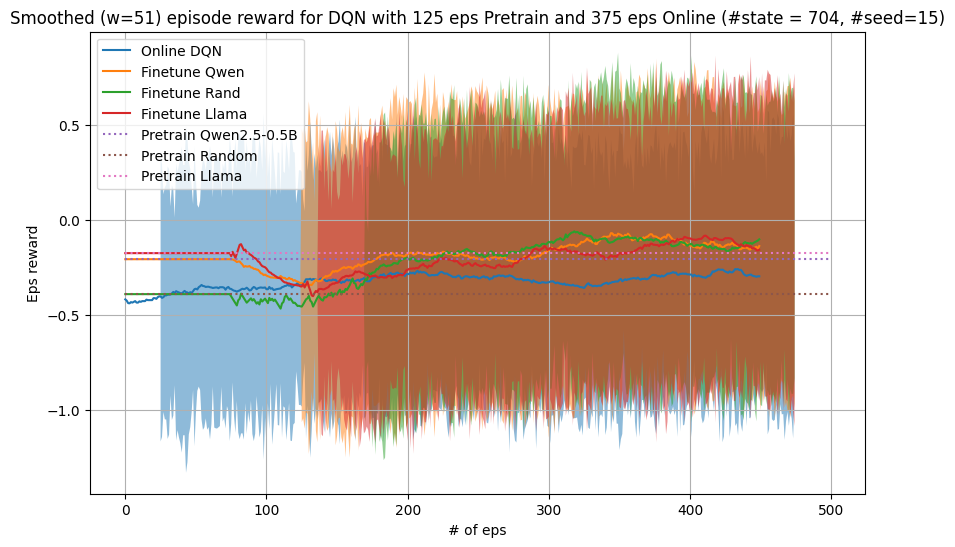

In [109]:
x = range(n_pretrain_eps + n_online_eps)
def moving_average(data, window_size):
    """Compute moving average using convolution."""
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

mean_llama_LORO = np.mean(llama_LORO_rewards, axis = 1)
std_llama_LORO = np.std(llama_LORO_rewards, axis = 1)
mean_Qwen_LORO = np.mean(Qwen_LORO_rewards, axis = 1)
std_Qwen_LORO = np.std(Qwen_LORO_rewards, axis = 1)
mean_rand_LORO = np.mean(rand_LORO_rewards, axis = 1)
std_rand_LORO = np.std(rand_LORO_rewards, axis = 1)
mean_onl = np.mean(onl_rewards, axis = 1)
std_onl = np.std(onl_rewards, axis = 1)

mean_Qwen_LORO[:n_pretrain_eps] = Qwen_avg[:n_pretrain_eps]
mean_llama_LORO[:n_pretrain_eps] = llama_avg[:n_pretrain_eps]
mean_rand_LORO[:n_pretrain_eps] = rand_avg[:n_pretrain_eps]

# Smooth the data
window_size = 51  # Must be an odd number
Qwen_LORO_y_smooth = moving_average(mean_Qwen_LORO, window_size)
rand_LORO_y_smooth = moving_average(mean_rand_LORO, window_size)
llama_LORO_y_smooth = moving_average(mean_llama_LORO, window_size)
onl_y_smooth = moving_average(mean_onl, window_size)

std_onl = std_onl[window_size//2:-window_size//2 + 1]
std_rand_LORO = std_rand_LORO[window_size//2:-window_size//2 + 1]
std_Qwen_LORO = std_Qwen_LORO[window_size//2:-window_size//2 + 1]
std_llama_LORO = std_llama_LORO[window_size//2:-window_size//2 + 1]
x_smooth = x[window_size//2:-window_size//2 + 1]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(onl_y_smooth, label='Online DQN')
plt.fill_between(x_smooth, onl_y_smooth-std_onl, onl_y_smooth+std_onl, alpha=0.5)
plt.plot(Qwen_LORO_y_smooth, label='Finetune Qwen')
plt.fill_between(x_smooth, Qwen_LORO_y_smooth-std_Qwen_LORO, Qwen_LORO_y_smooth+std_Qwen_LORO, alpha=0.5)
plt.plot(rand_LORO_y_smooth, label='Finetune Rand')
plt.fill_between(x_smooth, rand_LORO_y_smooth-std_rand_LORO, rand_LORO_y_smooth+std_rand_LORO, alpha=0.5)
plt.plot(llama_LORO_y_smooth, label='Finetune Llama')
plt.fill_between(x_smooth, llama_LORO_y_smooth-std_llama_LORO, llama_LORO_y_smooth+std_llama_LORO, alpha=0.5)

plt.plot(Qwen_avg, label='Pretrain Qwen2.5-0.5B', linestyle=':')
plt.plot(rand_avg, label='Pretrain Random', linestyle=':')
plt.plot(llama_avg, label='Pretrain Llama', linestyle=':')

# Customize the plot
plt.title(f'Smoothed (w={window_size}) episode reward for DQN with {n_pretrain_eps} eps Pretrain and {n_online_eps} eps Online (#state = 704, #seed={n_exp})')
plt.xlabel('# of eps')
plt.ylabel('Eps reward')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()